# **Internal validation metrics**

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

### **CVNN metric**

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

def get_nearest_neighbors(X, k):
    """
    Compute k nearest neighbors for all points

    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Input data
    k : int
        Number of nearest neighbors to consider

    Returns:
    --------
    distances : array of shape (n_samples, k)
        Distances to nearest neighbors
    indices : array of shape (n_samples, k)
        Indices of nearest neighbors
    """
    nbrs = NearestNeighbors(n_neighbors=k + 1)
    nbrs.fit(X)
    distances, indices = nbrs.kneighbors(X)
    # Remove self-references (first column)
    return distances[:, 1:], indices[:, 1:]

def compute_compactness(X, cluster_labels):
    """
    Compute Com(NC) - compactness measure for the clustering
    Com(NC) = Σᵢ[2/(nᵢ(nᵢ-1)) Σₓ,ᵧ∈Cᵢ d(x,y)]

    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Input data
    cluster_labels : array-like of shape (n_samples,)
        Cluster labels

    Returns:
    --------
    float
        Compactness measure
    """
    unique_labels = np.unique(cluster_labels)
    compactness = 0

    for label in unique_labels:
        cluster_points = X[cluster_labels == label]
        ni = len(cluster_points)

        if ni <= 1:  # Skip clusters with single point
            continue

        # Compute pairwise distances within cluster
        distances = cdist(cluster_points, cluster_points)

        # Sum all distances and normalize
        cluster_compactness = np.sum(distances) / (ni * (ni - 1))
        compactness += cluster_compactness

    return compactness

def compute_separation(X, cluster_labels, k):
    """
    Compute Sep(NC,k) = max_i( 1/n_i ∑j=1,2,...,n_i (q_j / k) )
    where:
    - n_i is the number of objects in cluster i
    - q_j is the number of k-nearest neighbors of the jth object that are not in its cluster

    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Input data
    cluster_labels : array-like of shape (n_samples,)
        Cluster labels
    k : int
        Number of nearest neighbors to consider
    """
    distances, indices = get_nearest_neighbors(X, k)
    unique_labels = np.unique(cluster_labels)
    max_cluster_separation = 0

    for label in unique_labels:
        # Get indices of points in current cluster (Ci)
        cluster_mask = cluster_labels == label
        cluster_points_idx = np.where(cluster_mask)[0]
        ni = len(cluster_points_idx)

        if ni == 0:
            continue

        # Calculate q_j/k for each point in the cluster
        cluster_separation = 0
        for idx in cluster_points_idx:
            # Get labels of nearest neighbors
            neighbor_labels = cluster_labels[indices[idx]]
            # Count neighbors not in the same cluster (q_j)
            qj = np.sum(neighbor_labels != label)
            # Add q_j/k to the sum
            cluster_separation += qj / k

        # Calculate average separation for this cluster (1/n_i * sum)
        avg_cluster_separation = cluster_separation / ni

        # Update max separation if this cluster's average is higher
        max_cluster_separation = max(max_cluster_separation, avg_cluster_separation)

    return max_cluster_separation

def calculate_cvnn_index(X, labels, k=10):
    """
    Compute CVNN² index for clustering validation

    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Input data
    labels : array-like of shape (n_samples,)
        Cluster labels
    k : int, default=10
        Number of nearest neighbors
    """
    X = np.asarray(X)
    labels = np.asarray(labels)

    if X.shape[0] != labels.shape[0]:
        raise ValueError("Number of samples in X and labels must match")

    if k >= X.shape[0]:
        raise ValueError("k must be less than number of samples")

    # Compute separation and compactness for current clustering
    separation = compute_separation(X, labels, k)
    compactness = compute_compactness(X, labels)

    # Compute final index
    index = (separation + compactness) / 2
    return separation, compactness, index

### **DBCV metric**

In [ ]:
"""Python translation of the original implementation of Prim's MST in MATLAB.

Reference source: https://github.com/pajaskowiak/dbcv/blob/main/src/MST_Edges.m
"""

import numpy as np
import numpy.typing as npt


def prim_mst(
    graph: npt.NDArray[np.float32], ind_root: int = 0
) -> npt.NDArray[np.float32]:
    n = len(graph)
    intree = np.full(n, fill_value=False)
    d = np.full(n, fill_value=np.inf)

    d[ind_root] = 0
    v = ind_root
    counter = 0

    G = {
        "MST_edges": {
            "node_inds": np.zeros((n - 1, 2), dtype=int),
            "weights": np.zeros(n - 1, dtype=float),
        },
        "MST_degrees": np.zeros(n, dtype=int),
        "MST_parent": np.arange(n),
    }

    while counter < n - 1:
        intree[v] = True
        dist = np.inf

        for w in np.arange(n):
            if w != v and not intree[w]:
                weight = graph[v, w]

                if d[w] > weight:
                    d[w] = weight
                    G["MST_parent"][w] = v

                if dist > d[w]:
                    dist = d[w]
                    next_v = w

        counter += 1
        G["MST_edges"]["node_inds"][counter - 1, :] = (G["MST_parent"][next_v], next_v)
        G["MST_edges"]["weights"][counter - 1] = graph[G["MST_parent"][next_v], next_v]
        G["MST_degrees"][G["MST_parent"][next_v]] += 1
        G["MST_degrees"][next_v] += 1
        v = next_v

    (inds_a, inds_b) = G["MST_edges"]["node_inds"].T
    weights = G["MST_edges"]["weights"]

    mst = np.zeros_like(graph)
    mst[inds_a, inds_b] = weights
    mst[inds_b, inds_a] = weights

    return mst

In [ ]:
import multiprocessing
import typing as t
import itertools
import functools

import numpy as np
import numpy.typing as npt
import sklearn.neighbors
import scipy.spatial.distance
import scipy.sparse.csgraph
import scipy.stats
import mpmath


_MP = mpmath.mp.clone()


def compute_pair_to_pair_dists(
    X: npt.NDArray[np.float64], metric: str
) -> npt.NDArray[np.float64]:
    dists = scipy.spatial.distance.cdist(X, X, metric=metric)
    np.maximum(dists, 1e-12, out=dists)
    # NOTE: set self-distance to +inf to prevent points being self-neighbors.
    np.fill_diagonal(dists, val=np.inf)
    return dists


def get_subarray(
    arr: npt.NDArray[np.float64],
    /,
    inds_a: t.Optional[npt.NDArray[np.int32]] = None,
    inds_b: t.Optional[npt.NDArray[np.int32]] = None,
) -> npt.NDArray[np.float64]:
    if inds_a is None:
        return arr
    if inds_b is None:
        inds_b = inds_a
    inds_a_mesh, inds_b_mesh = np.meshgrid(inds_a, inds_b)
    return arr[inds_a_mesh, inds_b_mesh].T


def get_internal_objects(
    mutual_reach_dists: npt.NDArray[np.float64], use_original_mst_implementation: bool
) -> npt.NDArray[np.float64]:
    if use_original_mst_implementation:
        mutual_reach_dists = np.copy(mutual_reach_dists)
        np.fill_diagonal(mutual_reach_dists, 0.0)
        mst = prim_mst(mutual_reach_dists)

    else:
        mst = scipy.sparse.csgraph.minimum_spanning_tree(mutual_reach_dists)
        mst = mst.toarray()
        mst += mst.T

    is_mst_edges = (mst > 0.0).astype(int, copy=False)

    internal_node_inds = is_mst_edges.sum(axis=0) > 1
    internal_node_inds = np.flatnonzero(internal_node_inds)

    internal_edge_weights = get_subarray(mst, inds_a=internal_node_inds)

    graph_has_internal_nodes = bool(internal_node_inds.size > 0)
    graph_has_at_least_two_internal_nodes = bool(internal_edge_weights.size > 1)

    return (
        (
            internal_node_inds
            if graph_has_internal_nodes
            else np.arange(mutual_reach_dists.shape[0])
        ),
        internal_edge_weights if graph_has_at_least_two_internal_nodes else mst,
    )


def compute_cluster_core_distance(
    dists: npt.NDArray[np.float64], d: int, enable_dynamic_precision: bool
) -> npt.NDArray[np.float64]:
    n, _ = dists.shape
    orig_dists_dtype = dists.dtype

    if enable_dynamic_precision:
        dists = np.asarray(_MP.matrix(dists), dtype=object).reshape(*dists.shape)

    core_dists = np.power(dists, -d).sum(axis=-1, keepdims=True) / (n - 1)

    if not enable_dynamic_precision:
        np.clip(core_dists, a_min=0.0, a_max=1e12, out=core_dists)

    np.power(core_dists, -1.0 / d, out=core_dists)

    if enable_dynamic_precision:
        core_dists = np.asarray(core_dists, dtype=orig_dists_dtype)

    return core_dists


def compute_mutual_reach_dists(
    dists: npt.NDArray[np.float64],
    d: float,
    enable_dynamic_precision: bool,
) -> npt.NDArray[np.float64]:
    core_dists = compute_cluster_core_distance(
        d=d, dists=dists, enable_dynamic_precision=enable_dynamic_precision
    )
    mutual_reach_dists = dists.copy()
    np.maximum(mutual_reach_dists, core_dists, out=mutual_reach_dists)
    np.maximum(mutual_reach_dists, core_dists.T, out=mutual_reach_dists)
    return (core_dists, mutual_reach_dists)


def fn_density_sparseness(
    cls_inds: npt.NDArray[np.int32],
    dists: npt.NDArray[np.float64],
    d: int,
    enable_dynamic_precision: bool,
    use_original_mst_implementation: bool,
) -> t.Tuple[float, npt.NDArray[np.float32], npt.NDArray[np.int32]]:
    (core_dists, mutual_reach_dists) = compute_mutual_reach_dists(
        dists=dists, d=d, enable_dynamic_precision=enable_dynamic_precision
    )
    (internal_node_inds, internal_edge_weights) = get_internal_objects(
        mutual_reach_dists,
        use_original_mst_implementation=use_original_mst_implementation,
    )
    dsc = float(internal_edge_weights.max())
    internal_core_dists = core_dists[internal_node_inds]
    internal_node_inds = cls_inds[internal_node_inds]
    return (dsc, internal_core_dists, internal_node_inds)


def fn_density_separation(
    cls_i: int,
    cls_j: int,
    dists: npt.NDArray[np.float64],
    internal_core_dists_i: npt.NDArray[np.float64],
    internal_core_dists_j: npt.NDArray[np.float64],
) -> t.Tuple[int, int, float]:
    sep = dists.copy()
    np.maximum(sep, internal_core_dists_i, out=sep)
    np.maximum(sep, internal_core_dists_j.T, out=sep)
    dspc_ij = float(sep.min()) if sep.size else np.inf
    return (cls_i, cls_j, dspc_ij)


def _check_duplicated_samples(X: npt.NDArray[np.float64], threshold: float = 1e-9):
    if X.shape[0] <= 1:
        return

    nn = sklearn.neighbors.NearestNeighbors(n_neighbors=1)
    nn.fit(X)
    dists, _ = nn.kneighbors(return_distance=True)

    if np.any(dists < threshold):
        raise ValueError("Duplicated samples have been found in X.")


def _convert_singleton_clusters_to_noise(
    y: npt.NDArray[np.int32], noise_id: int
) -> npt.NDArray[np.int32]:
    """Cast clusters containing a single instance as noise."""
    cluster_ids, cluster_sizes = np.unique(y, return_counts=True)
    singleton_clusters = cluster_ids[cluster_sizes == 1]

    if singleton_clusters.size == 0:
        return y

    return np.where(np.isin(y, singleton_clusters), noise_id, y)


def dbcv_cal(
    X: npt.NDArray[np.float64],
    y: npt.NDArray[np.int32],
    metric: str = "sqeuclidean",
    noise_id: int = -1,
    check_duplicates: bool = True,
    n_processes: t.Union[int, str] = "auto",
    enable_dynamic_precision: bool = False,
    bits_of_precision: int = 512,
    use_original_mst_implementation: bool = False,
) -> float:
    """Compute DBCV metric.

    Density-Based Clustering Validation (DBCV) is an intrinsic (= unsupervised/unlabeled)
    relative metric. See reference [1] for the original reference.

    Parameters
    ----------
    X : npt.NDArray[np.float64] of shape (N, D)
        Sample embeddings.

    y : npt.NDArray[np.int32] of shape (N,)
        Cluster IDs assigned for each sample in X.

    metric : str, default="sqeuclidean"
        This parameter specifies the metric function to compute dissimilarities between observations.
        The DBCV metric estimation may vary depending on the distance metric used.
        This argument is passed to `scipy.spatial.distance.cdist`.
        The default value is the squared Euclidean distance, which is also employed in the original
        MATLAB implementation (see reference [2]).

    noise_id : int, default=-1
        The noise "cluster" ID refers to instances where `y[i] = noise_id`, which are considered noise.
        Additionally, singleton clusters, meaning clusters containing only a single instance, are automatically
        classified as noise.

    check_duplicates : bool, default=True
        If set to True, check for duplicated samples before execution.
        Instances with Euclidean distance to their nearest neighbor below 1e-9 are considered
        duplicates.

    n_processes : int or "auto", default="auto"
        Maximum number of parallel processes for processing clusters and cluster pairs.
        If `n_processes="auto"`, the number of parallel processes will be set to 1 for
        datasets with 500 or fewer instances, and 4 for datasets with more than 500 instances.

    enable_dynamic_precision : bool, default=False
        If set to True, this activates a dynamic quantity of bits of precision for floating point during
        density calculation, as defined by the `bits_of_precision` argument below. Enabling this argument
        ensures proper density calculation for very high-dimensional data, although it significantly slows
        down the process compared to standard calculations.

    bits_of_precision : int, default=512
        Bits of precision for density calculation. High values are necessary for high
        dimensions to avoid underflow/overflow.

    use_original_mst_implementation : bool, default=False
        If set to False, the function will use Scipy's MST implementation (Kruskal's implementation).
        If set to True, the function will use an exact replica of the original MATLAB implementation.
        This version is a variant of Prim's MST algorithm.
        The original implementation is slower than Scipy's implementation and tends to create hub nodes
        much more often.
        Since these implementations are not equivalent, the DBCV metric estimation tends to vary depending
        on the MST algorithm used.

    Returns
    -------
    DBCV : float
        DBCV metric estimation.

    Source
    ------
    .. [1] "Density-Based Clustering Validation". Davoud Moulavi, Pablo A. Jaskowiak,
           Ricardo J. G. B. Campello, Arthur Zimek, Jörg Sander.
           https://www.dbs.ifi.lmu.de/~zimek/publications/SDM2014/DBCV.pdf
    .. [2] https://github.com/pajaskowiak/dbcv/
    """
    X = np.asarray(X, dtype=np.float64)

    if X.ndim == 1:
        X = X.reshape(-1, 1)

    y = np.asarray(y, dtype=int)

    n, d = X.shape  # NOTE: 'n' must be calculated before removing noise.

    if n != y.size:
        raise ValueError(f"Mismatch in {X.shape[0]=} and {y.size=} dimensions.")

    y = _convert_singleton_clusters_to_noise(y, noise_id=noise_id)

    non_noise_inds = y != noise_id
    X = X[non_noise_inds, :]
    y = y[non_noise_inds]

    if y.size == 0:
        return 0.0

    y = scipy.stats.rankdata(y, method="dense") - 1
    cluster_ids, cluster_sizes = np.unique(y, return_counts=True)

    if check_duplicates:
        _check_duplicated_samples(X)

    dists = compute_pair_to_pair_dists(X=X, metric=metric)

    # DSC: 'Density Sparseness of a Cluster'
    dscs = np.zeros(cluster_ids.size, dtype=float)

    # DSPC: 'Density Separation of a Pair of Clusters'
    min_dspcs = np.full(cluster_ids.size, fill_value=np.inf)

    # Internal objects = Internal nodes = nodes such that degree(node) > 1 in MST.
    internal_objects_per_cls: t.Dict[int, npt.NDArray[np.int32]] = {}

    # internal core distances = core distances of internal nodes
    internal_core_dists_per_cls: t.Dict[int, npt.NDArray[np.float32]] = {}

    cls_inds = [np.flatnonzero(y == cls_id) for cls_id in cluster_ids]

    if n_processes == "auto":
        n_processes = 4 if y.size > 500 else 1

    with _MP.workprec(bits_of_precision), multiprocessing.Pool(
        processes=min(n_processes, cluster_ids.size)
    ) as ppool:
        fn_density_sparseness_ = functools.partial(
            fn_density_sparseness,
            d=d,
            enable_dynamic_precision=enable_dynamic_precision,
            use_original_mst_implementation=use_original_mst_implementation,
        )

        args = [(cls_ind, get_subarray(dists, inds_a=cls_ind)) for cls_ind in cls_inds]

        for cls_id, (dsc, internal_core_dists, internal_node_inds) in enumerate(
            ppool.starmap(fn_density_sparseness_, args)
        ):
            internal_objects_per_cls[cls_id] = internal_node_inds
            internal_core_dists_per_cls[cls_id] = internal_core_dists
            dscs[cls_id] = dsc

    n_cls_pairs = (cluster_ids.size * (cluster_ids.size - 1)) // 2

    if n_cls_pairs > 0:
        with _MP.workprec(bits_of_precision), multiprocessing.Pool(
            processes=min(n_processes, n_cls_pairs)
        ) as ppool:
            args = [
                (
                    cls_i,
                    cls_j,
                    get_subarray(
                        dists,
                        inds_a=internal_objects_per_cls[cls_i],
                        inds_b=internal_objects_per_cls[cls_j],
                    ),
                    internal_core_dists_per_cls[cls_i],
                    internal_core_dists_per_cls[cls_j],
                )
                for cls_i, cls_j in itertools.combinations(cluster_ids, 2)
            ]

            for cls_i, cls_j, dspc_ij in ppool.starmap(fn_density_separation, args):
                min_dspcs[cls_i] = min(min_dspcs[cls_i], dspc_ij)
                min_dspcs[cls_j] = min(min_dspcs[cls_j], dspc_ij)

    np.nan_to_num(min_dspcs, copy=False, posinf=1e12)
    vcs = (min_dspcs - dscs) / (1e-12 + np.maximum(min_dspcs, dscs))
    np.nan_to_num(vcs, copy=False, nan=0.0)
    dbcv = float(np.sum(vcs * cluster_sizes)) / n

    return dbcv

### **CVDD metric**

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix

def cvdd_cal(X, piX, k=10):
    """
    Compute the CVDD Index for a dataset.
    Parameters:
        X (numpy.ndarray): The dataset (n_samples, n_features).
        piX (numpy.ndarray): The partition labels (n_samples,).
        k (int): Number of neighbors for density-involved distance (default=7).
    Returns:
        float: CVDD Index value.
    """
    # Compute Euclidean distance matrix
    d = cdist(X, X, metric='euclidean')

    try:
        # Compute Density-Involved Distance
        DD = Density_involved_distance(d, k)

        # Compute CVDD Index
        return CVDD(piX, d, DD)
    except Exception as e:
        # If an error occurs, return 0 (e.g., due to overlapping points)
        print(f"Error in CVDD computation: {e}")
        return 0


def CVDD(piX, d, DD):
    """
    Compute the CVDD index from partition and distance matrices.
    Parameters:
        piX (numpy.ndarray): Partition labels.
        d (numpy.ndarray): Euclidean distance matrix.
        DD (numpy.ndarray): Density-involved distance matrix.
    Returns:
        float: CVDD Index value.
    """
    unique_clusters = np.unique(piX)
    n_clusters = len(unique_clusters)

    sc_list = []  # Separation list
    com_list = []  # Compactness list

    for cluster in unique_clusters:
        a = np.where(piX == cluster)[0]  # Points in the current cluster
        b = np.where(piX != cluster)[0]  # Points outside the current cluster

        n = len(a)
        if n > 0:
            # Separation (minimum density-involved distance to other clusters)
            sep = np.min(DD[np.ix_(a, b)])
            sc_list.append(sep)

            # Compactness (path-based distance within the cluster)
            Ci = fast_PathbasedDist(d[np.ix_(a, a)])
            com = (np.std(Ci) / n) * np.mean(Ci)
            com_list.append(com)
        else:
            sc_list.append(0)
            com_list.append(max(com_list) if com_list else 1)

    # Compute overall separation and compactness
    sep = np.sum(sc_list)
    com = np.sum(com_list)

    # Compute CVDD index
    return sep / com if com > 0 else 0


def Density_involved_distance(d, k):
    """
    Compute the density-involved distance matrix.
    Parameters:
        d (numpy.ndarray): Euclidean distance matrix.
        k (int): Number of neighbors for density computation.
    Returns:
        numpy.ndarray: Density-involved distance matrix.
    """
    n = len(d)
    KNNG = KNearestNeighborGraph(d, k)

    # Compute density
    Den = np.array([np.sum(d[j, KNNG[j]]) / k for j in range(n)])
    fDen = Den / Den.max()  # Absolute-density distance factor

    # Compute relative density factor
    Rel = np.outer(Den, 1 / Den)
    fRel = 1 - np.exp(-np.abs(Rel + Rel.T - 2))

    # Compute density-involved distance components
    nD = np.outer(Den, np.ones(n)) + np.outer(np.ones(n), Den)
    relD = nD * fRel
    drD = d + relD

    # Compute connectivity distance
    conD = fast_PathbasedDist(drD)

    # Compute final density-involved distance
    tmp2 = np.sqrt(np.outer(fDen, fDen))
    return conD * tmp2


def KNearestNeighborGraph(d, k):
    """
    Compute the k-nearest neighbor graph.
    Parameters:
        d (numpy.ndarray): Distance matrix.
        k (int): Number of neighbors.
    Returns:
        list: k-nearest neighbors for each point.
    """
    n = len(d)
    np.fill_diagonal(d, np.inf)
    knn_indices = np.argsort(d, axis=1)[:, :k]
    return [list(knn) for knn in knn_indices]


def fast_PathbasedDist(W):
    """
    Compute the path-based distance matrix using the minimum spanning tree.
    Parameters:
        W (numpy.ndarray): Distance matrix.
    Returns:
        numpy.ndarray: Path-based distance matrix.
    """
    n = len(W)
    mst = minimum_spanning_tree(csr_matrix(W))
    mst_edges = np.array(mst.nonzero()).T

    # Initialize connectivity
    PathbasedW = np.zeros_like(W)
    Degrees = np.zeros(n, dtype=int)
    Connections = [[] for _ in range(n)]

    for edge in mst_edges:
        i, j = edge
        Degrees[i] += 1
        Degrees[j] += 1
        Connections[i].append(j)
        Connections[j].append(i)

    # Initialize tables
    CloseT = []
    OpenT = []

    # Find the first node with degree 1
    for i in range(n):
        if Degrees[i] == 1:
            break

    CloseT.append(i)
    Visited = np.zeros(n, dtype=bool)
    Visited[i] = True

    while len(CloseT) < n:
        current = CloseT[-1]
        neighbors = [node for node in Connections[current] if not Visited[node]]

        for neighbor in neighbors:
            # Update path-based distances
            for close_node in CloseT:
                PathbasedW[close_node, neighbor] = max(
                    PathbasedW[close_node, current], W[current, neighbor]
                )
                PathbasedW[neighbor, close_node] = PathbasedW[close_node, neighbor]

            # Update distances between open and neighbor nodes
            for open_node in OpenT:
                PathbasedW[open_node, neighbor] = max(
                    PathbasedW[open_node, current], W[current, neighbor]
                )
                PathbasedW[neighbor, open_node] = PathbasedW[open_node, neighbor]

        # Update connections between new neighbors
        for i in range(len(neighbors) - 1):
            for j in range(i + 1, len(neighbors)):
                PathbasedW[neighbors[i], neighbors[j]] = max(
                    W[neighbors[i], current], W[neighbors[j], current]
                )
                PathbasedW[neighbors[j], neighbors[i]] = PathbasedW[neighbors[i], neighbors[j]]

        # Add neighbors to OpenT
        OpenT.extend(neighbors)
        CloseT.append(OpenT.pop())

        Visited[CloseT[-1]] = True

    return PathbasedW

# **Data loading & preprocessing**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold

# Selected features from both methods
selected_features = [
    'Sommeil__mean',
    'Confort corporel__mean',
    'Moral__mean',
    'Sommeil__median',
    'Stress__mean',
    'Douleur__mean',
    'Fatigue__mean'
]

In [ ]:
import pandas as pd
# Load the dataset
df = pd.read_csv("dataset/eDOL_preprocessed_data.csv")

X_scaled = df.iloc[1:, 1:].reset_index(drop=True)

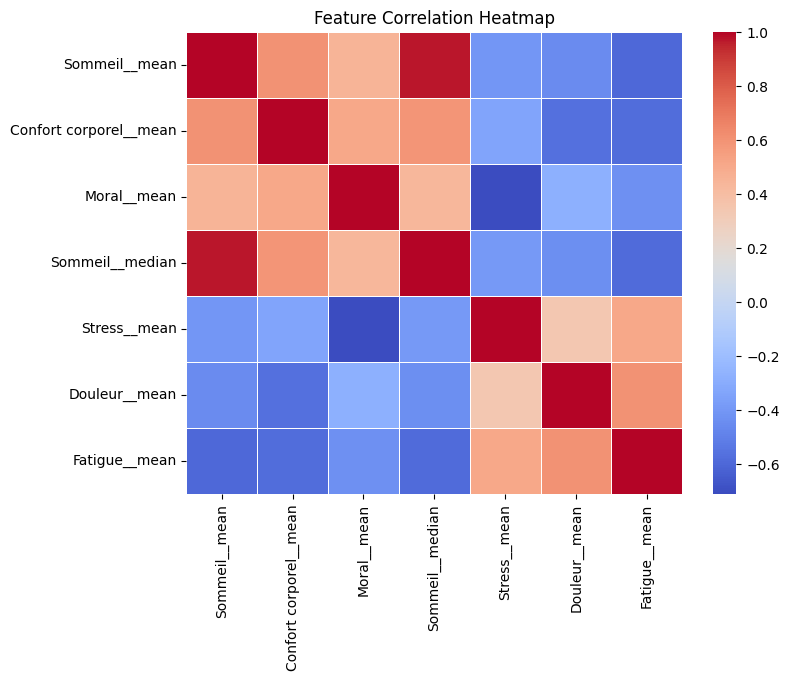

In [ ]:
# Compute the correlation matrix
correlation_matrix = X_scaled.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)

plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
def calculate_overlap_ratio(X, k=10):
    n = len(X)
    # Assign each point to its own cluster initially
    labels = np.arange(n)

    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    distances, indices = nbrs.kneighbors(X)

    e_values = []
    for i in range(n):
        neighbor_labels = labels[indices[i][1:]]
        cluster_counts = Counter(neighbor_labels)

        sum_term = 0
        for count in cluster_counts.values():
            if count > 0:
                sum_term += (count/k) * np.log(count/k)

        ei = sum_term / (np.log(1/n))
        e_values.append(ei)

    return np.mean(e_values)

In [ ]:
from sklearn.neighbors import NearestNeighbors
from collections import Counter
or_value = calculate_overlap_ratio(X_scaled, 10)
print(f"Dataset Overlapping Ratio: {or_value:.3f}")

Dataset Overlapping Ratio: 0.357


# **Implementation**

## **DBSCAN**

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import csv
import matplotlib.pyplot as plt
from collections import Counter

def optimize_dbscan_with_save(X, output_file='grid_search_results.csv'):
    # Define parameter ranges to search
    eps_range = np.linspace(0.1, 2.0, 20)
    min_samples_range = range(2, 15)

    best_score = -1
    best_params = None
    best_pred = None
    best_metrics = None

    print(f"Optimizing DBSCAN parameters for dataset...")

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_

    # Open the CSV file for writing results
    with open(output_file, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['eps', 'min_samples', 'sil', 'sep', 'com', 'cvnn', 'dbcv', 'cvdd'])

        eps = 1.1
        min_samples = 5

        # Initialize and fit DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        y_pred = dbscan.fit_predict(X_scaled)

        # Handle noise points
        y_pred_no_noise = y_pred.copy()
        unique_labels = set(label for label in y_pred if label != -1)

        # Calculate cluster centers
        centers = np.zeros((len(unique_labels), X_scaled.shape[1]))
        for i, label in enumerate(unique_labels):
            cluster_points = X_scaled[y_pred == label]
            centers[i] = np.mean(cluster_points, axis=0)

        # Assign noise points to nearest cluster
        noise_points = y_pred == -1
        for idx in np.where(noise_points)[0]:
            if len(centers) > 0:
                distances = [np.linalg.norm(X_scaled[idx] - center) for center in centers]
                y_pred_no_noise[idx] = list(unique_labels)[np.argmin(distances)]

        # Compute distance matrix
        dist_matrix = np.sqrt(np.sum((X_scaled[:, np.newaxis, :] - X_scaled[np.newaxis, :, :]) ** 2, axis=2))

        # Calculate metrics
        sil = silhouette_score(X_scaled, y_pred_no_noise)
        sep, com, cvnn = calculate_cvnn_index(X_scaled, y_pred_no_noise)
        cvdd = cvdd_cal(X_scaled, y_pred_no_noise)
        dbcv = dbcv_cal(X_scaled, y_pred_no_noise)

        writer.writerow([eps, min_samples, sil, sep, com, cvnn, dbcv, cvdd])

        best_score = sil
        best_params = {'eps': eps, 'min_samples': min_samples}
        best_pred = y_pred_no_noise
        best_metrics = {
            'Silhouette': sil,
            'Separation': sep,
            'Compactness': com,
            'CVNN': cvnn,
            'DBCV': dbcv,
            'CVDD': cvdd
        }

    print(Counter(best_pred))
    if best_params is None:
        print("\nNo valid clustering results found. Try different parameter ranges.")
        return None, None, None

    # Plot clustering results
    plt.figure(figsize=(8, 4))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                         c=best_pred, cmap='viridis',
                         s=20, edgecolors='k', alpha=0.7)
    plt.title(f"DBSCAN Clustering\n(eps={best_params['eps']:.3f}, min_samples={best_params['min_samples']})")
    plt.xlabel(f"PC1 ({explained_variance[0]:.1%} variance)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.1%} variance)")
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()

    return best_params, best_metrics, best_pred

Optimizing DBSCAN parameters for dataset...
Counter({0: 593, 1: 42})


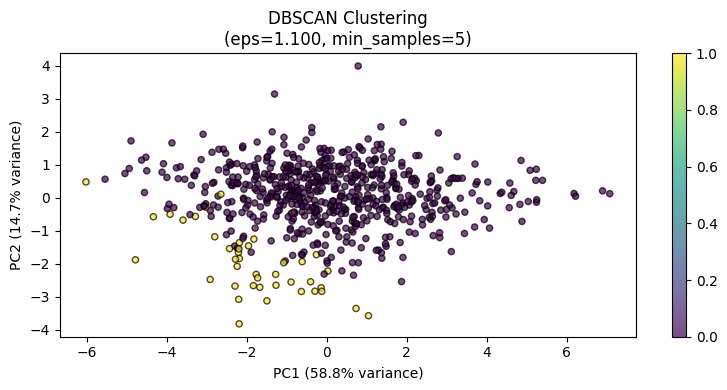

In [ ]:
import os

os.makedirs(f"results/eDOL/DBSCAN", exist_ok=True)
directory_path = f"results/eDOL/DBSCAN"
saved_file = os.path.join(directory_path,"grid_search_results.csv")
_, _, best_pred_dbscan =optimize_dbscan_with_save(X_scaled, saved_file)

In [ ]:
import pandas as pd
import os
from sklearn.metrics import adjusted_rand_score

def check_stability_dbscan(X, eps, min_samples, n_runs=10, output_dir="stability_results"):
    """
    Check stability of DBSCAN clustering with the same parameters and save results to files.

    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Training instances (standardized).
    eps : float
        Optimal value for eps.
    min_samples : int
        Optimal value for min_samples.
    n_runs : int
        Number of times to run DBSCAN.
    output_dir : str
        Directory to save clustering results.

    Returns:
    --------
    stability_scores : list of float
        List of ARI scores between each pair of runs.
    is_stable : bool
        True if all ARI scores are 1, indicating stability.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Run DBSCAN multiple times and save results
    cluster_results = []
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    for run_idx in range(n_runs):
        y_pred = dbscan.fit_predict(X)
        cluster_results.append(y_pred)

        # Save results to CSV
        result_file = os.path.join(output_dir, f"run_{run_idx + 1}.csv")
        pd.DataFrame({"Cluster_Label": y_pred}).to_csv(result_file, index=False)
        print(f"Saved clustering result for run {run_idx + 1} to {result_file}")

    # Calculate ARI between all pairs of runs
    stability_scores = []
    for i in range(n_runs):
        for j in range(i + 1, n_runs):
            ari = adjusted_rand_score(cluster_results[i], cluster_results[j])
            stability_scores.append(ari)

    print("Stability score average: ", np.mean(stability_scores))

    # Check if all ARI scores are 1
    # is_stable = all(score == 1 for score in stability_scores)

    return stability_scores

In [ ]:
# import os

os.makedirs(f"results/eDOL/DBSCAN/stability", exist_ok=True)
directory_path = f"results/eDOL/DBSCAN/stability"
# saved_file = os.path.join(directory_path,"grid_search_results.csv")
check_stability_dbscan(X_scaled, 1.1, 5, 10, directory_path)

Saved clustering result for run 1 to results/eDOL/DBSCAN/stability/run_1.csv
Saved clustering result for run 2 to results/eDOL/DBSCAN/stability/run_2.csv
Saved clustering result for run 3 to results/eDOL/DBSCAN/stability/run_3.csv
Saved clustering result for run 4 to results/eDOL/DBSCAN/stability/run_4.csv
Saved clustering result for run 5 to results/eDOL/DBSCAN/stability/run_5.csv
Saved clustering result for run 6 to results/eDOL/DBSCAN/stability/run_6.csv
Saved clustering result for run 7 to results/eDOL/DBSCAN/stability/run_7.csv
Saved clustering result for run 8 to results/eDOL/DBSCAN/stability/run_8.csv
Saved clustering result for run 9 to results/eDOL/DBSCAN/stability/run_9.csv
Saved clustering result for run 10 to results/eDOL/DBSCAN/stability/run_10.csv
Stability score average:  1.0


[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

## **Kernel K-means**

In [ ]:
from kernel_kmeans import KernelKMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import csv
import matplotlib.pyplot as plt
from collections import Counter

def optimize_kkm(X, n_clusters = 2, output_file='grid_search_results.csv'):
    # Define parameter ranges to search
    kernels = ['rbf', 'polynomial']
    gamma_range = np.logspace(-3, 2, 12)  # from 0.001 to 100

    best_score = -1
    best_params = None
    best_pred = None
    best_metrics = None

    # Apply PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_

    print(f"Optimizing Kernel K-means parameters for eDOL dataset...")

    # Open the CSV file for writing results
    with open(output_file, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # Write header
        writer.writerow(['kernel', 'gamma', 'sil', 'sep', 'com', 'cvnn', 'dbcv', 'cvdd'])

        # Grid search
        for kernel in kernels:
          for gamma in gamma_range:
            try:
                # Initialize and fit KernelKMeans
                km = KernelKMeans(
                    n_clusters=n_clusters,
                    kernel=kernel,
                    gamma=gamma,
                    max_iter=100,
                )

                # Fit and predict
                y_pred = km.fit_predict(X_scaled)

                # Calculate metrics
                sil = silhouette_score(X_scaled, y_pred)
                sep, com, cvnn = calculate_cvnn_index(X_scaled, y_pred)
                cvdd = cvdd_cal(X_scaled, y_pred)
                dbcv = dbcv_cal(X_scaled, y_pred)

                # Write results to the CSV file
                writer.writerow([kernel, gamma, sil, sep, com, cvnn, dbcv, cvdd])

                # Update best parameters if we found better accuracy
                if sil >= best_score:
                    best_score = sil
                    best_params = {'kernel': kernel, 'gamma': gamma}
                    best_pred = y_pred
                    best_metrics = {
                        'Silhouette': sil,
                        'Separation': sep,
                        'Compactness': com,
                        'CVNN': cvnn,
                        'DBCV': dbcv,
                        'CVDD': cvdd
                    }
            except Exception as e:
                print(f"Error with kernel={kernel}, gamma={gamma}: {e}")
    if best_params is None:
        print("\nNo valid clustering results found. Try different parameter ranges.")
        return None, None, None

    # Plot clustering results
    plt.figure(figsize=(8, 4))
    print(Counter(best_pred))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                         c=best_pred, cmap='viridis',
                         s=20, edgecolors='k', alpha=0.7)
    plt.title(f"Kernel K-means Clustering\n(kernel={best_params['kernel']}, gamma={best_params['gamma']})")
    plt.xlabel(f"PC1 ({explained_variance[0]:.1%} variance)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.1%} variance)")
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()

    return best_params, best_metrics, best_pred

Optimizing Kernel K-means parameters for eDOL dataset...
Counter({0: 411, 1: 224})


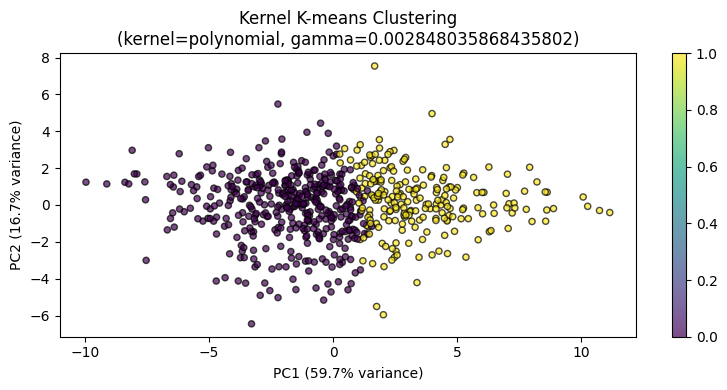

In [ ]:
import os

os.makedirs(f"results/eDOL/kkm", exist_ok=True)
directory_path = f"results/eDOL/kkm"
saved_file = os.path.join(directory_path,"kkm_grid_search_results.csv")
_, _, best_pred = optimize_kkm(X_scaled, 2, saved_file)

In [ ]:
import pandas as pd
import os
from sklearn.metrics import adjusted_rand_score

def check_stability_kkm(X, kernel, gamma, n_clusters = 2, n_runs=10, output_dir="stability_results"):
    """
    Check stability of Kernel K-means clustering with the same parameters and save results to files.

    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Training instances (standardized).
    n_runs : int
        Number of times to run DBSCAN.
    output_dir : str
        Directory to save clustering results.

    Returns:
    --------
    stability_scores : list of float
        List of ARI scores between each pair of runs.
    is_stable : bool
        True if all ARI scores are 1, indicating stability.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Run DBSCAN multiple times and save results
    cluster_results = []
    # Initialize and fit Kernel KMeans
    km = KernelKMeans(
        n_clusters=n_clusters,
        kernel=kernel,
        gamma=gamma,
        max_iter=100
    )

    for run_idx in range(n_runs):
        # Fit and predict
        y_pred = km.fit_predict(X_scaled)
        cluster_results.append(y_pred)

        # Save results to CSV
        result_file = os.path.join(output_dir, f"run_{run_idx + 1}.csv")
        pd.DataFrame({"Cluster_Label": y_pred}).to_csv(result_file, index=False)
        print(f"Saved clustering result for run {run_idx + 1} to {result_file}")

    # Calculate ARI between all pairs of runs
    stability_scores = []
    for i in range(n_runs):
        for j in range(i + 1, n_runs):
            ari = adjusted_rand_score(cluster_results[i], cluster_results[j])
            stability_scores.append(ari)

    print("Stability score average: ", np.mean(stability_scores))

    # Check if all ARI scores are 1
    # is_stable = all(score == 1 for score in stability_scores)

    return stability_scores

In [ ]:
os.makedirs(f"results/eDOL/kkm/stability", exist_ok=True)
directory_path = f"results/eDOL/kkm/stability"
check_stability_kkm(X_scaled, 'polynomial', 0.002848035868435802, 2, 10, directory_path)

Saved clustering result for run 1 to results/eDOL/kkm/stability/run_1.csv
Saved clustering result for run 2 to results/eDOL/kkm/stability/run_2.csv
Saved clustering result for run 3 to results/eDOL/kkm/stability/run_3.csv
Saved clustering result for run 4 to results/eDOL/kkm/stability/run_4.csv
Saved clustering result for run 5 to results/eDOL/kkm/stability/run_5.csv
Saved clustering result for run 6 to results/eDOL/kkm/stability/run_6.csv
Saved clustering result for run 7 to results/eDOL/kkm/stability/run_7.csv
Saved clustering result for run 8 to results/eDOL/kkm/stability/run_8.csv
Saved clustering result for run 9 to results/eDOL/kkm/stability/run_9.csv
Saved clustering result for run 10 to results/eDOL/kkm/stability/run_10.csv
Stability score average:  1.0


[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

## **Kernel Fuzzy C-means**

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import csv
import matplotlib.pyplot as plt
from kernel_fcm import kernel_gfcm
from sklearn.decomposition import PCA
import csv
import matplotlib.pyplot as plt
from collections import Counter

def optimize_kfcm(X, n_clusters = 2, output_file='grid_search_results.csv'):
    # Define parameter ranges to search
    # sigma_range = np.logspace(-2, 2, 10)  # from 0.01 to 100
    # m_range = np.linspace(1.1, 3.0, 10)   # fuzzy parameter range

    best_score = -1
    best_params = None
    best_pred = None
    best_metrics = None

    sigma = 2
    fuzzy = 1.5

    # Apply PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_

    print(f"Optimizing Kernel Fuzzy C-means parameters for eDOL dataset...")

    # Open the CSV file for writing results
    with open(output_file, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # Write header
        writer.writerow(['sigma', 'fuzzy', 'sil', 'sep', 'com', 'cvnn', 'dbcv', 'cvdd'])

        # Grid search
        # for sigma in sigma_range:
        #     for fuzzy in m_range:
                # Run Kernel FCM
        centers, y_pred, cost = kernel_gfcm(
            X_scaled.values,
            n_clusters=n_clusters,
            sigma=sigma,
            m=fuzzy,
            p=2,  # Set p=2 for Kernel FCM
            max_iter=300,
            n_init=30
        )

        # Calculate metrics
        sil = silhouette_score(X_scaled, y_pred)
        sep, com, cvnn = calculate_cvnn_index(X_scaled, y_pred)
        cvdd = cvdd_cal(X_scaled, y_pred)
        dbcv = dbcv_cal(X_scaled, y_pred)

        # Write results to the CSV file
        writer.writerow([sigma, fuzzy, sil, sep, com, cvnn, dbcv, cvdd])

        # Update best parameters if we found better accuracy
        if cvdd >= best_score:
            best_score = cvdd
            best_params = {'sigma': sigma, 'fuzzy': fuzzy}
            best_pred = y_pred
            best_metrics = {
                'Silhouette': sil,
                'Separation': sep,
                'Compactness': com,
                'CVNN': cvnn,
                'DBCV': dbcv,
                'CVDD': cvdd
            }

    print(Counter(best_pred))

    if best_params is None:
        print("\nNo valid clustering results found. Try different parameter ranges.")
        return None, None, None

    # Plot clustering results
    plt.figure(figsize=(8, 4))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                         c=best_pred, cmap='viridis',
                         s=20, edgecolors='k', alpha=0.7)
    plt.title(f"Kernel Fuzzy C-means Clustering\n(sigma={best_params['sigma']}, fuzzy={best_params['fuzzy']})")
    plt.xlabel(f"PC1 ({explained_variance[0]:.1%} variance)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.1%} variance)")
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()

    return best_params, best_metrics, best_pred

Optimizing Kernel Fuzzy C-means parameters for eDOL dataset...
Counter({0: 322, 1: 313})


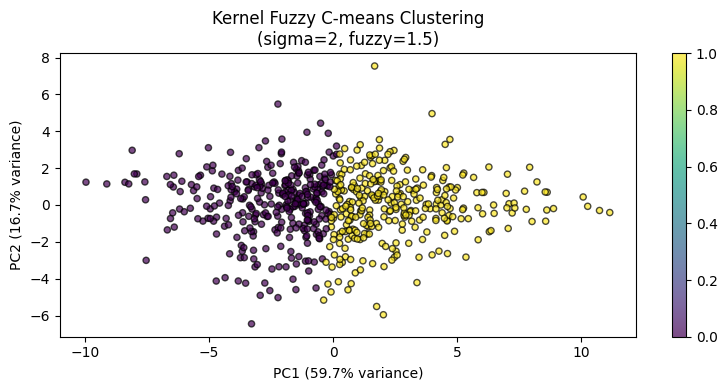

In [ ]:
import os
os.makedirs(f"results/eDOL/kfcm", exist_ok=True)
directory_path = f"results/eDOL/kfcm"
saved_file = os.path.join(directory_path,"kfcm_grid_search_results.csv")
_, _, kfcm_best_pred = optimize_kfcm(X_scaled, 2, saved_file)

In [ ]:
import pandas as pd
import os
from sklearn.metrics import adjusted_rand_score

def check_stability_kfcm(X, sigma, fuzzy, n_clusters = 2, n_runs=10, output_dir="stability_results"):
    """
    Check stability of Kernel K-means clustering with the same parameters and save results to files.

    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Training instances (standardized).
    n_runs : int
        Number of times to run DBSCAN.
    output_dir : str
        Directory to save clustering results.

    Returns:
    --------
    stability_scores : list of float
        List of ARI scores between each pair of runs.
    is_stable : bool
        True if all ARI scores are 1, indicating stability.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    cluster_results = []

    for run_idx in range(n_runs):
        # Run Kernel FCM
        centers, y_pred, cost = kernel_gfcm(
            X_scaled.values,
            n_clusters=n_clusters,
            sigma=sigma,
            m=fuzzy,
            p=2,  # Set p=2 for Kernel FCM
            max_iter=300,
            n_init=1
        )
        cluster_results.append(y_pred)

        # Save results to CSV
        result_file = os.path.join(output_dir, f"run_{run_idx + 1}.csv")
        pd.DataFrame({"Cluster_Label": y_pred}).to_csv(result_file, index=False)
        print(f"Saved clustering result for run {run_idx + 1} to {result_file}")

    # Calculate ARI between all pairs of runs
    stability_scores = []
    for i in range(n_runs):
        for j in range(i + 1, n_runs):
            ari = adjusted_rand_score(cluster_results[i], cluster_results[j])
            stability_scores.append(ari)

    print("Stability score average: ", np.mean(stability_scores))

    # Check if all ARI scores are 1
    # is_stable = all(score == 1 for score in stability_scores)

    return stability_scores

In [ ]:
os.makedirs(f"results/eDOL/kfcm/stability", exist_ok=True)
directory_path = f"results/eDOL/kfcm/stability"
check_stability_kfcm(X_scaled, 2, 1.5, 2, 10, directory_path)

Saved clustering result for run 1 to results/eDOL/kfcm/stability/run_1.csv
Saved clustering result for run 2 to results/eDOL/kfcm/stability/run_2.csv
Saved clustering result for run 3 to results/eDOL/kfcm/stability/run_3.csv
Saved clustering result for run 4 to results/eDOL/kfcm/stability/run_4.csv
Saved clustering result for run 5 to results/eDOL/kfcm/stability/run_5.csv
Saved clustering result for run 6 to results/eDOL/kfcm/stability/run_6.csv
Saved clustering result for run 7 to results/eDOL/kfcm/stability/run_7.csv
Saved clustering result for run 8 to results/eDOL/kfcm/stability/run_8.csv
Saved clustering result for run 9 to results/eDOL/kfcm/stability/run_9.csv
Saved clustering result for run 10 to results/eDOL/kfcm/stability/run_10.csv
Stability score average:  1.0


[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

## **Spectral Clustering**

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
import numpy as np
import csv
import matplotlib.pyplot as plt
from collections import Counter

def optimize_spectral(X, n_clusters = 2, output_file='grid_search_results.csv'):
    # Define parameter ranges to search
    # gamma_range = np.logspace(-3, 2, 20)  # from 0.001 to 100
    gamma = 0.01

    best_score = -1
    best_params = None
    best_pred = None
    best_metrics = None

    # Apply PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_

    print(f"Optimizing Spectral Clustering parameters for eDOL dataset...")

    # Open the CSV file for writing results
    with open(output_file, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # Write header
        writer.writerow(['gamma', 'sil', 'sep', 'com', 'cvnn', 'dbcv', 'cvdd'])

        # Grid search
        # for gamma in gamma_range:
              # Initialize and fit Spectral Clustering
        sp = SpectralClustering(
            n_clusters=n_clusters,
            gamma=gamma,
            affinity='rbf',
        )

        # Fit and predict
        y_pred = sp.fit_predict(X_scaled)

        # Calculate metrics
        sil = silhouette_score(X_scaled, y_pred)
        sep, com, cvnn = calculate_cvnn_index(X_scaled, y_pred)
        cvdd = cvdd_cal(X_scaled, y_pred)
        dbcv = dbcv_cal(X_scaled, y_pred)

        # Write results to the CSV file
        writer.writerow([gamma, sil, sep, com, cvnn, dbcv, cvdd])

        # Update best parameters if we found better accuracy
        if sil >= best_score:
            best_score = sil
            best_params = {'gamma': gamma}
            best_pred = y_pred
            best_metrics = {
                'Silhouette': sil,
                'Separation': sep,
                'Compactness': com,
                'CVNN': cvnn,
                'DBCV': dbcv,
                'CVDD': cvdd
            }

    print(Counter(best_pred))
    if best_params is None:
        print("\nNo valid clustering results found. Try different parameter ranges.")
        return None, None, None

    # Plot clustering results
    plt.figure(figsize=(8, 4))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                         c=best_pred, cmap='viridis',
                         s=20, edgecolors='k', alpha=0.7)
    plt.title(f"Spectral Clustering\n(gamma={best_params['gamma']})")
    plt.xlabel(f"PC1 ({explained_variance[0]:.1%} variance)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.1%} variance)")
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()

    return best_params, best_metrics, best_pred

Optimizing Spectral Clustering parameters for eDOL dataset...
Counter({1: 377, 0: 258})


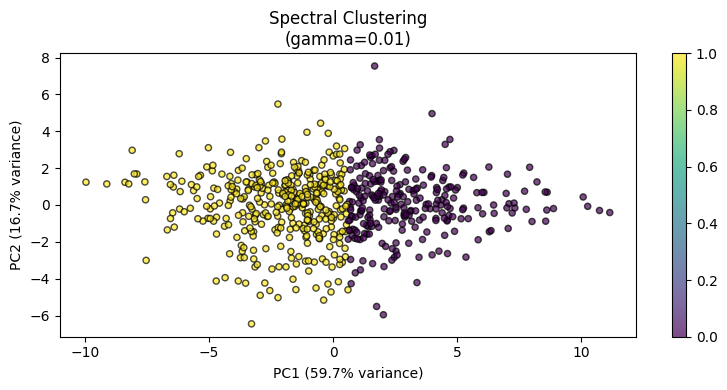

In [ ]:
import os

os.makedirs(f"results/eDOL/spectral", exist_ok=True)
directory_path = f"results/eDOL/spectral"
saved_file = os.path.join(directory_path,"spectral_grid_search_results.csv")
_, _, spectral_best_pred = optimize_spectral(X_scaled, 2, saved_file)

In [ ]:
import pandas as pd
import os
from sklearn.metrics import adjusted_rand_score

def check_stability_spectral(X, gamma, n_clusters = 2, n_runs=10, output_dir="stability_results"):
    """
    Check stability of Spectral clustering with the same parameters and save results to files.

    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Training instances (standardized).
    n_runs : int
        Number of times to run DBSCAN.
    output_dir : str
        Directory to save clustering results.

    Returns:
    --------
    stability_scores : list of float
        List of ARI scores between each pair of runs.
    is_stable : bool
        True if all ARI scores are 1, indicating stability.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    cluster_results = []

    for run_idx in range(n_runs):
        # Initialize and fit Spectral Clustering
        sp = SpectralClustering(
            n_clusters=n_clusters,
            gamma=gamma,
            affinity='rbf'
        )

        # Fit and predict
        y_pred = sp.fit_predict(X_scaled)
        cluster_results.append(y_pred)

        # Save results to CSV
        result_file = os.path.join(output_dir, f"run_{run_idx + 1}.csv")
        pd.DataFrame({"Cluster_Label": y_pred}).to_csv(result_file, index=False)
        print(f"Saved clustering result for run {run_idx + 1} to {result_file}")

    # Calculate ARI between all pairs of runs
    stability_scores = []
    for i in range(n_runs):
        for j in range(i + 1, n_runs):
            ari = adjusted_rand_score(cluster_results[i], cluster_results[j])
            stability_scores.append(ari)

    print("Stability score average: ", np.mean(stability_scores))

    # Check if all ARI scores are 1
    # is_stable = all(score == 1 for score in stability_scores)

    return stability_scores

In [ ]:
os.makedirs(f"results/eDOL/spectral/stability", exist_ok=True)
directory_path = f"results/eDOL/spectral/stability"
check_stability_spectral(X_scaled, 0.01, 2, 10, directory_path)

Saved clustering result for run 1 to results/eDOL/spectral/stability/run_1.csv
Saved clustering result for run 2 to results/eDOL/spectral/stability/run_2.csv
Saved clustering result for run 3 to results/eDOL/spectral/stability/run_3.csv
Saved clustering result for run 4 to results/eDOL/spectral/stability/run_4.csv
Saved clustering result for run 5 to results/eDOL/spectral/stability/run_5.csv
Saved clustering result for run 6 to results/eDOL/spectral/stability/run_6.csv
Saved clustering result for run 7 to results/eDOL/spectral/stability/run_7.csv
Saved clustering result for run 8 to results/eDOL/spectral/stability/run_8.csv
Saved clustering result for run 9 to results/eDOL/spectral/stability/run_9.csv
Saved clustering result for run 10 to results/eDOL/spectral/stability/run_10.csv
Stability score average:  1.0


[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

## **DEC**

In [ ]:
from scipy.optimize import linear_sum_assignment as linear_assignment

def acc_score(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    ind = np.asarray(ind)
    return sum([w[i, j] for i, j in zip(ind[0], ind[1])]) * 1.0 / y_pred.size

In [ ]:
"""
Stabilized Deep Embedded Clustering (DEC) implementation
Includes fixes for initialization, training, and convergence stability
"""

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, InputSpec, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import callbacks
from tensorflow.keras.initializers import GlorotUniform
from sklearn.cluster import KMeans, SpectralClustering
from time import time
from sklearn.metrics.pairwise import rbf_kernel

class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=tf.float32, shape=(None, input_dim))

        # Use fixed seed for cluster centers initialization
        self.clusters = self.add_weight(
            shape=(self.n_clusters, input_dim),
            initializer=GlorotUniform(),
            name='clusters'
        )

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (tf.reduce_sum(tf.square(tf.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = tf.transpose(tf.transpose(q) / tf.reduce_sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def autoencoder(dims, act='relu'):
    """
    Stable autoencoder with fixed random seed and consistent initialization
    """
    n_stacks = len(dims) - 1
    init = GlorotUniform()

    x = Input(shape=(dims[0],), name='input')
    h = x

    # Encoder layers
    for i in range(n_stacks-1):
        h = Dense(
            dims[i + 1],
            activation=act,
            kernel_initializer=init,
            kernel_regularizer=tf.keras.regularizers.l2(1e-4),
            name=f'encoder_{i}'
        )(h)

    # Hidden layer
    h = Dense(
        dims[-1],
        kernel_initializer=init,
        kernel_regularizer=tf.keras.regularizers.l2(1e-4),
        name=f'encoder_{n_stacks - 1}'
    )(h)

    y = h
    # Decoder layers
    for i in range(n_stacks-1, 0, -1):
        y = Dense(
            dims[i],
            activation=act,
            kernel_initializer=init,
            kernel_regularizer=tf.keras.regularizers.l2(1e-4),
            name=f'decoder_{i}'
        )(y)

    y = Dense(
        dims[0],
        kernel_initializer=init,
        kernel_regularizer=tf.keras.regularizers.l2(1e-4),
        name='decoder_0'
    )(y)

    return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')

class DEC:
    def __init__(self, dims, n_clusters=10, alpha=1.0, affinity='rbf', n_neighbors=10):
        # # Set global random seeds
        # tf.random.set_seed(seed)
        # np.random.seed(seed)

        self.dims = dims
        self.input_dim = dims[0]
        self.n_clusters = n_clusters
        self.alpha = alpha
        # self.seed = seed
        self.affinity = affinity
        self.n_neighbors = n_neighbors

        # Initialize models with fixed seed
        self.autoencoder, self.encoder = autoencoder(self.dims)

        # Prepare DEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        self.model = Model(inputs=self.encoder.input, outputs=clustering_layer)

        # Initialize moving averages for target distribution
        self.q_moving_avg = None
        self.momentum = 0.9

        # Initialize metrics tracking
        self.loss_history = []
        self.delta_labels_history = []

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='results/temp'):
        print('Pretraining...')

        # Add learning rate schedule
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.001,
            decay_steps=1000,
            decay_rate=0.9
        )

        if optimizer == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        else:
            optimizer = optimizer

        # Compile with L2 regularization
        self.autoencoder.compile(
            optimizer=optimizer,
            loss='mse',
            metrics=['mse']
        )

        # Callbacks
        callbacks_list = [
            callbacks.EarlyStopping(monitor='loss', patience=10),
            callbacks.ModelCheckpoint(
                filepath=f'{save_dir}/ae_weights.h5',
                monitor='loss',
                save_best_only=True
            ),
            # callbacks.ReduceLROnPlateau(
            #     monitor='loss',
            #     factor=0.1,
            #     patience=5,
            #     min_lr=0.00001
            # )
        ]

        # Train with shuffling and validation split
        self.autoencoder.fit(
            x, x,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks_list,
            validation_split=0.1,
            shuffle=True
        )

    def update_target_distribution(self, q):
        """Update target distribution p with momentum"""
        p = self.target_distribution(q)

        if self.q_moving_avg is None:
            self.q_moving_avg = q
        else:
            self.q_moving_avg = self.momentum * self.q_moving_avg + (1 - self.momentum) * q

        return self.target_distribution(self.q_moving_avg)

    @staticmethod
    def target_distribution(q):
        """Compute target distribution with cluster size balancing"""
        weight = q ** 2 / q.sum(0)
        p = (weight.T / weight.sum(1)).T

        # Add cluster size balancing
        cluster_sizes = p.sum(axis=0)
        p = p / (cluster_sizes + 1e-8)  # Add small epsilon to avoid division by zero

        return p

    def compile(self, optimizer=None, loss='kld'):
        if optimizer is None:
            # Custom learning rate schedule
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=0.01,
                decay_steps=1000,
                decay_rate=0.9
            )
            # Create optimizer with gradient clipping
            optimizer = tf.keras.optimizers.SGD(
                learning_rate=lr_schedule,
                momentum=0.9,
                clipnorm=1.0  # Use clipnorm instead of clipvalue
            )

        self.model.compile(
            optimizer=optimizer,
            loss=loss
        )

    def _compute_affinity_matrix(self, X):
        """
        Compute affinity matrix based on the chosen affinity type
        """
        if self.affinity == 'rbf':
            # Compute RBF kernel with automatic bandwidth selection
            distances = rbf_kernel(X)
            return distances
        elif self.affinity == 'nearest_neighbors':
            # Compute nearest neighbors affinity
            from sklearn.neighbors import kneighbors_graph
            connectivity = kneighbors_graph(
                X, n_neighbors=self.n_neighbors,
                mode='connectivity', include_self=True
            )
            return 0.5 * (connectivity + connectivity.T)
        else:
            raise ValueError(f"Unsupported affinity type: {self.affinity}")

    def _initialize_cluster_centers(self, embeddings):
        """
        Initialize cluster centers using Spectral Clustering
        """
        print("Initializing cluster centers with Spectral Clustering...")

        # Compute affinity matrix
        affinity_matrix = self._compute_affinity_matrix(embeddings)

        # Apply Spectral Clustering
        spectral = SpectralClustering(
            n_clusters=self.n_clusters,
            # random_state=self.seed,
            affinity='precomputed',
            n_init=10,
            gamma = 50
        )

        cluster_labels = spectral.fit_predict(affinity_matrix)

        # Compute cluster centers
        cluster_centers = np.zeros((self.n_clusters, embeddings.shape[1]))
        for i in range(self.n_clusters):
            cluster_centers[i] = embeddings[cluster_labels == i].mean(axis=0)

        return cluster_centers, cluster_labels

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3, update_interval=140, save_dir='results/temp'):
        print('Training DEC...')

        # Get embedded features
        embeddings = self.encoder.predict(x)

        # Initialize cluster centers using Spectral Clustering
        cluster_centers, y_pred = self._initialize_cluster_centers(embeddings)

        # Set cluster centers in the clustering layer
        self.model.get_layer('clustering').set_weights([cluster_centers])

        # Initialize training variables
        index_array = np.arange(x.shape[0])
        index = 0
        loss = 0
        y_pred_last = y_pred

        # Initialize metrics tracking
        patience = 10
        patience_counter = 0
        best_loss = float('inf')

        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.update_target_distribution(q)
                y_pred = q.argmax(1)

                # Track metrics
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                self.delta_labels_history.append(delta_label)
                self.loss_history.append(loss)

                # Check convergence with multiple criteria
                if ite > 0:
                    # Check label changes
                    if delta_label < tol:
                        patience_counter += 1
                    else:
                        patience_counter = 0

                    # Check loss improvement
                    if loss < best_loss:
                        best_loss = loss
                        # Save best model
                        self.model.save_weights(f'{save_dir}/dec_best_model.weights.h5')

                    # Stop if both criteria are met
                    if patience_counter >= patience:
                        print('Converged: label changes < tol for {} iterations'.format(patience))
                        break

                y_pred_last = np.copy(y_pred)

            # Train on batch with shuffling
            if index == 0:
                np.random.shuffle(index_array)
            idx = index_array[index * batch_size: min((index + 1) * batch_size, x.shape[0])]
            loss = self.model.train_on_batch(x=x[idx], y=p[idx])
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

        # Load best model
        self.model.load_weights(f'{save_dir}/dec_best_model.weights.h5')
        return y_pred

    def predict(self, x):
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

Pretraining...
Epoch 1/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 27.1514 - mse: 27.1427

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 22.2394 - mse: 22.2308 - val_loss: 10.8960 - val_mse: 10.8875
Epoch 2/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.5111 - mse: 11.5027

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.6803 - mse: 8.6719 - val_loss: 2.9525 - val_mse: 2.9443
Epoch 3/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.2881 - mse: 3.2799

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4703 - mse: 2.4621 - val_loss: 1.9949 - val_mse: 1.9869
Epoch 4/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 1.8242 - mse: 1.8162

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5820 - mse: 1.5741 - val_loss: 1.4454 - val_mse: 1.4375
Epoch 5/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 1.1607 - mse: 1.1529

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2377 - mse: 1.2300 - val_loss: 1.1937 - val_mse: 1.1860
Epoch 6/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.2925 - mse: 1.2848

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0729 - mse: 1.0653 - val_loss: 1.0817 - val_mse: 1.0742
Epoch 7/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8551 - mse: 0.8476

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8591 - mse: 0.8516 - val_loss: 1.0023 - val_mse: 0.9949
Epoch 8/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8175 - mse: 0.8100

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9280 - mse: 0.9205 - val_loss: 0.9441 - val_mse: 0.9367
Epoch 9/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6752 - mse: 0.6678

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7584 - mse: 0.7511 - val_loss: 0.8709 - val_mse: 0.8637
Epoch 10/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7301 - mse: 0.7229

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7062 - mse: 0.6989 - val_loss: 0.8019 - val_mse: 0.7947
Epoch 11/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.8996 - mse: 0.8924

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6758 - mse: 0.6686 - val_loss: 0.7239 - val_mse: 0.7168
Epoch 12/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1130 - mse: 1.1058

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6553 - mse: 0.6482 - val_loss: 0.6458 - val_mse: 0.6387
Epoch 13/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 0.5427 - mse: 0.5356

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5929 - mse: 0.5859 - val_loss: 0.5832 - val_mse: 0.5761
Epoch 14/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4176 - mse: 0.4105

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4881 - mse: 0.4810 - val_loss: 0.5333 - val_mse: 0.5263
Epoch 15/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3441 - mse: 0.3370

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4555 - mse: 0.4484 - val_loss: 0.5073 - val_mse: 0.5002
Epoch 16/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5450 - mse: 0.5380

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4768 - mse: 0.4698 - val_loss: 0.4828 - val_mse: 0.4758
Epoch 17/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4688 - mse: 0.4618  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4613 - mse: 0.4543 - val_loss: 0.4692 - val_mse: 0.4622
Epoch 18/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4117 - mse: 0.4048 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4204 - mse: 0.4134 - val_loss: 0.4570 - val_mse: 0.4500
Epoch 19/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4413 - mse: 0.4344 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4404 - mse: 0.4334 - val_loss: 0.4465 - val_mse: 0.4396
Epoch 20/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4394 - mse: 0.4325 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4367 - mse: 0.4298 - val_loss: 0.4388 - val_mse: 0.4319
Epoch 21/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4516 - mse: 0.4447 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4422 - mse: 0.4353 - val_loss: 0.4315 - val_mse: 0.4246
Epoch 22/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4122 - mse: 0.4053  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4118 - mse: 0.4049 - val_loss: 0.4218 - val_mse: 0.4149
Epoch 23/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4237 - mse: 0.4168 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4158 - mse: 0.4089 - val_loss: 0.4150 - val_mse: 0.4081
Epoch 24/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4007 - mse: 0.3939 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4013 - mse: 0.3944 - val_loss: 0.4059 - val_mse: 0.3990
Epoch 25/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3691 - mse: 0.3622 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3716 - mse: 0.3647 - val_loss: 0.3975 - val_mse: 0.3907
Epoch 26/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4268 - mse: 0.4200 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4144 - mse: 0.4075 - val_loss: 0.3910 - val_mse: 0.3841
Epoch 27/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3543 - mse: 0.3474 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3578 - mse: 0.3509 - val_loss: 0.3818 - val_mse: 0.3750
Epoch 28/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3088 - mse: 0.3019

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3462 - mse: 0.3393 - val_loss: 0.3670 - val_mse: 0.3601
Epoch 29/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.2975 - mse: 0.2906

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3440 - mse: 0.3371 - val_loss: 0.3622 - val_mse: 0.3553
Epoch 30/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2794 - mse: 0.2725

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3411 - mse: 0.3342 - val_loss: 0.3510 - val_mse: 0.3440
Epoch 31/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.2554 - mse: 0.2485

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3259 - mse: 0.3190 - val_loss: 0.3444 - val_mse: 0.3375
Epoch 32/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.3955 - mse: 0.3886

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3703 - mse: 0.3633 - val_loss: 0.3363 - val_mse: 0.3293
Epoch 33/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.3396 - mse: 0.3326

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3253 - mse: 0.3184 - val_loss: 0.3359 - val_mse: 0.3290
Epoch 34/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3592 - mse: 0.3522 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3530 - mse: 0.3461 - val_loss: 0.3229 - val_mse: 0.3160
Epoch 35/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3262 - mse: 0.3193 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3256 - mse: 0.3187 - val_loss: 0.3191 - val_mse: 0.3122
Epoch 36/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2988 - mse: 0.2918

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2868 - mse: 0.2799 - val_loss: 0.3159 - val_mse: 0.3089
Epoch 37/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2212 - mse: 0.2142

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2744 - mse: 0.2674 - val_loss: 0.3117 - val_mse: 0.3047
Epoch 38/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.2145 - mse: 0.2075

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2814 - mse: 0.2744 - val_loss: 0.3098 - val_mse: 0.3028
Epoch 39/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.3718 - mse: 0.3648

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2983 - mse: 0.2913 - val_loss: 0.3134 - val_mse: 0.3064
Epoch 40/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.3353 - mse: 0.3283

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2875 - mse: 0.2805 - val_loss: 0.3037 - val_mse: 0.2968
Epoch 41/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2541 - mse: 0.2472

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2944 - mse: 0.2874 - val_loss: 0.3022 - val_mse: 0.2952
Epoch 42/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.3224 - mse: 0.3154

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2946 - mse: 0.2876 - val_loss: 0.2981 - val_mse: 0.2911
Epoch 43/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3276 - mse: 0.3206

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2887 - mse: 0.2817 - val_loss: 0.2899 - val_mse: 0.2829
Epoch 44/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2447 - mse: 0.2377

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2690 - mse: 0.2620 - val_loss: 0.2887 - val_mse: 0.2817
Epoch 45/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2870 - mse: 0.2800

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2771 - mse: 0.2700 - val_loss: 0.2842 - val_mse: 0.2772
Epoch 46/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2480 - mse: 0.2410 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2500 - mse: 0.2429 - val_loss: 0.2835 - val_mse: 0.2765
Epoch 47/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.3415 - mse: 0.3344

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2586 - mse: 0.2516 - val_loss: 0.2698 - val_mse: 0.2628
Epoch 48/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.1654 - mse: 0.1583

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2286 - mse: 0.2215 - val_loss: 0.2661 - val_mse: 0.2590
Epoch 49/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3340 - mse: 0.3270

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2478 - mse: 0.2407 - val_loss: 0.2575 - val_mse: 0.2504
Epoch 50/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2441 - mse: 0.2371

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2385 - mse: 0.2314 - val_loss: 0.2486 - val_mse: 0.2415
Epoch 51/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2065 - mse: 0.1994  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2072 - mse: 0.2001 - val_loss: 0.2395 - val_mse: 0.2324
Epoch 52/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2135 - mse: 0.2064 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2116 - mse: 0.2045 - val_loss: 0.2240 - val_mse: 0.2168
Epoch 53/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.2412 - mse: 0.2341

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1916 - mse: 0.1845 - val_loss: 0.2132 - val_mse: 0.2060
Epoch 54/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.1577 - mse: 0.1505

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1750 - mse: 0.1678 - val_loss: 0.1994 - val_mse: 0.1923
Epoch 55/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1757 - mse: 0.1686 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1742 - mse: 0.1670 - val_loss: 0.1921 - val_mse: 0.1849
Epoch 56/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.2147 - mse: 0.2075

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1613 - mse: 0.1541 - val_loss: 0.1742 - val_mse: 0.1670
Epoch 57/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1026 - mse: 0.0954

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1433 - mse: 0.1361 - val_loss: 0.1597 - val_mse: 0.1525
Epoch 58/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.1499 - mse: 0.1427

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1315 - mse: 0.1243 - val_loss: 0.1492 - val_mse: 0.1420
Epoch 59/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1202 - mse: 0.1130

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1241 - mse: 0.1169 - val_loss: 0.1388 - val_mse: 0.1315
Epoch 60/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1432 - mse: 0.1360

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1272 - mse: 0.1200 - val_loss: 0.1299 - val_mse: 0.1226
Epoch 61/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0838 - mse: 0.0766

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1122 - mse: 0.1049 - val_loss: 0.1213 - val_mse: 0.1140
Epoch 62/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0860 - mse: 0.0787

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0982 - mse: 0.0909 - val_loss: 0.1129 - val_mse: 0.1056
Epoch 63/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.0847 - mse: 0.0774

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0835 - mse: 0.0762 - val_loss: 0.1110 - val_mse: 0.1037
Epoch 64/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.1034 - mse: 0.0961

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0919 - mse: 0.0846 - val_loss: 0.0998 - val_mse: 0.0925
Epoch 65/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0881 - mse: 0.0807

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0945 - mse: 0.0872 - val_loss: 0.0932 - val_mse: 0.0859
Epoch 66/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0824 - mse: 0.0751

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0799 - mse: 0.0726 - val_loss: 0.0875 - val_mse: 0.0802
Epoch 67/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - loss: 0.0708 - mse: 0.0634

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0759 - mse: 0.0686 - val_loss: 0.0822 - val_mse: 0.0749
Epoch 68/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0676 - mse: 0.0602 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0676 - mse: 0.0603 - val_loss: 0.0790 - val_mse: 0.0716
Epoch 69/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0635 - mse: 0.0561 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0636 - mse: 0.0562 - val_loss: 0.0741 - val_mse: 0.0667
Epoch 70/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0569 - mse: 0.0496 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0573 - mse: 0.0499 - val_loss: 0.0672 - val_mse: 0.0598
Epoch 71/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0555 - mse: 0.0481 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0559 - mse: 0.0486 - val_loss: 0.0628 - val_mse: 0.0555
Epoch 72/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0545 - mse: 0.0471 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0541 - mse: 0.0468 - val_loss: 0.0588 - val_mse: 0.0514
Epoch 73/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0483 - mse: 0.0410 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0486 - mse: 0.0412 - val_loss: 0.0564 - val_mse: 0.0490
Epoch 74/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0453 - mse: 0.0379  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0456 - mse: 0.0382 - val_loss: 0.0522 - val_mse: 0.0448
Epoch 75/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0467 - mse: 0.0393 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0458 - mse: 0.0385 - val_loss: 0.0484 - val_mse: 0.0410
Epoch 76/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0470 - mse: 0.0396 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0441 - mse: 0.0367 - val_loss: 0.0460 - val_mse: 0.0386
Epoch 77/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 5s 317ms/step - loss: 0.0423 - mse: 0.0349

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0377 - mse: 0.0303 - val_loss: 0.0432 - val_mse: 0.0358
Epoch 78/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.0306 - mse: 0.0232

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0346 - mse: 0.0272 - val_loss: 0.0442 - val_mse: 0.0368
Epoch 79/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0592 - mse: 0.0518

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0390 - mse: 0.0316 - val_loss: 0.0400 - val_mse: 0.0326
Epoch 80/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0389 - mse: 0.0314

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0333 - mse: 0.0259 - val_loss: 0.0381 - val_mse: 0.0307
Epoch 81/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0297 - mse: 0.0223

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0299 - mse: 0.0225 - val_loss: 0.0363 - val_mse: 0.0289
Epoch 82/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.0229 - mse: 0.0155

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0298 - mse: 0.0224 - val_loss: 0.0354 - val_mse: 0.0280
Epoch 83/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0251 - mse: 0.0177

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0286 - mse: 0.0212 - val_loss: 0.0358 - val_mse: 0.0284
Epoch 84/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0288 - mse: 0.0214

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0287 - mse: 0.0213 - val_loss: 0.0345 - val_mse: 0.0271
Epoch 85/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.0233 - mse: 0.0159

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0280 - mse: 0.0205 - val_loss: 0.0340 - val_mse: 0.0266
Epoch 86/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0304 - mse: 0.0229 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0298 - mse: 0.0224 - val_loss: 0.0322 - val_mse: 0.0247
Epoch 87/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0234 - mse: 0.0160

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0266 - mse: 0.0192 - val_loss: 0.0317 - val_mse: 0.0243
Epoch 88/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0308 - mse: 0.0233

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0273 - mse: 0.0199 - val_loss: 0.0314 - val_mse: 0.0240
Epoch 89/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0258 - mse: 0.0184 - val_loss: 0.0316 - val_mse: 0.0241
Epoch 90/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0267 - mse: 0.0193

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0263 - mse: 0.0189 - val_loss: 0.0309 - val_mse: 0.0235
Epoch 91/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0286 - mse: 0.0212

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0267 - mse: 0.0193 - val_loss: 0.0311 - val_mse: 0.0237
Epoch 92/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0273 - mse: 0.0199 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0271 - mse: 0.0197 - val_loss: 0.0301 - val_mse: 0.0227
Epoch 93/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0239 - mse: 0.0165

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0261 - mse: 0.0187 - val_loss: 0.0304 - val_mse: 0.0230
Epoch 94/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0258 - mse: 0.0184 - val_loss: 0.0296 - val_mse: 0.0222
Epoch 95/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0241 - mse: 0.0167 - val_loss: 0.0297 - val_mse: 0.0223
Epoch 96/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0251 - mse: 0.0177 - val_loss: 0.0300 - val_mse: 0.0225
Epoch 97/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0258 - mse: 0.0184 - val_loss: 0.0297 - val_mse: 0.0223
Epoch 98/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0256 - mse: 0.0182 - val_loss: 0.0294 - val_mse: 0.0220
Epoch 99/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0241 - mse: 0.0167

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0244 - mse: 0.0170 - val_loss: 0.0311 - val_mse: 0.0237
Epoch 100/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0261 - mse: 0.0187 - val_loss: 0.0302 - val_mse: 0.0228
Epoch 101/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0265 - mse: 0.0192 - val_loss: 0.0292 - val_mse: 0.0218
Epoch 102/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0256 - mse: 0.0183 - val_loss: 0.0294 - val_mse: 0.0220
Epoch 103/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0238 - mse: 0.0164

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0254 - mse: 0.0180 - val_loss: 0.0292 - val_mse: 0.0219
Epoch 104/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0252 - mse: 0.0178 - val_loss: 0.0294 - val_mse: 0.0220
Epoch 105/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0254 - mse: 0.0180 - val_loss: 0.0287 - val_mse: 0.0214
Epoch 106/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0237 - mse: 0.0163 - val_loss: 0.0296 - val_mse: 0.0222
Epoch 107/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0218 - mse: 0.0144

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0244 - mse: 0.0170 - val_loss: 0.0293 - val_mse: 0.0219
Epoch 108/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0259 - mse: 0.0186 - val_loss: 0.0283 - val_mse: 0.0209
Epoch 109/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0241 - mse: 0.0168

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0237 - mse: 0.0163 - val_loss: 0.0284 - val_mse: 0.0210
Epoch 110/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0187 - mse: 0.0114

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0234 - mse: 0.0161 - val_loss: 0.0281 - val_mse: 0.0207
Epoch 111/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.0276 - mse: 0.0203

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0253 - mse: 0.0179 - val_loss: 0.0297 - val_mse: 0.0224
Epoch 112/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0265 - mse: 0.0191 - val_loss: 0.0295 - val_mse: 0.0221
Epoch 113/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0240 - mse: 0.0167 - val_loss: 0.0281 - val_mse: 0.0208
Epoch 114/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0198 - mse: 0.0124

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0238 - mse: 0.0165 - val_loss: 0.0283 - val_mse: 0.0210
Epoch 115/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.0247 - mse: 0.0174

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0247 - mse: 0.0173 - val_loss: 0.0280 - val_mse: 0.0207
Epoch 116/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0245 - mse: 0.0171

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0233 - mse: 0.0160 - val_loss: 0.0279 - val_mse: 0.0206
Epoch 117/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0243 - mse: 0.0169 - val_loss: 0.0282 - val_mse: 0.0209
Epoch 118/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0249 - mse: 0.0176 - val_loss: 0.0287 - val_mse: 0.0214
Epoch 119/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0247 - mse: 0.0174 - val_loss: 0.0297 - val_mse: 0.0223
Epoch 120/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0268 - mse: 0.0194 - val_loss: 0.0283 - val_mse: 0.0210
Epoch 121/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0278 - mse: 0.0205

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0241 - mse: 0.0168 - val_loss: 0.0276 - val_mse: 0.0203
Epoch 122/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0240 - mse: 0.0167 - val_loss: 0.0277 - val_mse: 0.0203
Epoch 123/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0239 - mse: 0.0166 - val_loss: 0.0283 - val_mse: 0.0210
Epoch 124/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0213 - mse: 0.0140  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0223 - mse: 0.0150 - val_loss: 0.0273 - val_mse: 0.0200
Epoch 125/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0238 - mse: 0.0165 - val_loss: 0.0276 - val_mse: 0.0203
Epoch 126/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0241 - mse: 0.0168  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0240 - mse: 0.0167 - val_loss: 0.0285 - val_mse: 0.0212
Epoch 127/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0233 - mse: 0.0160 - val_loss: 0.0275 - val_mse: 0.0201
Epoch 128/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0240 - mse: 0.0167 - val_loss: 0.0273 - val_mse: 0.0200
Epoch 129/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0237 - mse: 0.0164 - val_loss: 0.0272 - val_mse: 0.0199
Epoch 130/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0239 - mse: 0.0166 - val_loss: 0.0276 - val_mse: 0.0203
Epoch 131/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0238 - mse: 0.0165 - val_loss: 0.0275 - val_mse: 0.0202
Epoch 132/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0236 - mse: 0.0163 - val_loss: 0.0288 - val_mse: 0.0215
Epoch 133/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0233 - mse: 0.0160 - val_loss: 0.0290 - val_mse: 0.0217
Epoch 134/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

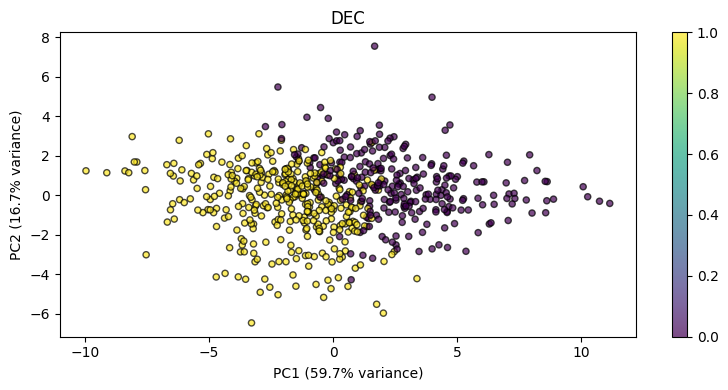

In [ ]:
from collections import Counter
# Define autoencoder dimensions
n_features = X_scaled.shape[1]
dims = [n_features, 32, 16, 8]  # Encoder dimensions
n_clusters = 2  # Number of clusters

# Initialize and train DEC
dec = DEC(dims=dims, n_clusters=n_clusters, alpha=1.0, affinity='rbf')

# Pretrain autoencoder
dec.pretrain(
    X_scaled,
    epochs=200,
    batch_size=32,
    save_dir='./results'
)

# Compile DEC model
dec.compile(optimizer='adam')

# Fit DEC model
y_pred = dec.fit(
    X_scaled.values,
    maxiter=2000,
    batch_size=32,
    tol=1e-3,
    update_interval=140,
    save_dir='./results'
)

print(Counter(y_pred))

sil = silhouette_score(X_scaled, y_pred)
sep, com, cvnn = calculate_cvnn_index(X_scaled, y_pred)
cvdd = cvdd_cal(X_scaled, y_pred)
dbcv = dbcv_cal(X_scaled, y_pred)

print("Silhouette Score:", sil)
print("SEP:", sep)
print("COM:", com)
print("CVNN:", cvnn)
print("CVDD:", cvdd)
print("DBCV:", dbcv)

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_


# Plot clustering results
plt.figure(figsize=(8, 4))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=y_pred, cmap='viridis',
                      s=20, edgecolors='k', alpha=0.7)
plt.title("DEC")
plt.xlabel(f"PC1 ({explained_variance[0]:.1%} variance)")
plt.ylabel(f"PC2 ({explained_variance[1]:.1%} variance)")
plt.colorbar(scatter)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import adjusted_rand_score

def check_stability_dec(X, dims, n_clusters=2, n_runs=10, output_dir="dec_stability_results"):
    """
    Check stability of Deep Embedded Clustering with multiple runs
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Store results
    cluster_results = []
    metrics_results = []

    for run_idx in range(n_runs):
        print(f"\nRun {run_idx + 1}/{n_runs}")

        # Set different random seeds for each run
        tf.random.set_seed(run_idx)
        np.random.seed(run_idx)

        # Initialize and train DEC
        dec = DEC(dims=dims, n_clusters=n_clusters, alpha=1.0, affinity='rbf')

        # Pretrain autoencoder
        dec.pretrain(
            X,
            epochs=200,
            batch_size=32,
            save_dir=output_dir
        )

        # Compile DEC model
        dec.compile(optimizer='adam')

        # Fit DEC model
        y_pred = dec.fit(
            X,
            maxiter=2000,
            batch_size=32,
            tol=1e-3,
            update_interval=140,
            save_dir=output_dir
        )

        cluster_results.append(y_pred)

        # Calculate metrics for this run
        sil = silhouette_score(X, y_pred)
        sep, com, cvnn = calculate_cvnn_index(X, y_pred)
        cvdd = cvdd_cal(X, y_pred)
        dbcv = dbcv_cal(X, y_pred)

        print("Silhouette Score:", sil)
        print("SEP:", sep)
        print("COM:", com)
        print("CVNN:", cvnn)
        print("CVDD:", cvdd)
        print("DBCV:", dbcv)

        # Store metrics
        metrics_results.append({
            'run': run_idx + 1,
            'silhouette': sil,
            'cluster_sizes': np.bincount(y_pred)
        })

        # Save results to CSV
        result_file = os.path.join(output_dir, f"dec_run_{run_idx + 1}.csv")
        pd.DataFrame({"Cluster_Label": y_pred}).to_csv(result_file, index=False)
        print(f"Saved clustering result for run {run_idx + 1}")

    # Calculate stability scores (ARI between all pairs of runs)
    stability_scores = []
    for i in range(n_runs):
        for j in range(i + 1, n_runs):
            ari = adjusted_rand_score(cluster_results[i], cluster_results[j])
            stability_scores.append(ari)

    # Analyze results
    mean_stability = np.mean(stability_scores)
    std_stability = np.std(stability_scores)

    # Convert metrics to DataFrame
    metrics_df = pd.DataFrame(metrics_results)

    # Visualize stability results
    # plt.figure(figsize=(15, 5))

    # # Plot 1: Stability scores distribution
    # plt.subplot(1, 2, 1)
    # plt.hist(stability_scores, bins=20)
    # plt.axvline(mean_stability, color='r', linestyle='--', label=f'Mean ARI: {mean_stability:.3f}')
    # plt.title('Distribution of ARI Scores between Runs')
    # plt.xlabel('Adjusted Rand Index')
    # plt.ylabel('Frequency')
    # plt.legend()

    # plt.tight_layout()
    # plt.show()

    # Print summary statistics
    print("\nStability Analysis Results:")
    print(f"Mean ARI: {mean_stability:.3f} ± {std_stability:.3f}")

    return {
        'stability_scores': stability_scores,
        'metrics': metrics_df,
        'cluster_results': cluster_results
    }

In [ ]:
# Run stability analysis
n_features = X_scaled.shape[1]
dims = [n_features, 32, 16, 8]

stability_results = check_stability_dec(
    X_scaled.values,
    dims=dims,
    n_clusters=2,
    n_runs=5,
    output_dir='dec_stability_results'
)


Run 1/5
Pretraining...
Epoch 1/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1:26 5s/step - loss: 32.1280 - mse: 32.1188

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 29.8236 - mse: 29.8146 - val_loss: 22.3241 - val_mse: 22.3153
Epoch 2/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 22.3667 - mse: 22.3579

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 18.7880 - mse: 18.7792 - val_loss: 7.3272 - val_mse: 7.3186
Epoch 3/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 7.1074 - mse: 7.0988

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2334 - mse: 5.2249 - val_loss: 3.1714 - val_mse: 3.1631
Epoch 4/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.8259 - mse: 2.8176

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.6131 - mse: 2.6049 - val_loss: 2.6541 - val_mse: 2.6461
Epoch 5/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.3529 - mse: 2.3448

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3466 - mse: 2.3385 - val_loss: 2.4929 - val_mse: 2.4850
Epoch 6/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.1431 - mse: 2.1352

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1380 - mse: 2.1302 - val_loss: 2.3184 - val_mse: 2.3107
Epoch 7/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 1.9647 - mse: 1.9570

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9491 - mse: 1.9415 - val_loss: 2.1016 - val_mse: 2.0940
Epoch 8/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7239 - mse: 1.7164 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7207 - mse: 1.7131 - val_loss: 1.8202 - val_mse: 1.8127
Epoch 9/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4406 - mse: 1.4331  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4385 - mse: 1.4310 - val_loss: 1.5373 - val_mse: 1.5299
Epoch 10/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 1.2504 - mse: 1.2430

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1944 - mse: 1.1870 - val_loss: 1.3305 - val_mse: 1.3232
Epoch 11/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.1095 - mse: 1.1022

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0462 - mse: 1.0388 - val_loss: 1.1844 - val_mse: 1.1772
Epoch 12/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9478 - mse: 0.9405 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9471 - mse: 0.9398 - val_loss: 1.0772 - val_mse: 1.0700
Epoch 13/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8727 - mse: 0.8655  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8711 - mse: 0.8639 - val_loss: 0.9919 - val_mse: 0.9848
Epoch 14/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8498 - mse: 0.8427

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8106 - mse: 0.8035 - val_loss: 0.9179 - val_mse: 0.9109
Epoch 15/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.7848 - mse: 0.7777

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7576 - mse: 0.7505 - val_loss: 0.8360 - val_mse: 0.8290
Epoch 16/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7146 - mse: 0.7075

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6946 - mse: 0.6876 - val_loss: 0.7457 - val_mse: 0.7387
Epoch 17/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.6385 - mse: 0.6315

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6308 - mse: 0.6238 - val_loss: 0.6647 - val_mse: 0.6577
Epoch 18/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5674 - mse: 0.5604  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5695 - mse: 0.5626 - val_loss: 0.5965 - val_mse: 0.5895
Epoch 19/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4987 - mse: 0.4918

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5184 - mse: 0.5115 - val_loss: 0.5475 - val_mse: 0.5405
Epoch 20/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4539 - mse: 0.4469

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4812 - mse: 0.4743 - val_loss: 0.5139 - val_mse: 0.5069
Epoch 21/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4527 - mse: 0.4457 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4567 - mse: 0.4497 - val_loss: 0.4914 - val_mse: 0.4844
Epoch 22/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.4108 - mse: 0.4038

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4405 - mse: 0.4335 - val_loss: 0.4748 - val_mse: 0.4679
Epoch 23/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3985 - mse: 0.3916

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4284 - mse: 0.4214 - val_loss: 0.4609 - val_mse: 0.4539
Epoch 24/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.3867 - mse: 0.3798

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4180 - mse: 0.4111 - val_loss: 0.4485 - val_mse: 0.4416
Epoch 25/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3758 - mse: 0.3689

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4085 - mse: 0.4016 - val_loss: 0.4369 - val_mse: 0.4300
Epoch 26/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3652 - mse: 0.3583

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3994 - mse: 0.3925 - val_loss: 0.4254 - val_mse: 0.4185
Epoch 27/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3546 - mse: 0.3477

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3905 - mse: 0.3835 - val_loss: 0.4137 - val_mse: 0.4068
Epoch 28/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.3440 - mse: 0.3371

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3814 - mse: 0.3745 - val_loss: 0.4020 - val_mse: 0.3951
Epoch 29/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3336 - mse: 0.3266

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3723 - mse: 0.3653 - val_loss: 0.3900 - val_mse: 0.3831
Epoch 30/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.3236 - mse: 0.3166

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3629 - mse: 0.3560 - val_loss: 0.3778 - val_mse: 0.3709
Epoch 31/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3422 - mse: 0.3353 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3535 - mse: 0.3466 - val_loss: 0.3656 - val_mse: 0.3586
Epoch 32/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3311 - mse: 0.3241 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3440 - mse: 0.3371 - val_loss: 0.3534 - val_mse: 0.3465
Epoch 33/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3283 - mse: 0.3214 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3345 - mse: 0.3275 - val_loss: 0.3415 - val_mse: 0.3345
Epoch 34/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3141 - mse: 0.3071 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3249 - mse: 0.3180 - val_loss: 0.3301 - val_mse: 0.3231
Epoch 35/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3079 - mse: 0.3010  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3155 - mse: 0.3085 - val_loss: 0.3192 - val_mse: 0.3122
Epoch 36/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2923 - mse: 0.2854  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.3063 - mse: 0.2994 - val_loss: 0.3094 - val_mse: 0.3024
Epoch 37/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2859 - mse: 0.2789  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2977 - mse: 0.2907 - val_loss: 0.3009 - val_mse: 0.2940
Epoch 38/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2560 - mse: 0.2491

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2897 - mse: 0.2827 - val_loss: 0.2937 - val_mse: 0.2867
Epoch 39/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2754 - mse: 0.2684 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2823 - mse: 0.2753 - val_loss: 0.2876 - val_mse: 0.2806
Epoch 40/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2452 - mse: 0.2382

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2755 - mse: 0.2685 - val_loss: 0.2827 - val_mse: 0.2757
Epoch 41/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2408 - mse: 0.2338

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2693 - mse: 0.2623 - val_loss: 0.2787 - val_mse: 0.2717
Epoch 42/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.2370 - mse: 0.2300

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2636 - mse: 0.2566 - val_loss: 0.2755 - val_mse: 0.2685
Epoch 43/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.2336 - mse: 0.2267

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2584 - mse: 0.2514 - val_loss: 0.2730 - val_mse: 0.2660
Epoch 44/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2306 - mse: 0.2236

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2533 - mse: 0.2463 - val_loss: 0.2698 - val_mse: 0.2628
Epoch 45/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2457 - mse: 0.2387 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2476 - mse: 0.2406 - val_loss: 0.2665 - val_mse: 0.2596
Epoch 46/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.2216 - mse: 0.2146

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2414 - mse: 0.2344 - val_loss: 0.2633 - val_mse: 0.2564
Epoch 47/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2172 - mse: 0.2102

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2349 - mse: 0.2279 - val_loss: 0.2596 - val_mse: 0.2526
Epoch 48/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2121 - mse: 0.2051

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2277 - mse: 0.2207 - val_loss: 0.2552 - val_mse: 0.2482
Epoch 49/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.2061 - mse: 0.1991

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2198 - mse: 0.2128 - val_loss: 0.2505 - val_mse: 0.2435
Epoch 50/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1996 - mse: 0.1926

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2112 - mse: 0.2042 - val_loss: 0.2453 - val_mse: 0.2383
Epoch 51/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.1934 - mse: 0.1864

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2023 - mse: 0.1953 - val_loss: 0.2398 - val_mse: 0.2327
Epoch 52/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1870 - mse: 0.1799

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1936 - mse: 0.1866 - val_loss: 0.2342 - val_mse: 0.2272
Epoch 53/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.1805 - mse: 0.1735

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1857 - mse: 0.1787 - val_loss: 0.2282 - val_mse: 0.2212
Epoch 54/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1776 - mse: 0.1705  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1780 - mse: 0.1709 - val_loss: 0.2221 - val_mse: 0.2150
Epoch 55/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1650 - mse: 0.1579

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1706 - mse: 0.1636 - val_loss: 0.2157 - val_mse: 0.2086
Epoch 56/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.1570 - mse: 0.1499

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1637 - mse: 0.1566 - val_loss: 0.2097 - val_mse: 0.2026
Epoch 57/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1550 - mse: 0.1479 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1571 - mse: 0.1500 - val_loss: 0.2038 - val_mse: 0.1967
Epoch 58/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1492 - mse: 0.1421 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1508 - mse: 0.1437 - val_loss: 0.1980 - val_mse: 0.1909
Epoch 59/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1346 - mse: 0.1275

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1450 - mse: 0.1378 - val_loss: 0.1921 - val_mse: 0.1850
Epoch 60/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.1278 - mse: 0.1207

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1395 - mse: 0.1323 - val_loss: 0.1864 - val_mse: 0.1793
Epoch 61/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1336 - mse: 0.1264 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1343 - mse: 0.1272 - val_loss: 0.1810 - val_mse: 0.1739
Epoch 62/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1156 - mse: 0.1085

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1297 - mse: 0.1225 - val_loss: 0.1758 - val_mse: 0.1687
Epoch 63/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.1106 - mse: 0.1034

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1254 - mse: 0.1183 - val_loss: 0.1709 - val_mse: 0.1638
Epoch 64/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.1060 - mse: 0.0988

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1216 - mse: 0.1145 - val_loss: 0.1664 - val_mse: 0.1592
Epoch 65/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1171 - mse: 0.1100  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1182 - mse: 0.1111 - val_loss: 0.1621 - val_mse: 0.1549
Epoch 66/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0983 - mse: 0.0912

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1152 - mse: 0.1081 - val_loss: 0.1581 - val_mse: 0.1510
Epoch 67/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0953 - mse: 0.0881

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1125 - mse: 0.1054 - val_loss: 0.1545 - val_mse: 0.1473
Epoch 68/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0926 - mse: 0.0855

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1102 - mse: 0.1030 - val_loss: 0.1512 - val_mse: 0.1440
Epoch 69/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1078 - mse: 0.1006 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1081 - mse: 0.1009 - val_loss: 0.1481 - val_mse: 0.1410
Epoch 70/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0884 - mse: 0.0813

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1062 - mse: 0.0991 - val_loss: 0.1453 - val_mse: 0.1382
Epoch 71/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0868 - mse: 0.0796

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1046 - mse: 0.0975 - val_loss: 0.1427 - val_mse: 0.1355
Epoch 72/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0853 - mse: 0.0781

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1032 - mse: 0.0960 - val_loss: 0.1401 - val_mse: 0.1330
Epoch 73/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0999 - mse: 0.0928 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1018 - mse: 0.0946 - val_loss: 0.1378 - val_mse: 0.1306
Epoch 74/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0827 - mse: 0.0755

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1006 - mse: 0.0934 - val_loss: 0.1359 - val_mse: 0.1287
Epoch 75/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0813 - mse: 0.0742

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0992 - mse: 0.0921 - val_loss: 0.1334 - val_mse: 0.1262
Epoch 76/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0953 - mse: 0.0881  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0970 - mse: 0.0899 - val_loss: 0.1302 - val_mse: 0.1231
Epoch 77/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0921 - mse: 0.0849 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0947 - mse: 0.0876 - val_loss: 0.1275 - val_mse: 0.1203
Epoch 78/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0912 - mse: 0.0841  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0926 - mse: 0.0855 - val_loss: 0.1245 - val_mse: 0.1173
Epoch 79/200
 8/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0871 - mse: 0.0800 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0905 - mse: 0.0833 - val_loss: 0.1214 - val_mse: 0.1142
Epoch 80/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0861 - mse: 0.0789  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0882 - mse: 0.0810 - val_loss: 0.1181 - val_mse: 0.1109
Epoch 81/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0837 - mse: 0.0765 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0857 - mse: 0.0785 - val_loss: 0.1146 - val_mse: 0.1074
Epoch 82/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0817 - mse: 0.0745  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0831 - mse: 0.0759 - val_loss: 0.1109 - val_mse: 0.1036
Epoch 83/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - loss: 0.0682 - mse: 0.0610

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0802 - mse: 0.0730 - val_loss: 0.1068 - val_mse: 0.0995
Epoch 84/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0765 - mse: 0.0692  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0770 - mse: 0.0697 - val_loss: 0.1022 - val_mse: 0.0950
Epoch 85/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0632 - mse: 0.0560

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0734 - mse: 0.0662 - val_loss: 0.0973 - val_mse: 0.0901
Epoch 86/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0693 - mse: 0.0620  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0696 - mse: 0.0623 - val_loss: 0.0922 - val_mse: 0.0849
Epoch 87/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0572 - mse: 0.0500

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0655 - mse: 0.0582 - val_loss: 0.0867 - val_mse: 0.0794
Epoch 88/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0540 - mse: 0.0467

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0612 - mse: 0.0539 - val_loss: 0.0810 - val_mse: 0.0737
Epoch 89/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0568 - mse: 0.0495  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0570 - mse: 0.0497 - val_loss: 0.0754 - val_mse: 0.0680
Epoch 90/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0526 - mse: 0.0453 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0528 - mse: 0.0454 - val_loss: 0.0699 - val_mse: 0.0626
Epoch 91/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0446 - mse: 0.0373

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0487 - mse: 0.0414 - val_loss: 0.0648 - val_mse: 0.0574
Epoch 92/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0418 - mse: 0.0344

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0451 - mse: 0.0378 - val_loss: 0.0603 - val_mse: 0.0529
Epoch 93/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0419 - mse: 0.0345  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0420 - mse: 0.0346 - val_loss: 0.0564 - val_mse: 0.0490
Epoch 94/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0394 - mse: 0.0320 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0394 - mse: 0.0320 - val_loss: 0.0533 - val_mse: 0.0459
Epoch 95/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0353 - mse: 0.0279

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0373 - mse: 0.0298 - val_loss: 0.0508 - val_mse: 0.0434
Epoch 96/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0341 - mse: 0.0266

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0355 - mse: 0.0281 - val_loss: 0.0489 - val_mse: 0.0415
Epoch 97/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0331 - mse: 0.0257

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0341 - mse: 0.0267 - val_loss: 0.0475 - val_mse: 0.0400
Epoch 98/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0325 - mse: 0.0250

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0330 - mse: 0.0256 - val_loss: 0.0462 - val_mse: 0.0388
Epoch 99/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0321 - mse: 0.0247  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0321 - mse: 0.0247 - val_loss: 0.0451 - val_mse: 0.0377
Epoch 100/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0314 - mse: 0.0240 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0314 - mse: 0.0239 - val_loss: 0.0442 - val_mse: 0.0367
Epoch 101/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0313 - mse: 0.0238

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0308 - mse: 0.0234 - val_loss: 0.0433 - val_mse: 0.0359
Epoch 102/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0310 - mse: 0.0235

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0303 - mse: 0.0229 - val_loss: 0.0425 - val_mse: 0.0351
Epoch 103/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0307 - mse: 0.0233

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0299 - mse: 0.0225 - val_loss: 0.0418 - val_mse: 0.0344
Epoch 104/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0297 - mse: 0.0223 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0296 - mse: 0.0221 - val_loss: 0.0411 - val_mse: 0.0337
Epoch 105/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0293 - mse: 0.0219 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0293 - mse: 0.0219 - val_loss: 0.0404 - val_mse: 0.0330
Epoch 106/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0300 - mse: 0.0226

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0290 - mse: 0.0216 - val_loss: 0.0398 - val_mse: 0.0324
Epoch 107/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0299 - mse: 0.0224

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0288 - mse: 0.0214 - val_loss: 0.0393 - val_mse: 0.0319
Epoch 108/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0297 - mse: 0.0223

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0286 - mse: 0.0211 - val_loss: 0.0388 - val_mse: 0.0314
Epoch 109/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0295 - mse: 0.0221

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0283 - mse: 0.0209 - val_loss: 0.0384 - val_mse: 0.0309
Epoch 110/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0294 - mse: 0.0220

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0282 - mse: 0.0207 - val_loss: 0.0379 - val_mse: 0.0305
Epoch 111/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0292 - mse: 0.0218

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0280 - mse: 0.0206 - val_loss: 0.0375 - val_mse: 0.0301
Epoch 112/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0291 - mse: 0.0217

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0278 - mse: 0.0204 - val_loss: 0.0372 - val_mse: 0.0298
Epoch 113/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0278 - mse: 0.0204 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0277 - mse: 0.0203 - val_loss: 0.0368 - val_mse: 0.0294
Epoch 114/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0275 - mse: 0.0201 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0275 - mse: 0.0201 - val_loss: 0.0365 - val_mse: 0.0291
Epoch 115/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0288 - mse: 0.0214

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0274 - mse: 0.0200 - val_loss: 0.0362 - val_mse: 0.0288
Epoch 116/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0273 - mse: 0.0199 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0272 - mse: 0.0199 - val_loss: 0.0359 - val_mse: 0.0285
Epoch 117/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0274 - mse: 0.0200  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0271 - mse: 0.0197 - val_loss: 0.0356 - val_mse: 0.0282
Epoch 118/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0285 - mse: 0.0211

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0270 - mse: 0.0196 - val_loss: 0.0353 - val_mse: 0.0279
Epoch 119/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0284 - mse: 0.0210

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0269 - mse: 0.0195 - val_loss: 0.0350 - val_mse: 0.0277
Epoch 120/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0270 - mse: 0.0196 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0268 - mse: 0.0194 - val_loss: 0.0348 - val_mse: 0.0274
Epoch 121/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0269 - mse: 0.0196  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0267 - mse: 0.0193 - val_loss: 0.0346 - val_mse: 0.0272
Epoch 122/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0268 - mse: 0.0194 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0266 - mse: 0.0192 - val_loss: 0.0343 - val_mse: 0.0270
Epoch 123/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0267 - mse: 0.0194  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0265 - mse: 0.0191 - val_loss: 0.0341 - val_mse: 0.0267
Epoch 124/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0266 - mse: 0.0193  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0264 - mse: 0.0190 - val_loss: 0.0339 - val_mse: 0.0265
Epoch 125/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0266 - mse: 0.0192  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0263 - mse: 0.0189 - val_loss: 0.0337 - val_mse: 0.0263
Epoch 126/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0280 - mse: 0.0206

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0262 - mse: 0.0188 - val_loss: 0.0335 - val_mse: 0.0261
Epoch 127/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.0279 - mse: 0.0206

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0261 - mse: 0.0188 - val_loss: 0.0333 - val_mse: 0.0259
Epoch 128/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0279 - mse: 0.0205

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0260 - mse: 0.0187 - val_loss: 0.0330 - val_mse: 0.0257
Epoch 129/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0278 - mse: 0.0204

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0259 - mse: 0.0186 - val_loss: 0.0328 - val_mse: 0.0255
Epoch 130/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0277 - mse: 0.0204

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0259 - mse: 0.0185 - val_loss: 0.0326 - val_mse: 0.0253
Epoch 131/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0259 - mse: 0.0185 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0258 - mse: 0.0184 - val_loss: 0.0324 - val_mse: 0.0251
Epoch 132/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0276 - mse: 0.0203

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0257 - mse: 0.0184 - val_loss: 0.0323 - val_mse: 0.0249
Epoch 133/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0276 - mse: 0.0202

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0256 - mse: 0.0183 - val_loss: 0.0321 - val_mse: 0.0247
Epoch 134/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0275 - mse: 0.0202

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0256 - mse: 0.0182 - val_loss: 0.0319 - val_mse: 0.0246
Epoch 135/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0274 - mse: 0.0201

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0255 - mse: 0.0182 - val_loss: 0.0317 - val_mse: 0.0244
Epoch 136/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0255 - mse: 0.0182 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0254 - mse: 0.0181 - val_loss: 0.0315 - val_mse: 0.0242
Epoch 137/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254 - mse: 0.0181 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0254 - mse: 0.0180 - val_loss: 0.0314 - val_mse: 0.0241
Epoch 138/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0253 - mse: 0.0180 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0253 - mse: 0.0180 - val_loss: 0.0312 - val_mse: 0.0239
Epoch 139/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254 - mse: 0.0180 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0252 - mse: 0.0179 - val_loss: 0.0311 - val_mse: 0.0238
Epoch 140/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0254 - mse: 0.0181  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0252 - mse: 0.0179 - val_loss: 0.0309 - val_mse: 0.0236
Epoch 141/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0272 - mse: 0.0199

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0251 - mse: 0.0178 - val_loss: 0.0308 - val_mse: 0.0235
Epoch 142/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0271 - mse: 0.0198

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0251 - mse: 0.0178 - val_loss: 0.0307 - val_mse: 0.0234
Epoch 143/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0271 - mse: 0.0198

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0250 - mse: 0.0177 - val_loss: 0.0305 - val_mse: 0.0232
Epoch 144/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.0271 - mse: 0.0198

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0250 - mse: 0.0177 - val_loss: 0.0304 - val_mse: 0.0231
Epoch 145/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0270 - mse: 0.0197

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0249 - mse: 0.0176 - val_loss: 0.0303 - val_mse: 0.0230
Epoch 146/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0270 - mse: 0.0197

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0249 - mse: 0.0176 - val_loss: 0.0302 - val_mse: 0.0229
Epoch 147/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0270 - mse: 0.0197

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0248 - mse: 0.0176 - val_loss: 0.0301 - val_mse: 0.0228
Epoch 148/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0249 - mse: 0.0176 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0248 - mse: 0.0175 - val_loss: 0.0300 - val_mse: 0.0227
Epoch 149/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0269 - mse: 0.0196

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0248 - mse: 0.0175 - val_loss: 0.0299 - val_mse: 0.0226
Epoch 150/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0269 - mse: 0.0196

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0247 - mse: 0.0174 - val_loss: 0.0298 - val_mse: 0.0225
Epoch 151/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0269 - mse: 0.0196

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0247 - mse: 0.0174 - val_loss: 0.0297 - val_mse: 0.0224
Epoch 152/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0268 - mse: 0.0196

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0246 - mse: 0.0174 - val_loss: 0.0296 - val_mse: 0.0223
Epoch 153/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0268 - mse: 0.0196

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0246 - mse: 0.0173 - val_loss: 0.0295 - val_mse: 0.0222
Epoch 154/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0268 - mse: 0.0195

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0246 - mse: 0.0173 - val_loss: 0.0294 - val_mse: 0.0221
Epoch 155/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0268 - mse: 0.0195

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0245 - mse: 0.0173 - val_loss: 0.0293 - val_mse: 0.0220
Epoch 156/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0268 - mse: 0.0195

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0245 - mse: 0.0172 - val_loss: 0.0292 - val_mse: 0.0220
Epoch 157/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245 - mse: 0.0172  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0245 - mse: 0.0172 - val_loss: 0.0291 - val_mse: 0.0219
Epoch 158/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0268 - mse: 0.0195

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0244 - mse: 0.0172 - val_loss: 0.0290 - val_mse: 0.0218
Epoch 159/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0244 - mse: 0.0172  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0244 - mse: 0.0171 - val_loss: 0.0289 - val_mse: 0.0217
Epoch 160/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0267 - mse: 0.0195

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0244 - mse: 0.0171 - val_loss: 0.0289 - val_mse: 0.0216
Epoch 161/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245 - mse: 0.0172 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0243 - mse: 0.0171 - val_loss: 0.0288 - val_mse: 0.0215
Epoch 162/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0267 - mse: 0.0195

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0243 - mse: 0.0171 - val_loss: 0.0287 - val_mse: 0.0215
Epoch 163/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0246 - mse: 0.0174 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0243 - mse: 0.0170 - val_loss: 0.0286 - val_mse: 0.0214
Epoch 164/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0246 - mse: 0.0173  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0243 - mse: 0.0170 - val_loss: 0.0285 - val_mse: 0.0213
Epoch 165/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0245 - mse: 0.0173  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0242 - mse: 0.0170 - val_loss: 0.0285 - val_mse: 0.0212
Epoch 166/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0245 - mse: 0.0172 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0242 - mse: 0.0170 - val_loss: 0.0284 - val_mse: 0.0212
Epoch 167/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0246 - mse: 0.0174  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0242 - mse: 0.0170 - val_loss: 0.0283 - val_mse: 0.0211
Epoch 168/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0242 - mse: 0.0170

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0242 - mse: 0.0169 - val_loss: 0.0282 - val_mse: 0.0210
Epoch 169/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0245 - mse: 0.0173 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0241 - mse: 0.0169 - val_loss: 0.0282 - val_mse: 0.0210
Epoch 170/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0245 - mse: 0.0173  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0241 - mse: 0.0169 - val_loss: 0.0281 - val_mse: 0.0209
Epoch 171/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241 - mse: 0.0169 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0241 - mse: 0.0169 - val_loss: 0.0280 - val_mse: 0.0208
Epoch 172/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242 - mse: 0.0170 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0241 - mse: 0.0169 - val_loss: 0.0280 - val_mse: 0.0208
Epoch 173/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0266 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0240 - mse: 0.0168 - val_loss: 0.0279 - val_mse: 0.0207
Epoch 174/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0266 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0240 - mse: 0.0168 - val_loss: 0.0279 - val_mse: 0.0207
Epoch 175/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0266 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0240 - mse: 0.0168 - val_loss: 0.0278 - val_mse: 0.0206
Epoch 176/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0266 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0240 - mse: 0.0168 - val_loss: 0.0277 - val_mse: 0.0206
Epoch 177/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243 - mse: 0.0171  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0240 - mse: 0.0168 - val_loss: 0.0277 - val_mse: 0.0205
Epoch 178/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0266 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0240 - mse: 0.0168 - val_loss: 0.0276 - val_mse: 0.0205
Epoch 179/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241 - mse: 0.0169 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0239 - mse: 0.0168 - val_loss: 0.0276 - val_mse: 0.0204
Epoch 180/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0266 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0239 - mse: 0.0168 - val_loss: 0.0275 - val_mse: 0.0204
Epoch 181/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0266 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0239 - mse: 0.0167 - val_loss: 0.0275 - val_mse: 0.0203
Epoch 182/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0266 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0239 - mse: 0.0167 - val_loss: 0.0275 - val_mse: 0.0203
Epoch 183/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0266 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0239 - mse: 0.0167 - val_loss: 0.0274 - val_mse: 0.0202
Epoch 184/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0266 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0239 - mse: 0.0167 - val_loss: 0.0274 - val_mse: 0.0202
Epoch 185/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0266 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0239 - mse: 0.0167 - val_loss: 0.0273 - val_mse: 0.0202
Epoch 186/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0239 - mse: 0.0167 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0238 - mse: 0.0167 - val_loss: 0.0273 - val_mse: 0.0201
Epoch 187/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0266 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0238 - mse: 0.0167 - val_loss: 0.0272 - val_mse: 0.0201
Epoch 188/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0265 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0238 - mse: 0.0167 - val_loss: 0.0272 - val_mse: 0.0201
Epoch 189/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - mse: 0.0169 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0238 - mse: 0.0167 - val_loss: 0.0272 - val_mse: 0.0200
Epoch 190/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - mse: 0.0169 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0238 - mse: 0.0166 - val_loss: 0.0271 - val_mse: 0.0200
Epoch 191/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0265 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0238 - mse: 0.0166 - val_loss: 0.0271 - val_mse: 0.0199
Epoch 192/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0239 - mse: 0.0168  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0238 - mse: 0.0166 - val_loss: 0.0271 - val_mse: 0.0199
Epoch 193/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0265 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0237 - mse: 0.0166 - val_loss: 0.0270 - val_mse: 0.0199
Epoch 194/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238 - mse: 0.0167 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0237 - mse: 0.0166 - val_loss: 0.0270 - val_mse: 0.0199
Epoch 195/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.0265 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0237 - mse: 0.0166 - val_loss: 0.0269 - val_mse: 0.0198
Epoch 196/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.0265 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0237 - mse: 0.0166 - val_loss: 0.0269 - val_mse: 0.0198
Epoch 197/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238 - mse: 0.0167 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0237 - mse: 0.0166 - val_loss: 0.0269 - val_mse: 0.0198
Epoch 198/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0265 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0237 - mse: 0.0166 - val_loss: 0.0268 - val_mse: 0.0197
Epoch 199/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0265 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0237 - mse: 0.0166 - val_loss: 0.0268 - val_mse: 0.0197
Epoch 200/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0265 - mse: 0.0194

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0237 - mse: 0.0166 - val_loss: 0.0268 - val_mse: 0.0197
Training DEC...
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Initializing cluster centers with Spectral Clustering...
Silhouette Score: 0.29300358499528234
SEP: 0.11286764705882361
COM: 9.209955684618958
CVNN: 4.661411665838891
CVDD: 40.598332934275945
DBCV: -0.8528540154151117
Saved clustering result for run 1

Run 2/5
Pretraining...
Epoch 1/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 24.9579 - mse: 24.9489

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 21.1260 - mse: 21.1171 - val_loss: 9.8758 - val_mse: 9.8671
Epoch 2/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 6s 376ms/step - loss: 8.2939 - mse: 8.2852

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.6854 - mse: 6.6767 - val_loss: 2.2634 - val_mse: 2.2549
Epoch 3/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9532 - mse: 1.9447  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.8727 - mse: 1.8642 - val_loss: 1.5814 - val_mse: 1.5731
Epoch 4/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3587 - mse: 1.3505  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.3266 - mse: 1.3184 - val_loss: 1.2027 - val_mse: 1.1946
Epoch 5/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0869 - mse: 1.0789 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0626 - mse: 1.0546 - val_loss: 0.9983 - val_mse: 0.9904
Epoch 6/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9107 - mse: 0.9028 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8949 - mse: 0.8870 - val_loss: 0.8686 - val_mse: 0.8609
Epoch 7/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7977 - mse: 0.7900 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7828 - mse: 0.7751 - val_loss: 0.7588 - val_mse: 0.7511
Epoch 8/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7006 - mse: 0.6930  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6919 - mse: 0.6843 - val_loss: 0.6696 - val_mse: 0.6621
Epoch 9/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6238 - mse: 0.6163  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6149 - mse: 0.6075 - val_loss: 0.5936 - val_mse: 0.5862
Epoch 10/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 6s 354ms/step - loss: 0.5687 - mse: 0.5613

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5501 - mse: 0.5427 - val_loss: 0.5350 - val_mse: 0.5277
Epoch 11/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5036 - mse: 0.4963 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5003 - mse: 0.4930 - val_loss: 0.4928 - val_mse: 0.4855
Epoch 12/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5032 - mse: 0.4960

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4650 - mse: 0.4578 - val_loss: 0.4592 - val_mse: 0.4519
Epoch 13/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4373 - mse: 0.4301 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4366 - mse: 0.4294 - val_loss: 0.4386 - val_mse: 0.4314
Epoch 14/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.4625 - mse: 0.4553

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4218 - mse: 0.4146 - val_loss: 0.4294 - val_mse: 0.4222
Epoch 15/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.4523 - mse: 0.4451

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4126 - mse: 0.4054 - val_loss: 0.4222 - val_mse: 0.4151
Epoch 16/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4054 - mse: 0.3983

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.4051 - mse: 0.3980 - val_loss: 0.4152 - val_mse: 0.4081
Epoch 17/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3981 - mse: 0.3910 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3979 - mse: 0.3908 - val_loss: 0.4081 - val_mse: 0.4010
Epoch 18/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3914 - mse: 0.3844 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3905 - mse: 0.3835 - val_loss: 0.3994 - val_mse: 0.3924
Epoch 19/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3819 - mse: 0.3749

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3814 - mse: 0.3744 - val_loss: 0.3900 - val_mse: 0.3830
Epoch 20/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3729 - mse: 0.3658  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.3704 - mse: 0.3634 - val_loss: 0.3792 - val_mse: 0.3722
Epoch 21/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3587 - mse: 0.3516

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3580 - mse: 0.3510 - val_loss: 0.3669 - val_mse: 0.3598
Epoch 22/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3441 - mse: 0.3370

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3438 - mse: 0.3368 - val_loss: 0.3529 - val_mse: 0.3459
Epoch 23/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - loss: 0.3603 - mse: 0.3533

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3274 - mse: 0.3204 - val_loss: 0.3372 - val_mse: 0.3302
Epoch 24/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3091 - mse: 0.3020 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3088 - mse: 0.3018 - val_loss: 0.3201 - val_mse: 0.3130
Epoch 25/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.3164 - mse: 0.3093

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2883 - mse: 0.2813 - val_loss: 0.3017 - val_mse: 0.2947
Epoch 26/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2677 - mse: 0.2606 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2666 - mse: 0.2596 - val_loss: 0.2838 - val_mse: 0.2768
Epoch 27/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2444 - mse: 0.2373 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2438 - mse: 0.2367 - val_loss: 0.2661 - val_mse: 0.2590
Epoch 28/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2217 - mse: 0.2146 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2208 - mse: 0.2136 - val_loss: 0.2487 - val_mse: 0.2416
Epoch 29/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2148 - mse: 0.2077

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1990 - mse: 0.1919 - val_loss: 0.2340 - val_mse: 0.2268
Epoch 30/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1822 - mse: 0.1751 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1815 - mse: 0.1744 - val_loss: 0.2240 - val_mse: 0.2168
Epoch 31/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.1768 - mse: 0.1696

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1695 - mse: 0.1623 - val_loss: 0.2171 - val_mse: 0.2099
Epoch 32/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1615 - mse: 0.1543 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1613 - mse: 0.1541 - val_loss: 0.2115 - val_mse: 0.2043
Epoch 33/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1553 - mse: 0.1481 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1550 - mse: 0.1478 - val_loss: 0.2059 - val_mse: 0.1987
Epoch 34/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1498 - mse: 0.1426 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1495 - mse: 0.1423 - val_loss: 0.2000 - val_mse: 0.1928
Epoch 35/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.1463 - mse: 0.1391

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1441 - mse: 0.1369 - val_loss: 0.1934 - val_mse: 0.1862
Epoch 36/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.1400 - mse: 0.1328

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1386 - mse: 0.1314 - val_loss: 0.1865 - val_mse: 0.1793
Epoch 37/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1332 - mse: 0.1260 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1330 - mse: 0.1258 - val_loss: 0.1783 - val_mse: 0.1710
Epoch 38/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1268 - mse: 0.1195 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1266 - mse: 0.1193 - val_loss: 0.1677 - val_mse: 0.1604
Epoch 39/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1198 - mse: 0.1126  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1189 - mse: 0.1116 - val_loss: 0.1553 - val_mse: 0.1480
Epoch 40/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1111 - mse: 0.1039 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1102 - mse: 0.1029 - val_loss: 0.1416 - val_mse: 0.1343
Epoch 41/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1025 - mse: 0.0952  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1010 - mse: 0.0937 - val_loss: 0.1272 - val_mse: 0.1199
Epoch 42/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0934 - mse: 0.0861 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0917 - mse: 0.0844 - val_loss: 0.1128 - val_mse: 0.1055
Epoch 43/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0840 - mse: 0.0766  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0824 - mse: 0.0751 - val_loss: 0.0973 - val_mse: 0.0899
Epoch 44/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0746 - mse: 0.0672 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0726 - mse: 0.0653 - val_loss: 0.0837 - val_mse: 0.0763
Epoch 45/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0660 - mse: 0.0586  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0648 - mse: 0.0574 - val_loss: 0.0731 - val_mse: 0.0657
Epoch 46/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0570 - mse: 0.0495

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0587 - mse: 0.0513 - val_loss: 0.0652 - val_mse: 0.0577
Epoch 47/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0514 - mse: 0.0439

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0539 - mse: 0.0464 - val_loss: 0.0593 - val_mse: 0.0518
Epoch 48/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0468 - mse: 0.0394

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0500 - mse: 0.0426 - val_loss: 0.0548 - val_mse: 0.0473
Epoch 49/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0431 - mse: 0.0357

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0469 - mse: 0.0395 - val_loss: 0.0512 - val_mse: 0.0438
Epoch 50/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0400 - mse: 0.0326

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0443 - mse: 0.0369 - val_loss: 0.0483 - val_mse: 0.0408
Epoch 51/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0374 - mse: 0.0299

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0421 - mse: 0.0346 - val_loss: 0.0459 - val_mse: 0.0384
Epoch 52/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0352 - mse: 0.0277

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0401 - mse: 0.0327 - val_loss: 0.0438 - val_mse: 0.0363
Epoch 53/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0387 - mse: 0.0312 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0384 - mse: 0.0310 - val_loss: 0.0419 - val_mse: 0.0344
Epoch 54/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0315 - mse: 0.0240

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0369 - mse: 0.0294 - val_loss: 0.0403 - val_mse: 0.0328
Epoch 55/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0356 - mse: 0.0281 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0356 - mse: 0.0281 - val_loss: 0.0388 - val_mse: 0.0314
Epoch 56/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0288 - mse: 0.0213

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0344 - mse: 0.0269 - val_loss: 0.0376 - val_mse: 0.0301
Epoch 57/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0333 - mse: 0.0258 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0333 - mse: 0.0258 - val_loss: 0.0365 - val_mse: 0.0290
Epoch 58/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0267 - mse: 0.0193

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0324 - mse: 0.0249 - val_loss: 0.0355 - val_mse: 0.0280
Epoch 59/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0315 - mse: 0.0240 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0315 - mse: 0.0240 - val_loss: 0.0346 - val_mse: 0.0271
Epoch 60/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0252 - mse: 0.0177

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0307 - mse: 0.0232 - val_loss: 0.0338 - val_mse: 0.0263
Epoch 61/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.0245 - mse: 0.0170

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0301 - mse: 0.0226 - val_loss: 0.0331 - val_mse: 0.0256
Epoch 62/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0239 - mse: 0.0164

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0295 - mse: 0.0220 - val_loss: 0.0324 - val_mse: 0.0250
Epoch 63/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0289 - mse: 0.0214 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0289 - mse: 0.0214 - val_loss: 0.0319 - val_mse: 0.0244
Epoch 64/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0230 - mse: 0.0155

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0284 - mse: 0.0209 - val_loss: 0.0314 - val_mse: 0.0239
Epoch 65/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0277 - mse: 0.0202 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0279 - mse: 0.0205 - val_loss: 0.0309 - val_mse: 0.0235
Epoch 66/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0222 - mse: 0.0148

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0275 - mse: 0.0200 - val_loss: 0.0305 - val_mse: 0.0231
Epoch 67/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0270 - mse: 0.0195  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0271 - mse: 0.0197 - val_loss: 0.0302 - val_mse: 0.0227
Epoch 68/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0217 - mse: 0.0142

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0268 - mse: 0.0193 - val_loss: 0.0299 - val_mse: 0.0224
Epoch 69/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0214 - mse: 0.0139

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0265 - mse: 0.0190 - val_loss: 0.0296 - val_mse: 0.0221
Epoch 70/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0212 - mse: 0.0137

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0262 - mse: 0.0187 - val_loss: 0.0293 - val_mse: 0.0218
Epoch 71/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0259 - mse: 0.0184  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0259 - mse: 0.0185 - val_loss: 0.0291 - val_mse: 0.0216
Epoch 72/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0254 - mse: 0.0179 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0257 - mse: 0.0182 - val_loss: 0.0288 - val_mse: 0.0214
Epoch 73/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0207 - mse: 0.0132

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0254 - mse: 0.0180 - val_loss: 0.0287 - val_mse: 0.0212
Epoch 74/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0251 - mse: 0.0176 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0252 - mse: 0.0177 - val_loss: 0.0285 - val_mse: 0.0211
Epoch 75/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0247 - mse: 0.0172 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0250 - mse: 0.0176 - val_loss: 0.0284 - val_mse: 0.0209
Epoch 76/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0245 - mse: 0.0171  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0248 - mse: 0.0174 - val_loss: 0.0283 - val_mse: 0.0208
Epoch 77/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0203 - mse: 0.0128

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0247 - mse: 0.0172 - val_loss: 0.0282 - val_mse: 0.0207
Epoch 78/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0202 - mse: 0.0128

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0245 - mse: 0.0170 - val_loss: 0.0280 - val_mse: 0.0206
Epoch 79/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242 - mse: 0.0168  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0243 - mse: 0.0169 - val_loss: 0.0279 - val_mse: 0.0205
Epoch 80/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242 - mse: 0.0167 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0242 - mse: 0.0167 - val_loss: 0.0278 - val_mse: 0.0203
Epoch 81/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.0201 - mse: 0.0126

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0241 - mse: 0.0166 - val_loss: 0.0277 - val_mse: 0.0202
Epoch 82/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0235 - mse: 0.0160  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0239 - mse: 0.0165 - val_loss: 0.0275 - val_mse: 0.0201
Epoch 83/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0235 - mse: 0.0161  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0238 - mse: 0.0164 - val_loss: 0.0274 - val_mse: 0.0199
Epoch 84/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0233 - mse: 0.0159  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0237 - mse: 0.0162 - val_loss: 0.0272 - val_mse: 0.0198
Epoch 85/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0232 - mse: 0.0158  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0236 - mse: 0.0161 - val_loss: 0.0271 - val_mse: 0.0196
Epoch 86/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0229 - mse: 0.0154 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0234 - mse: 0.0160 - val_loss: 0.0269 - val_mse: 0.0195
Epoch 87/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0228 - mse: 0.0154 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0233 - mse: 0.0159 - val_loss: 0.0268 - val_mse: 0.0193
Epoch 88/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0228 - mse: 0.0153 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0232 - mse: 0.0158 - val_loss: 0.0266 - val_mse: 0.0192
Epoch 89/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - loss: 0.0194 - mse: 0.0120

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0231 - mse: 0.0157 - val_loss: 0.0265 - val_mse: 0.0191
Epoch 90/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0193 - mse: 0.0119

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0230 - mse: 0.0156 - val_loss: 0.0264 - val_mse: 0.0190
Epoch 91/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0223 - mse: 0.0149  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0229 - mse: 0.0155 - val_loss: 0.0263 - val_mse: 0.0189
Epoch 92/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0192 - mse: 0.0118

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0228 - mse: 0.0154 - val_loss: 0.0262 - val_mse: 0.0187
Epoch 93/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0191 - mse: 0.0117

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0227 - mse: 0.0153 - val_loss: 0.0261 - val_mse: 0.0186
Epoch 94/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0224 - mse: 0.0150 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0227 - mse: 0.0152 - val_loss: 0.0260 - val_mse: 0.0185
Epoch 95/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0225 - mse: 0.0151 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0226 - mse: 0.0152 - val_loss: 0.0259 - val_mse: 0.0184
Epoch 96/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0190 - mse: 0.0116

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0225 - mse: 0.0151 - val_loss: 0.0258 - val_mse: 0.0184
Epoch 97/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0189 - mse: 0.0115

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0225 - mse: 0.0150 - val_loss: 0.0257 - val_mse: 0.0183
Epoch 98/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0189 - mse: 0.0115

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0224 - mse: 0.0150 - val_loss: 0.0256 - val_mse: 0.0182
Epoch 99/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0189 - mse: 0.0114

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0223 - mse: 0.0149 - val_loss: 0.0255 - val_mse: 0.0181
Epoch 100/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.0188 - mse: 0.0114

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0223 - mse: 0.0148 - val_loss: 0.0254 - val_mse: 0.0180
Epoch 101/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0188 - mse: 0.0114

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0222 - mse: 0.0148 - val_loss: 0.0254 - val_mse: 0.0179
Epoch 102/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0218 - mse: 0.0143  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0222 - mse: 0.0147 - val_loss: 0.0253 - val_mse: 0.0179
Epoch 103/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0187 - mse: 0.0113

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0221 - mse: 0.0147 - val_loss: 0.0252 - val_mse: 0.0178
Epoch 104/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0219 - mse: 0.0145 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0221 - mse: 0.0146 - val_loss: 0.0251 - val_mse: 0.0177
Epoch 105/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0214 - mse: 0.0140 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0220 - mse: 0.0146 - val_loss: 0.0251 - val_mse: 0.0177
Epoch 106/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0219 - mse: 0.0145 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0220 - mse: 0.0145 - val_loss: 0.0250 - val_mse: 0.0176
Epoch 107/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0186 - mse: 0.0112

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0219 - mse: 0.0145 - val_loss: 0.0250 - val_mse: 0.0175
Epoch 108/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0186 - mse: 0.0111

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0219 - mse: 0.0145 - val_loss: 0.0249 - val_mse: 0.0175
Epoch 109/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0185 - mse: 0.0111

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0218 - mse: 0.0144 - val_loss: 0.0248 - val_mse: 0.0174
Epoch 110/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 - mse: 0.0142 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0218 - mse: 0.0144 - val_loss: 0.0248 - val_mse: 0.0174
Epoch 111/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0185 - mse: 0.0111

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0217 - mse: 0.0143 - val_loss: 0.0247 - val_mse: 0.0173
Epoch 112/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0185 - mse: 0.0110

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0217 - mse: 0.0143 - val_loss: 0.0247 - val_mse: 0.0173
Epoch 113/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215 - mse: 0.0141 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0216 - mse: 0.0142 - val_loss: 0.0246 - val_mse: 0.0172
Epoch 114/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0213 - mse: 0.0139 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0216 - mse: 0.0142 - val_loss: 0.0246 - val_mse: 0.0172
Epoch 115/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0214 - mse: 0.0140 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0216 - mse: 0.0142 - val_loss: 0.0245 - val_mse: 0.0171
Epoch 116/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0184 - mse: 0.0110

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0215 - mse: 0.0141 - val_loss: 0.0245 - val_mse: 0.0171
Epoch 117/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0211 - mse: 0.0137  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0215 - mse: 0.0141 - val_loss: 0.0244 - val_mse: 0.0170
Epoch 118/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 - mse: 0.0139 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0214 - mse: 0.0140 - val_loss: 0.0244 - val_mse: 0.0170
Epoch 119/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0183 - mse: 0.0109

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0214 - mse: 0.0140 - val_loss: 0.0243 - val_mse: 0.0169
Epoch 120/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 - mse: 0.0139 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0214 - mse: 0.0140 - val_loss: 0.0243 - val_mse: 0.0169
Epoch 121/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210 - mse: 0.0136  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0213 - mse: 0.0139 - val_loss: 0.0242 - val_mse: 0.0168
Epoch 122/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0182 - mse: 0.0108

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0213 - mse: 0.0139 - val_loss: 0.0242 - val_mse: 0.0168
Epoch 123/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212 - mse: 0.0138 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0212 - mse: 0.0138 - val_loss: 0.0241 - val_mse: 0.0167
Epoch 124/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0181 - mse: 0.0108

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0212 - mse: 0.0138 - val_loss: 0.0241 - val_mse: 0.0167
Epoch 125/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0208 - mse: 0.0134 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0212 - mse: 0.0138 - val_loss: 0.0240 - val_mse: 0.0166
Epoch 126/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0208 - mse: 0.0134 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0211 - mse: 0.0137 - val_loss: 0.0240 - val_mse: 0.0166
Epoch 127/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0205 - mse: 0.0131 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0211 - mse: 0.0137 - val_loss: 0.0239 - val_mse: 0.0166
Epoch 128/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0205 - mse: 0.0131  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0210 - mse: 0.0137 - val_loss: 0.0239 - val_mse: 0.0165
Epoch 129/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0204 - mse: 0.0130  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0210 - mse: 0.0136 - val_loss: 0.0238 - val_mse: 0.0165
Epoch 130/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0204 - mse: 0.0131  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0209 - mse: 0.0136 - val_loss: 0.0238 - val_mse: 0.0164
Epoch 131/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0203 - mse: 0.0129  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0209 - mse: 0.0135 - val_loss: 0.0237 - val_mse: 0.0164
Epoch 132/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0179 - mse: 0.0105

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0209 - mse: 0.0135 - val_loss: 0.0237 - val_mse: 0.0163
Epoch 133/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0179 - mse: 0.0105

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0208 - mse: 0.0134 - val_loss: 0.0236 - val_mse: 0.0163
Epoch 134/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 - mse: 0.0131 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0208 - mse: 0.0134 - val_loss: 0.0236 - val_mse: 0.0162
Epoch 135/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0178 - mse: 0.0105

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0207 - mse: 0.0133 - val_loss: 0.0235 - val_mse: 0.0161
Epoch 136/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0178 - mse: 0.0104

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0207 - mse: 0.0133 - val_loss: 0.0235 - val_mse: 0.0161
Epoch 137/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.0178 - mse: 0.0104

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0206 - mse: 0.0132 - val_loss: 0.0234 - val_mse: 0.0160
Epoch 138/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0177 - mse: 0.0104

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0206 - mse: 0.0132 - val_loss: 0.0234 - val_mse: 0.0160
Epoch 139/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0177 - mse: 0.0103

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0205 - mse: 0.0131 - val_loss: 0.0233 - val_mse: 0.0159
Epoch 140/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204 - mse: 0.0130 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0205 - mse: 0.0131 - val_loss: 0.0232 - val_mse: 0.0159
Epoch 141/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203 - mse: 0.0129 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0204 - mse: 0.0130 - val_loss: 0.0232 - val_mse: 0.0158
Epoch 142/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202 - mse: 0.0129 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0203 - mse: 0.0130 - val_loss: 0.0231 - val_mse: 0.0157
Epoch 143/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0200 - mse: 0.0127  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0203 - mse: 0.0129 - val_loss: 0.0230 - val_mse: 0.0157
Epoch 144/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0175 - mse: 0.0101

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0202 - mse: 0.0129 - val_loss: 0.0230 - val_mse: 0.0156
Epoch 145/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0199 - mse: 0.0125 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0202 - mse: 0.0128 - val_loss: 0.0229 - val_mse: 0.0155
Epoch 146/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0174 - mse: 0.0101

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0201 - mse: 0.0127 - val_loss: 0.0228 - val_mse: 0.0155
Epoch 147/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0198 - mse: 0.0125 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0200 - mse: 0.0127 - val_loss: 0.0228 - val_mse: 0.0154
Epoch 148/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0173 - mse: 0.0100

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0200 - mse: 0.0126 - val_loss: 0.0227 - val_mse: 0.0153
Epoch 149/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0173 - mse: 0.0099

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0199 - mse: 0.0125 - val_loss: 0.0226 - val_mse: 0.0152
Epoch 150/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0172 - mse: 0.0099

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0198 - mse: 0.0125 - val_loss: 0.0225 - val_mse: 0.0152
Epoch 151/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0194 - mse: 0.0120 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0197 - mse: 0.0124 - val_loss: 0.0224 - val_mse: 0.0151
Epoch 152/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0171 - mse: 0.0098

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0197 - mse: 0.0123 - val_loss: 0.0224 - val_mse: 0.0150
Epoch 153/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0171 - mse: 0.0097

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0196 - mse: 0.0122 - val_loss: 0.0223 - val_mse: 0.0149
Epoch 154/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0170 - mse: 0.0096

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0195 - mse: 0.0121 - val_loss: 0.0222 - val_mse: 0.0148
Epoch 155/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.0169 - mse: 0.0096

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0194 - mse: 0.0121 - val_loss: 0.0221 - val_mse: 0.0147
Epoch 156/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0193 - mse: 0.0119  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0193 - mse: 0.0120 - val_loss: 0.0220 - val_mse: 0.0146
Epoch 157/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0168 - mse: 0.0094

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0192 - mse: 0.0119 - val_loss: 0.0219 - val_mse: 0.0145
Epoch 158/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0189 - mse: 0.0115 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0191 - mse: 0.0118 - val_loss: 0.0218 - val_mse: 0.0144
Epoch 159/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0188 - mse: 0.0114 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0190 - mse: 0.0117 - val_loss: 0.0216 - val_mse: 0.0143
Epoch 160/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0187 - mse: 0.0114 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0189 - mse: 0.0116 - val_loss: 0.0215 - val_mse: 0.0142
Epoch 161/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187 - mse: 0.0114 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0188 - mse: 0.0115 - val_loss: 0.0214 - val_mse: 0.0141
Epoch 162/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187 - mse: 0.0113 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0187 - mse: 0.0114 - val_loss: 0.0213 - val_mse: 0.0139
Epoch 163/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183 - mse: 0.0110 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0186 - mse: 0.0113 - val_loss: 0.0212 - val_mse: 0.0138
Epoch 164/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0162 - mse: 0.0089

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0185 - mse: 0.0111 - val_loss: 0.0210 - val_mse: 0.0137
Epoch 165/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0162 - mse: 0.0088

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0184 - mse: 0.0110 - val_loss: 0.0209 - val_mse: 0.0135
Epoch 166/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180 - mse: 0.0106 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0183 - mse: 0.0109 - val_loss: 0.0208 - val_mse: 0.0134
Epoch 167/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0179 - mse: 0.0106 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0181 - mse: 0.0108 - val_loss: 0.0206 - val_mse: 0.0132
Epoch 168/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0175 - mse: 0.0102 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0180 - mse: 0.0106 - val_loss: 0.0205 - val_mse: 0.0131
Epoch 169/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0177 - mse: 0.0103

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0179 - mse: 0.0105 - val_loss: 0.0203 - val_mse: 0.0129
Epoch 170/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0174 - mse: 0.0100  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0177 - mse: 0.0104 - val_loss: 0.0201 - val_mse: 0.0128
Epoch 171/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0175 - mse: 0.0101

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0176 - mse: 0.0102 - val_loss: 0.0200 - val_mse: 0.0126
Epoch 172/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0171 - mse: 0.0097 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0174 - mse: 0.0101 - val_loss: 0.0198 - val_mse: 0.0124
Epoch 173/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0169 - mse: 0.0095 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0173 - mse: 0.0099 - val_loss: 0.0196 - val_mse: 0.0123
Epoch 174/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0168 - mse: 0.0094 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0171 - mse: 0.0097 - val_loss: 0.0194 - val_mse: 0.0121
Epoch 175/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0167 - mse: 0.0093  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0169 - mse: 0.0096 - val_loss: 0.0192 - val_mse: 0.0119
Epoch 176/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0165 - mse: 0.0092 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0168 - mse: 0.0094 - val_loss: 0.0190 - val_mse: 0.0117
Epoch 177/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0148 - mse: 0.0074

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0166 - mse: 0.0092 - val_loss: 0.0188 - val_mse: 0.0114
Epoch 178/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0164 - mse: 0.0090 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0164 - mse: 0.0090 - val_loss: 0.0186 - val_mse: 0.0112
Epoch 179/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162 - mse: 0.0088  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0162 - mse: 0.0088 - val_loss: 0.0184 - val_mse: 0.0110
Epoch 180/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0157 - mse: 0.0084 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0160 - mse: 0.0086 - val_loss: 0.0181 - val_mse: 0.0108
Epoch 181/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - mse: 0.0083 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0158 - mse: 0.0084 - val_loss: 0.0179 - val_mse: 0.0105
Epoch 182/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156 - mse: 0.0082  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0156 - mse: 0.0082 - val_loss: 0.0177 - val_mse: 0.0103
Epoch 183/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153 - mse: 0.0079  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0154 - mse: 0.0080 - val_loss: 0.0174 - val_mse: 0.0100
Epoch 184/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0136 - mse: 0.0062

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0152 - mse: 0.0078 - val_loss: 0.0171 - val_mse: 0.0098
Epoch 185/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0134 - mse: 0.0061

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0149 - mse: 0.0075 - val_loss: 0.0169 - val_mse: 0.0095
Epoch 186/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - mse: 0.0073  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0147 - mse: 0.0073 - val_loss: 0.0166 - val_mse: 0.0092
Epoch 187/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 5s 347ms/step - loss: 0.0131 - mse: 0.0057

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0145 - mse: 0.0071 - val_loss: 0.0163 - val_mse: 0.0089
Epoch 188/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0141 - mse: 0.0067 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0142 - mse: 0.0068 - val_loss: 0.0161 - val_mse: 0.0087
Epoch 189/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0127 - mse: 0.0053

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0140 - mse: 0.0066 - val_loss: 0.0158 - val_mse: 0.0084
Epoch 190/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137 - mse: 0.0063 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0138 - mse: 0.0064 - val_loss: 0.0155 - val_mse: 0.0081
Epoch 191/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0123 - mse: 0.0049

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0135 - mse: 0.0061 - val_loss: 0.0152 - val_mse: 0.0078
Epoch 192/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 - mse: 0.0059 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0133 - mse: 0.0059 - val_loss: 0.0149 - val_mse: 0.0075
Epoch 193/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0119 - mse: 0.0045

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0130 - mse: 0.0056 - val_loss: 0.0147 - val_mse: 0.0073
Epoch 194/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126 - mse: 0.0052 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0128 - mse: 0.0054 - val_loss: 0.0144 - val_mse: 0.0070
Epoch 195/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0115 - mse: 0.0041

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0126 - mse: 0.0051 - val_loss: 0.0141 - val_mse: 0.0067
Epoch 196/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122 - mse: 0.0048 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0123 - mse: 0.0049 - val_loss: 0.0138 - val_mse: 0.0064
Epoch 197/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - mse: 0.0046 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0121 - mse: 0.0047 - val_loss: 0.0136 - val_mse: 0.0061
Epoch 198/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - mse: 0.0044 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0118 - mse: 0.0044 - val_loss: 0.0133 - val_mse: 0.0059
Epoch 199/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0107 - mse: 0.0033

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0116 - mse: 0.0042 - val_loss: 0.0130 - val_mse: 0.0056
Epoch 200/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0105 - mse: 0.0031

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0114 - mse: 0.0040 - val_loss: 0.0128 - val_mse: 0.0054
Training DEC...
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Initializing cluster centers with Spectral Clustering...
Silhouette Score: 0.25247089066969747
SEP: 0.1699152542372882
COM: 9.656773893476458
CVNN: 4.9133445738568735
CVDD: 50.24250302054995
DBCV: -0.863946904814657
Saved clustering result for run 2

Run 3/5
Pretraining...
Epoch 1/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.4880 - mse: 22.4790

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 22.0967 - mse: 22.0878 - val_loss: 11.1585 - val_mse: 11.1498
Epoch 2/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 10.1362 - mse: 10.1275

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.9116 - mse: 7.9029 - val_loss: 3.7361 - val_mse: 3.7276
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8313 - mse: 2.8229  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8236 - mse: 2.8152 - val_loss: 2.7289 - val_mse: 2.7207
Epoch 4/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.0015 - mse: 1.9933

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2561 - mse: 2.2480 - val_loss: 2.1581 - val_mse: 2.1502
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7132 - mse: 1.7054  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7085 - mse: 1.7006 - val_loss: 1.6499 - val_mse: 1.6422
Epoch 6/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.0780 - mse: 1.0702

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2993 - mse: 1.2916 - val_loss: 1.3488 - val_mse: 1.3412
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0867 - mse: 1.0792 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0844 - mse: 1.0769 - val_loss: 1.1760 - val_mse: 1.1686
Epoch 8/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9703 - mse: 0.9629  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9640 - mse: 0.9566 - val_loss: 1.0875 - val_mse: 1.0802
Epoch 9/200
 8/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8870 - mse: 0.8798  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.9097 - mse: 0.9025 - val_loss: 1.0415 - val_mse: 1.0344
Epoch 10/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8783 - mse: 0.8712  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8756 - mse: 0.8685 - val_loss: 1.0158 - val_mse: 1.0088
Epoch 11/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8584 - mse: 0.8514  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8525 - mse: 0.8455 - val_loss: 1.0019 - val_mse: 0.9950
Epoch 12/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8380 - mse: 0.8311

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8343 - mse: 0.8274 - val_loss: 0.9888 - val_mse: 0.9820
Epoch 13/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - loss: 0.6184 - mse: 0.6115

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8176 - mse: 0.8107 - val_loss: 0.9713 - val_mse: 0.9645
Epoch 14/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8028 - mse: 0.7960 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8010 - mse: 0.7942 - val_loss: 0.9543 - val_mse: 0.9475
Epoch 15/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7870 - mse: 0.7803 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7853 - mse: 0.7786 - val_loss: 0.9365 - val_mse: 0.9299
Epoch 16/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7732 - mse: 0.7665  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7695 - mse: 0.7628 - val_loss: 0.9175 - val_mse: 0.9108
Epoch 17/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.5638 - mse: 0.5572

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7458 - mse: 0.7391 - val_loss: 0.8750 - val_mse: 0.8684
Epoch 18/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.5415 - mse: 0.5349

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7098 - mse: 0.7032 - val_loss: 0.8319 - val_mse: 0.8252
Epoch 19/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.5122 - mse: 0.5056

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6667 - mse: 0.6600 - val_loss: 0.7718 - val_mse: 0.7652
Epoch 20/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6149 - mse: 0.6082 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6104 - mse: 0.6038 - val_loss: 0.6966 - val_mse: 0.6900
Epoch 21/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.4351 - mse: 0.4284

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5419 - mse: 0.5352 - val_loss: 0.6093 - val_mse: 0.6026
Epoch 22/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3886 - mse: 0.3820

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4650 - mse: 0.4583 - val_loss: 0.5178 - val_mse: 0.5111
Epoch 23/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3901 - mse: 0.3834 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3893 - mse: 0.3826 - val_loss: 0.4331 - val_mse: 0.4264
Epoch 24/200
 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3143 - mse: 0.3075  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3255 - mse: 0.3187 - val_loss: 0.3680 - val_mse: 0.3612
Epoch 25/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.2844 - mse: 0.2776

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2808 - mse: 0.2740 - val_loss: 0.3258 - val_mse: 0.3190
Epoch 26/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2518 - mse: 0.2450 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2514 - mse: 0.2446 - val_loss: 0.2990 - val_mse: 0.2921
Epoch 27/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2319 - mse: 0.2250 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2317 - mse: 0.2249 - val_loss: 0.2814 - val_mse: 0.2746
Epoch 28/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2175 - mse: 0.2106  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2174 - mse: 0.2106 - val_loss: 0.2682 - val_mse: 0.2613
Epoch 29/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2058 - mse: 0.1989  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2058 - mse: 0.1990 - val_loss: 0.2581 - val_mse: 0.2513
Epoch 30/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2159 - mse: 0.2090

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1966 - mse: 0.1897 - val_loss: 0.2496 - val_mse: 0.2427
Epoch 31/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2065 - mse: 0.1996

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1885 - mse: 0.1816 - val_loss: 0.2430 - val_mse: 0.2361
Epoch 32/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1991 - mse: 0.1922

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1820 - mse: 0.1751 - val_loss: 0.2373 - val_mse: 0.2303
Epoch 33/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1929 - mse: 0.1860

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1765 - mse: 0.1696 - val_loss: 0.2323 - val_mse: 0.2254
Epoch 34/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.1875 - mse: 0.1805

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1718 - mse: 0.1649 - val_loss: 0.2280 - val_mse: 0.2211
Epoch 35/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1678 - mse: 0.1609  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1678 - mse: 0.1609 - val_loss: 0.2243 - val_mse: 0.2174
Epoch 36/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1784 - mse: 0.1715

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1645 - mse: 0.1575 - val_loss: 0.2210 - val_mse: 0.2140
Epoch 37/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1608 - mse: 0.1539 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1615 - mse: 0.1545 - val_loss: 0.2184 - val_mse: 0.2115
Epoch 38/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.1712 - mse: 0.1642

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1590 - mse: 0.1520 - val_loss: 0.2158 - val_mse: 0.2088
Epoch 39/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1563 - mse: 0.1493  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1566 - mse: 0.1496 - val_loss: 0.2134 - val_mse: 0.2065
Epoch 40/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1542 - mse: 0.1473 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1543 - mse: 0.1473 - val_loss: 0.2109 - val_mse: 0.2040
Epoch 41/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1520 - mse: 0.1450 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1520 - mse: 0.1451 - val_loss: 0.2084 - val_mse: 0.2014
Epoch 42/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.1589 - mse: 0.1519

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1498 - mse: 0.1428 - val_loss: 0.2057 - val_mse: 0.1988
Epoch 43/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1472 - mse: 0.1403 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1476 - mse: 0.1407 - val_loss: 0.2032 - val_mse: 0.1962
Epoch 44/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1453 - mse: 0.1384 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1454 - mse: 0.1384 - val_loss: 0.1999 - val_mse: 0.1929
Epoch 45/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1417 - mse: 0.1348 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1421 - mse: 0.1352 - val_loss: 0.1961 - val_mse: 0.1892
Epoch 46/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1393 - mse: 0.1324 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1394 - mse: 0.1325 - val_loss: 0.1941 - val_mse: 0.1871
Epoch 47/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1366 - mse: 0.1296 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1378 - mse: 0.1308 - val_loss: 0.1904 - val_mse: 0.1834
Epoch 48/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1306 - mse: 0.1236 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1353 - mse: 0.1283 - val_loss: 0.1862 - val_mse: 0.1793
Epoch 49/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1294 - mse: 0.1225  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1325 - mse: 0.1255 - val_loss: 0.1822 - val_mse: 0.1752
Epoch 50/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1225 - mse: 0.1155 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1293 - mse: 0.1224 - val_loss: 0.1769 - val_mse: 0.1699
Epoch 51/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1246 - mse: 0.1176  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1259 - mse: 0.1189 - val_loss: 0.1718 - val_mse: 0.1648
Epoch 52/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1177 - mse: 0.1107  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1222 - mse: 0.1152 - val_loss: 0.1660 - val_mse: 0.1590
Epoch 53/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1173 - mse: 0.1103 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1182 - mse: 0.1112 - val_loss: 0.1596 - val_mse: 0.1526
Epoch 54/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 0.1095 - mse: 0.1025

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1138 - mse: 0.1068 - val_loss: 0.1527 - val_mse: 0.1458
Epoch 55/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.1031 - mse: 0.0961

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1090 - mse: 0.1020 - val_loss: 0.1454 - val_mse: 0.1384
Epoch 56/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1025 - mse: 0.0954  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1039 - mse: 0.0969 - val_loss: 0.1374 - val_mse: 0.1304
Epoch 57/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0887 - mse: 0.0817

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0983 - mse: 0.0913 - val_loss: 0.1293 - val_mse: 0.1223
Epoch 58/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0898 - mse: 0.0828  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0925 - mse: 0.0855 - val_loss: 0.1209 - val_mse: 0.1139
Epoch 59/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0738 - mse: 0.0668

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0864 - mse: 0.0793 - val_loss: 0.1124 - val_mse: 0.1053
Epoch 60/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0670 - mse: 0.0600

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0800 - mse: 0.0729 - val_loss: 0.1041 - val_mse: 0.0971
Epoch 61/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0608 - mse: 0.0538

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0736 - mse: 0.0665 - val_loss: 0.0957 - val_mse: 0.0886
Epoch 62/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0671 - mse: 0.0600  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0671 - mse: 0.0600 - val_loss: 0.0871 - val_mse: 0.0800
Epoch 63/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0607 - mse: 0.0536 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0606 - mse: 0.0536 - val_loss: 0.0785 - val_mse: 0.0715
Epoch 64/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0546 - mse: 0.0475 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0545 - mse: 0.0474 - val_loss: 0.0700 - val_mse: 0.0629
Epoch 65/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0410 - mse: 0.0339

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0490 - mse: 0.0419 - val_loss: 0.0621 - val_mse: 0.0550
Epoch 66/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0368 - mse: 0.0297

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0441 - mse: 0.0370 - val_loss: 0.0552 - val_mse: 0.0480
Epoch 67/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0398 - mse: 0.0327 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0399 - mse: 0.0328 - val_loss: 0.0491 - val_mse: 0.0420
Epoch 68/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0299 - mse: 0.0228

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0363 - mse: 0.0292 - val_loss: 0.0442 - val_mse: 0.0371
Epoch 69/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0335 - mse: 0.0264  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0334 - mse: 0.0263 - val_loss: 0.0403 - val_mse: 0.0331
Epoch 70/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0312 - mse: 0.0241 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0312 - mse: 0.0240 - val_loss: 0.0374 - val_mse: 0.0303
Epoch 71/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0236 - mse: 0.0165

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0294 - mse: 0.0223 - val_loss: 0.0354 - val_mse: 0.0282
Epoch 72/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.0225 - mse: 0.0153

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0282 - mse: 0.0210 - val_loss: 0.0339 - val_mse: 0.0267
Epoch 73/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0216 - mse: 0.0145

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0272 - mse: 0.0200 - val_loss: 0.0328 - val_mse: 0.0256
Epoch 74/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265 - mse: 0.0193  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0265 - mse: 0.0193 - val_loss: 0.0319 - val_mse: 0.0248
Epoch 75/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0206 - mse: 0.0134

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0259 - mse: 0.0187 - val_loss: 0.0312 - val_mse: 0.0240
Epoch 76/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0252 - mse: 0.0180 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0254 - mse: 0.0183 - val_loss: 0.0306 - val_mse: 0.0235
Epoch 77/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0201 - mse: 0.0129

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0251 - mse: 0.0179 - val_loss: 0.0301 - val_mse: 0.0229
Epoch 78/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0199 - mse: 0.0128

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0248 - mse: 0.0176 - val_loss: 0.0297 - val_mse: 0.0225
Epoch 79/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0199 - mse: 0.0127

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0245 - mse: 0.0174 - val_loss: 0.0293 - val_mse: 0.0221
Epoch 80/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0199 - mse: 0.0127

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0244 - mse: 0.0172 - val_loss: 0.0289 - val_mse: 0.0218
Epoch 81/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241 - mse: 0.0170  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0241 - mse: 0.0170 - val_loss: 0.0286 - val_mse: 0.0214
Epoch 82/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0197 - mse: 0.0125

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0239 - mse: 0.0168 - val_loss: 0.0283 - val_mse: 0.0212
Epoch 83/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238 - mse: 0.0166 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0238 - mse: 0.0166 - val_loss: 0.0281 - val_mse: 0.0209
Epoch 84/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0236 - mse: 0.0165  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0236 - mse: 0.0165 - val_loss: 0.0278 - val_mse: 0.0206
Epoch 85/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0235 - mse: 0.0163 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0235 - mse: 0.0163 - val_loss: 0.0275 - val_mse: 0.0204
Epoch 86/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0194 - mse: 0.0123

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0233 - mse: 0.0162 - val_loss: 0.0273 - val_mse: 0.0202
Epoch 87/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0232 - mse: 0.0161 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0232 - mse: 0.0161 - val_loss: 0.0271 - val_mse: 0.0199
Epoch 88/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0231 - mse: 0.0160 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0231 - mse: 0.0160 - val_loss: 0.0269 - val_mse: 0.0198
Epoch 89/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0228 - mse: 0.0157 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0230 - mse: 0.0159 - val_loss: 0.0268 - val_mse: 0.0196
Epoch 90/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0229 - mse: 0.0158

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0229 - mse: 0.0158 - val_loss: 0.0265 - val_mse: 0.0194
Epoch 91/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0224 - mse: 0.0153 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0229 - mse: 0.0157 - val_loss: 0.0264 - val_mse: 0.0193
Epoch 92/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0227 - mse: 0.0156 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0228 - mse: 0.0157 - val_loss: 0.0263 - val_mse: 0.0192
Epoch 93/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0225 - mse: 0.0154 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0227 - mse: 0.0156 - val_loss: 0.0262 - val_mse: 0.0191
Epoch 94/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0225 - mse: 0.0154  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0226 - mse: 0.0155 - val_loss: 0.0261 - val_mse: 0.0190
Epoch 95/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0221 - mse: 0.0150  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0226 - mse: 0.0155 - val_loss: 0.0260 - val_mse: 0.0189
Epoch 96/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0225 - mse: 0.0154  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0225 - mse: 0.0154 - val_loss: 0.0259 - val_mse: 0.0188
Epoch 97/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0189 - mse: 0.0118

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0225 - mse: 0.0154 - val_loss: 0.0258 - val_mse: 0.0187
Epoch 98/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0224 - mse: 0.0153 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0224 - mse: 0.0153 - val_loss: 0.0257 - val_mse: 0.0186
Epoch 99/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0189 - mse: 0.0118

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0224 - mse: 0.0153 - val_loss: 0.0256 - val_mse: 0.0185
Epoch 100/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0188 - mse: 0.0117

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0223 - mse: 0.0152 - val_loss: 0.0254 - val_mse: 0.0183
Epoch 101/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0220 - mse: 0.0149  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0223 - mse: 0.0152 - val_loss: 0.0253 - val_mse: 0.0182
Epoch 102/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0223 - mse: 0.0152 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0222 - mse: 0.0152 - val_loss: 0.0252 - val_mse: 0.0181
Epoch 103/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0222 - mse: 0.0151  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0222 - mse: 0.0151 - val_loss: 0.0251 - val_mse: 0.0180
Epoch 104/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0222 - mse: 0.0151  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0222 - mse: 0.0151 - val_loss: 0.0250 - val_mse: 0.0179
Epoch 105/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221 - mse: 0.0150 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0221 - mse: 0.0150 - val_loss: 0.0249 - val_mse: 0.0179
Epoch 106/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221 - mse: 0.0150 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0221 - mse: 0.0150 - val_loss: 0.0249 - val_mse: 0.0178
Epoch 107/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221 - mse: 0.0150  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0220 - mse: 0.0150 - val_loss: 0.0248 - val_mse: 0.0177
Epoch 108/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0217 - mse: 0.0147 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0220 - mse: 0.0149 - val_loss: 0.0247 - val_mse: 0.0176
Epoch 109/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220 - mse: 0.0149 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0220 - mse: 0.0149 - val_loss: 0.0246 - val_mse: 0.0176
Epoch 110/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0219 - mse: 0.0149 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0219 - mse: 0.0149 - val_loss: 0.0246 - val_mse: 0.0175
Epoch 111/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0219 - mse: 0.0148 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0219 - mse: 0.0148 - val_loss: 0.0245 - val_mse: 0.0174
Epoch 112/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0219 - mse: 0.0148 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0219 - mse: 0.0148 - val_loss: 0.0245 - val_mse: 0.0174
Epoch 113/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218 - mse: 0.0148 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0218 - mse: 0.0148 - val_loss: 0.0244 - val_mse: 0.0173
Epoch 114/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218 - mse: 0.0147  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0218 - mse: 0.0147 - val_loss: 0.0243 - val_mse: 0.0173
Epoch 115/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0216 - mse: 0.0145 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0218 - mse: 0.0147 - val_loss: 0.0243 - val_mse: 0.0172
Epoch 116/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217 - mse: 0.0147 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0217 - mse: 0.0147 - val_loss: 0.0242 - val_mse: 0.0172
Epoch 117/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217 - mse: 0.0147  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0217 - mse: 0.0147 - val_loss: 0.0242 - val_mse: 0.0171
Epoch 118/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217 - mse: 0.0146 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0217 - mse: 0.0146 - val_loss: 0.0241 - val_mse: 0.0171
Epoch 119/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0213 - mse: 0.0142 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0216 - mse: 0.0146 - val_loss: 0.0241 - val_mse: 0.0171
Epoch 120/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 - mse: 0.0146 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0216 - mse: 0.0146 - val_loss: 0.0241 - val_mse: 0.0170
Epoch 121/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 - mse: 0.0145 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0216 - mse: 0.0145 - val_loss: 0.0240 - val_mse: 0.0170
Epoch 122/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0214 - mse: 0.0144  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0215 - mse: 0.0145 - val_loss: 0.0240 - val_mse: 0.0169
Epoch 123/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0182 - mse: 0.0111

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0215 - mse: 0.0145 - val_loss: 0.0239 - val_mse: 0.0169
Epoch 124/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215 - mse: 0.0145 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0215 - mse: 0.0145 - val_loss: 0.0239 - val_mse: 0.0169
Epoch 125/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0181 - mse: 0.0111

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0215 - mse: 0.0144 - val_loss: 0.0239 - val_mse: 0.0168
Epoch 126/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0214 - mse: 0.0144  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0214 - mse: 0.0144 - val_loss: 0.0238 - val_mse: 0.0168
Epoch 127/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0181 - mse: 0.0111

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0214 - mse: 0.0144 - val_loss: 0.0238 - val_mse: 0.0168
Epoch 128/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0214 - mse: 0.0143  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0214 - mse: 0.0143 - val_loss: 0.0238 - val_mse: 0.0167
Epoch 129/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0213 - mse: 0.0143 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0213 - mse: 0.0143 - val_loss: 0.0237 - val_mse: 0.0167
Epoch 130/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0213 - mse: 0.0143 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0213 - mse: 0.0143 - val_loss: 0.0237 - val_mse: 0.0166
Epoch 131/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 - mse: 0.0142 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0213 - mse: 0.0142 - val_loss: 0.0236 - val_mse: 0.0166
Epoch 132/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0211 - mse: 0.0141 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0212 - mse: 0.0142 - val_loss: 0.0236 - val_mse: 0.0166
Epoch 133/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0212 - mse: 0.0142 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0212 - mse: 0.0142 - val_loss: 0.0236 - val_mse: 0.0165
Epoch 134/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0208 - mse: 0.0138 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0211 - mse: 0.0141 - val_loss: 0.0235 - val_mse: 0.0165
Epoch 135/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210 - mse: 0.0140  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0211 - mse: 0.0141 - val_loss: 0.0235 - val_mse: 0.0164
Epoch 136/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210 - mse: 0.0140  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0211 - mse: 0.0140 - val_loss: 0.0234 - val_mse: 0.0164
Epoch 137/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210 - mse: 0.0140  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0210 - mse: 0.0140 - val_loss: 0.0233 - val_mse: 0.0163
Epoch 138/200
 8/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0202 - mse: 0.0132 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0210 - mse: 0.0140 - val_loss: 0.0233 - val_mse: 0.0163
Epoch 139/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0206 - mse: 0.0136 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0209 - mse: 0.0139 - val_loss: 0.0232 - val_mse: 0.0162
Epoch 140/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0209 - mse: 0.0139  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0209 - mse: 0.0139 - val_loss: 0.0232 - val_mse: 0.0162
Epoch 141/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0208 - mse: 0.0138 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0209 - mse: 0.0139 - val_loss: 0.0232 - val_mse: 0.0162
Epoch 142/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0208 - mse: 0.0138  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0208 - mse: 0.0138 - val_loss: 0.0231 - val_mse: 0.0161
Epoch 143/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0176 - mse: 0.0106

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0208 - mse: 0.0138 - val_loss: 0.0230 - val_mse: 0.0160
Epoch 144/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0175 - mse: 0.0105

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0207 - mse: 0.0137 - val_loss: 0.0230 - val_mse: 0.0160
Epoch 145/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0175 - mse: 0.0105

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0207 - mse: 0.0137 - val_loss: 0.0229 - val_mse: 0.0159
Epoch 146/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0206 - mse: 0.0137 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0206 - mse: 0.0136 - val_loss: 0.0228 - val_mse: 0.0158
Epoch 147/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0206 - mse: 0.0136  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0206 - mse: 0.0136 - val_loss: 0.0228 - val_mse: 0.0158
Epoch 148/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 - mse: 0.0135 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0205 - mse: 0.0136 - val_loss: 0.0227 - val_mse: 0.0157
Epoch 149/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205 - mse: 0.0135 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0205 - mse: 0.0135 - val_loss: 0.0226 - val_mse: 0.0157
Epoch 150/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0204 - mse: 0.0134  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0204 - mse: 0.0135 - val_loss: 0.0226 - val_mse: 0.0156
Epoch 151/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204 - mse: 0.0134 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0204 - mse: 0.0134 - val_loss: 0.0225 - val_mse: 0.0155
Epoch 152/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204 - mse: 0.0134 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0203 - mse: 0.0134 - val_loss: 0.0225 - val_mse: 0.0155
Epoch 153/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203 - mse: 0.0133 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0203 - mse: 0.0133 - val_loss: 0.0224 - val_mse: 0.0155
Epoch 154/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202 - mse: 0.0133 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0202 - mse: 0.0133 - val_loss: 0.0224 - val_mse: 0.0154
Epoch 155/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202 - mse: 0.0132 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0202 - mse: 0.0132 - val_loss: 0.0223 - val_mse: 0.0153
Epoch 156/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 - mse: 0.0132 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0201 - mse: 0.0132 - val_loss: 0.0222 - val_mse: 0.0153
Epoch 157/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 - mse: 0.0131 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0201 - mse: 0.0131 - val_loss: 0.0222 - val_mse: 0.0152
Epoch 158/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0200 - mse: 0.0131  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0200 - mse: 0.0131 - val_loss: 0.0221 - val_mse: 0.0152
Epoch 159/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0198 - mse: 0.0128  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0200 - mse: 0.0130 - val_loss: 0.0221 - val_mse: 0.0151
Epoch 160/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0168 - mse: 0.0098

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0199 - mse: 0.0130 - val_loss: 0.0220 - val_mse: 0.0150
Epoch 161/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199 - mse: 0.0129 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0199 - mse: 0.0129 - val_loss: 0.0219 - val_mse: 0.0150
Epoch 162/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0198 - mse: 0.0129 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0198 - mse: 0.0129 - val_loss: 0.0219 - val_mse: 0.0149
Epoch 163/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0166 - mse: 0.0097

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0198 - mse: 0.0128 - val_loss: 0.0218 - val_mse: 0.0149
Epoch 164/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0197 - mse: 0.0128 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0197 - mse: 0.0127 - val_loss: 0.0218 - val_mse: 0.0148
Epoch 165/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0196 - mse: 0.0127 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0196 - mse: 0.0127 - val_loss: 0.0217 - val_mse: 0.0147
Epoch 166/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0195 - mse: 0.0125 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0196 - mse: 0.0126 - val_loss: 0.0216 - val_mse: 0.0147
Epoch 167/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0195 - mse: 0.0126 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0195 - mse: 0.0126 - val_loss: 0.0215 - val_mse: 0.0146
Epoch 168/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0195 - mse: 0.0125 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0194 - mse: 0.0125 - val_loss: 0.0215 - val_mse: 0.0146
Epoch 169/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0164 - mse: 0.0094

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0194 - mse: 0.0124 - val_loss: 0.0214 - val_mse: 0.0145
Epoch 170/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0193 - mse: 0.0124 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0193 - mse: 0.0124 - val_loss: 0.0213 - val_mse: 0.0143
Epoch 171/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0163 - mse: 0.0093

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0192 - mse: 0.0123 - val_loss: 0.0212 - val_mse: 0.0143
Epoch 172/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0192 - mse: 0.0123  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0192 - mse: 0.0122 - val_loss: 0.0211 - val_mse: 0.0142
Epoch 173/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0191 - mse: 0.0122 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0191 - mse: 0.0122 - val_loss: 0.0210 - val_mse: 0.0141
Epoch 174/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0190 - mse: 0.0121 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0190 - mse: 0.0121 - val_loss: 0.0210 - val_mse: 0.0140
Epoch 175/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0189 - mse: 0.0119  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0189 - mse: 0.0120 - val_loss: 0.0209 - val_mse: 0.0140
Epoch 176/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0186 - mse: 0.0117 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0189 - mse: 0.0119 - val_loss: 0.0208 - val_mse: 0.0139
Epoch 177/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0188 - mse: 0.0119

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0188 - mse: 0.0119 - val_loss: 0.0207 - val_mse: 0.0138
Epoch 178/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0185 - mse: 0.0116 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0187 - mse: 0.0118 - val_loss: 0.0206 - val_mse: 0.0137
Epoch 179/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0186 - mse: 0.0117

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0186 - mse: 0.0117 - val_loss: 0.0206 - val_mse: 0.0136
Epoch 180/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0185 - mse: 0.0116  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0185 - mse: 0.0116 - val_loss: 0.0205 - val_mse: 0.0135
Epoch 181/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0182 - mse: 0.0112  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0184 - mse: 0.0115 - val_loss: 0.0204 - val_mse: 0.0134
Epoch 182/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183 - mse: 0.0114  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0183 - mse: 0.0114 - val_loss: 0.0202 - val_mse: 0.0133
Epoch 183/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182 - mse: 0.0113 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0182 - mse: 0.0113 - val_loss: 0.0201 - val_mse: 0.0132
Epoch 184/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181 - mse: 0.0112 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0181 - mse: 0.0112 - val_loss: 0.0200 - val_mse: 0.0131
Epoch 185/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180 - mse: 0.0110 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0180 - mse: 0.0110 - val_loss: 0.0199 - val_mse: 0.0130
Epoch 186/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178 - mse: 0.0109 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0178 - mse: 0.0109 - val_loss: 0.0197 - val_mse: 0.0128
Epoch 187/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177 - mse: 0.0108 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0177 - mse: 0.0108 - val_loss: 0.0196 - val_mse: 0.0127
Epoch 188/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0176 - mse: 0.0107  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0176 - mse: 0.0107 - val_loss: 0.0194 - val_mse: 0.0125
Epoch 189/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0173 - mse: 0.0104 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0174 - mse: 0.0105 - val_loss: 0.0193 - val_mse: 0.0124
Epoch 190/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173 - mse: 0.0104 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0173 - mse: 0.0104 - val_loss: 0.0191 - val_mse: 0.0122
Epoch 191/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171 - mse: 0.0102 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0171 - mse: 0.0102 - val_loss: 0.0189 - val_mse: 0.0120
Epoch 192/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0170 - mse: 0.0100 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0170 - mse: 0.0100 - val_loss: 0.0187 - val_mse: 0.0118
Epoch 193/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168 - mse: 0.0099  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0168 - mse: 0.0099 - val_loss: 0.0185 - val_mse: 0.0116
Epoch 194/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166 - mse: 0.0097 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0166 - mse: 0.0097 - val_loss: 0.0183 - val_mse: 0.0114
Epoch 195/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0141 - mse: 0.0072

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0165 - mse: 0.0095 - val_loss: 0.0181 - val_mse: 0.0112
Epoch 196/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0163 - mse: 0.0094  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0163 - mse: 0.0094 - val_loss: 0.0179 - val_mse: 0.0109
Epoch 197/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0161 - mse: 0.0092 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0161 - mse: 0.0092 - val_loss: 0.0176 - val_mse: 0.0107
Epoch 198/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0158 - mse: 0.0089 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0159 - mse: 0.0090 - val_loss: 0.0174 - val_mse: 0.0105
Epoch 199/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - mse: 0.0088 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0157 - mse: 0.0088 - val_loss: 0.0171 - val_mse: 0.0102
Epoch 200/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0154 - mse: 0.0084  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0155 - mse: 0.0086 - val_loss: 0.0169 - val_mse: 0.0100
Training DEC...
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Initializing cluster centers with Spectral Clustering...
Silhouette Score: 0.2728146687991627
SEP: 0.13018867924528305
COM: 9.366056564351894
CVNN: 4.748122621798588
CVDD: 39.79094339628526
DBCV: -0.9109665402207847
Saved clustering result for run 3

Run 4/5
Pretraining...
Epoch 1/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.9888 - mse: 27.9795

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 27.6072 - mse: 27.5978 - val_loss: 16.1120 - val_mse: 16.1029
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.6859 - mse: 12.6768  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 12.5278 - mse: 12.5188 - val_loss: 4.6204 - val_mse: 4.6115
Epoch 3/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0920 - mse: 4.0831 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.6696 - mse: 3.6608 - val_loss: 2.5960 - val_mse: 2.5874
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3716 - mse: 2.3632 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.3623 - mse: 2.3539 - val_loss: 2.2229 - val_mse: 2.2147
Epoch 5/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.6751 - mse: 2.6668

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0192 - mse: 2.0110 - val_loss: 1.9473 - val_mse: 1.9393
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7827 - mse: 1.7747  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7753 - mse: 1.7674 - val_loss: 1.6935 - val_mse: 1.6857
Epoch 7/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6116 - mse: 1.6039  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5560 - mse: 1.5483 - val_loss: 1.4792 - val_mse: 1.4716
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3711 - mse: 1.3635 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3650 - mse: 1.3574 - val_loss: 1.3049 - val_mse: 1.2974
Epoch 9/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2144 - mse: 1.2069  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2036 - mse: 1.1962 - val_loss: 1.1683 - val_mse: 1.1609
Epoch 10/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0947 - mse: 1.0874 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0717 - mse: 1.0644 - val_loss: 1.0626 - val_mse: 1.0553
Epoch 11/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.3608 - mse: 1.3536

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9673 - mse: 0.9601 - val_loss: 0.9923 - val_mse: 0.9851
Epoch 12/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8961 - mse: 0.8889 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8935 - mse: 0.8863 - val_loss: 0.9427 - val_mse: 0.9356
Epoch 13/200
 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8611 - mse: 0.8540 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8400 - mse: 0.8329 - val_loss: 0.8981 - val_mse: 0.8911
Epoch 14/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8017 - mse: 0.7947

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7956 - mse: 0.7885 - val_loss: 0.8578 - val_mse: 0.8508
Epoch 15/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7668 - mse: 0.7598  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7545 - mse: 0.7475 - val_loss: 0.8159 - val_mse: 0.8089
Epoch 16/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7187 - mse: 0.7117  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7094 - mse: 0.7024 - val_loss: 0.7707 - val_mse: 0.7638
Epoch 17/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6771 - mse: 0.6701  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6647 - mse: 0.6578 - val_loss: 0.7240 - val_mse: 0.7171
Epoch 18/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6323 - mse: 0.6254  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6218 - mse: 0.6149 - val_loss: 0.6762 - val_mse: 0.6692
Epoch 19/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.7703 - mse: 0.7634

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5794 - mse: 0.5725 - val_loss: 0.6261 - val_mse: 0.6192
Epoch 20/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5411 - mse: 0.5342 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5375 - mse: 0.5306 - val_loss: 0.5755 - val_mse: 0.5686
Epoch 21/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4973 - mse: 0.4904 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4963 - mse: 0.4893 - val_loss: 0.5250 - val_mse: 0.5181
Epoch 22/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.6044 - mse: 0.5975

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4558 - mse: 0.4488 - val_loss: 0.4764 - val_mse: 0.4695
Epoch 23/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4184 - mse: 0.4114  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4175 - mse: 0.4105 - val_loss: 0.4313 - val_mse: 0.4243
Epoch 24/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.5081 - mse: 0.5011

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3826 - mse: 0.3756 - val_loss: 0.3900 - val_mse: 0.3831
Epoch 25/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3514 - mse: 0.3444 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3506 - mse: 0.3436 - val_loss: 0.3535 - val_mse: 0.3466
Epoch 26/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3230 - mse: 0.3161 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3214 - mse: 0.3144 - val_loss: 0.3213 - val_mse: 0.3143
Epoch 27/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2981 - mse: 0.2911 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2948 - mse: 0.2878 - val_loss: 0.2932 - val_mse: 0.2862
Epoch 28/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2711 - mse: 0.2640 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2703 - mse: 0.2633 - val_loss: 0.2686 - val_mse: 0.2616
Epoch 29/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2492 - mse: 0.2421 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2484 - mse: 0.2414 - val_loss: 0.2471 - val_mse: 0.2401
Epoch 30/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3124 - mse: 0.3054

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2291 - mse: 0.2221 - val_loss: 0.2292 - val_mse: 0.2221
Epoch 31/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2208 - mse: 0.2137 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2119 - mse: 0.2048 - val_loss: 0.2132 - val_mse: 0.2061
Epoch 32/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2705 - mse: 0.2634

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1966 - mse: 0.1895 - val_loss: 0.1988 - val_mse: 0.1917
Epoch 33/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1838 - mse: 0.1767  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1832 - mse: 0.1761 - val_loss: 0.1863 - val_mse: 0.1792
Epoch 34/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1732 - mse: 0.1661 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1714 - mse: 0.1643 - val_loss: 0.1751 - val_mse: 0.1680
Epoch 35/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1615 - mse: 0.1544 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1610 - mse: 0.1539 - val_loss: 0.1652 - val_mse: 0.1581
Epoch 36/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1532 - mse: 0.1460  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1516 - mse: 0.1445 - val_loss: 0.1560 - val_mse: 0.1489
Epoch 37/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1474 - mse: 0.1402  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1432 - mse: 0.1360 - val_loss: 0.1483 - val_mse: 0.1412
Epoch 38/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1390 - mse: 0.1319 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1351 - mse: 0.1279 - val_loss: 0.1409 - val_mse: 0.1338
Epoch 39/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1758 - mse: 0.1687

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1273 - mse: 0.1201 - val_loss: 0.1339 - val_mse: 0.1267
Epoch 40/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1209 - mse: 0.1137 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1198 - mse: 0.1126 - val_loss: 0.1266 - val_mse: 0.1194
Epoch 41/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1148 - mse: 0.1076  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1127 - mse: 0.1055 - val_loss: 0.1195 - val_mse: 0.1123
Epoch 42/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1089 - mse: 0.1017 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1064 - mse: 0.0991 - val_loss: 0.1131 - val_mse: 0.1058
Epoch 43/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.1393 - mse: 0.1321

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1002 - mse: 0.0930 - val_loss: 0.1068 - val_mse: 0.0995
Epoch 44/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0962 - mse: 0.0890  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0945 - mse: 0.0872 - val_loss: 0.1009 - val_mse: 0.0936
Epoch 45/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.1239 - mse: 0.1166

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0890 - mse: 0.0817 - val_loss: 0.0950 - val_mse: 0.0877
Epoch 46/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0848 - mse: 0.0775 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0836 - mse: 0.0763 - val_loss: 0.0891 - val_mse: 0.0818
Epoch 47/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0789 - mse: 0.0716 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0784 - mse: 0.0711 - val_loss: 0.0833 - val_mse: 0.0760
Epoch 48/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0747 - mse: 0.0673  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0732 - mse: 0.0659 - val_loss: 0.0775 - val_mse: 0.0702
Epoch 49/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0682 - mse: 0.0609 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0680 - mse: 0.0607 - val_loss: 0.0707 - val_mse: 0.0633
Epoch 50/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0632 - mse: 0.0559 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0626 - mse: 0.0552 - val_loss: 0.0640 - val_mse: 0.0566
Epoch 51/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0573 - mse: 0.0500 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0567 - mse: 0.0494 - val_loss: 0.0573 - val_mse: 0.0499
Epoch 52/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0516 - mse: 0.0442 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0515 - mse: 0.0441 - val_loss: 0.0513 - val_mse: 0.0438
Epoch 53/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0475 - mse: 0.0401  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0468 - mse: 0.0394 - val_loss: 0.0461 - val_mse: 0.0386
Epoch 54/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0433 - mse: 0.0358 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0429 - mse: 0.0355 - val_loss: 0.0418 - val_mse: 0.0343
Epoch 55/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0404 - mse: 0.0330  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0397 - mse: 0.0323 - val_loss: 0.0385 - val_mse: 0.0310
Epoch 56/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0375 - mse: 0.0300

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0372 - mse: 0.0297 - val_loss: 0.0361 - val_mse: 0.0286
Epoch 57/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0358 - mse: 0.0283  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0353 - mse: 0.0278 - val_loss: 0.0344 - val_mse: 0.0269
Epoch 58/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0343 - mse: 0.0268 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0338 - mse: 0.0263 - val_loss: 0.0331 - val_mse: 0.0256
Epoch 59/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0332 - mse: 0.0257  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0327 - mse: 0.0252 - val_loss: 0.0322 - val_mse: 0.0247
Epoch 60/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0319 - mse: 0.0244  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0319 - mse: 0.0244 - val_loss: 0.0316 - val_mse: 0.0241
Epoch 61/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0312 - mse: 0.0237 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0312 - mse: 0.0237 - val_loss: 0.0310 - val_mse: 0.0235
Epoch 62/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0308 - mse: 0.0233 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0306 - mse: 0.0231 - val_loss: 0.0307 - val_mse: 0.0232
Epoch 63/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0303 - mse: 0.0228 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0301 - mse: 0.0226 - val_loss: 0.0303 - val_mse: 0.0228
Epoch 64/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0359 - mse: 0.0284

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0297 - mse: 0.0222 - val_loss: 0.0300 - val_mse: 0.0225
Epoch 65/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0353 - mse: 0.0278

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0293 - mse: 0.0218 - val_loss: 0.0298 - val_mse: 0.0223
Epoch 66/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0289 - mse: 0.0214  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0289 - mse: 0.0214 - val_loss: 0.0295 - val_mse: 0.0220
Epoch 67/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0286 - mse: 0.0211  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0286 - mse: 0.0211 - val_loss: 0.0294 - val_mse: 0.0219
Epoch 68/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0335 - mse: 0.0260

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0282 - mse: 0.0207 - val_loss: 0.0292 - val_mse: 0.0217
Epoch 69/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0280 - mse: 0.0205  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0280 - mse: 0.0205 - val_loss: 0.0290 - val_mse: 0.0215
Epoch 70/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0277 - mse: 0.0202 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0277 - mse: 0.0202 - val_loss: 0.0288 - val_mse: 0.0213
Epoch 71/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0274 - mse: 0.0199 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0274 - mse: 0.0199 - val_loss: 0.0286 - val_mse: 0.0211
Epoch 72/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271 - mse: 0.0196 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0271 - mse: 0.0196 - val_loss: 0.0284 - val_mse: 0.0209
Epoch 73/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0269 - mse: 0.0194 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0269 - mse: 0.0194 - val_loss: 0.0282 - val_mse: 0.0207
Epoch 74/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0265 - mse: 0.0190 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0267 - mse: 0.0192 - val_loss: 0.0280 - val_mse: 0.0205
Epoch 75/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0300 - mse: 0.0225

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0264 - mse: 0.0189 - val_loss: 0.0279 - val_mse: 0.0204
Epoch 76/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0262 - mse: 0.0187  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0262 - mse: 0.0187 - val_loss: 0.0277 - val_mse: 0.0202
Epoch 77/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0259 - mse: 0.0185  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0260 - mse: 0.0186 - val_loss: 0.0276 - val_mse: 0.0201
Epoch 78/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0258 - mse: 0.0184 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0259 - mse: 0.0184 - val_loss: 0.0275 - val_mse: 0.0200
Epoch 79/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0256 - mse: 0.0182  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0257 - mse: 0.0182 - val_loss: 0.0274 - val_mse: 0.0199
Epoch 80/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0255 - mse: 0.0180 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0256 - mse: 0.0181 - val_loss: 0.0272 - val_mse: 0.0198
Epoch 81/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254 - mse: 0.0179 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0254 - mse: 0.0179 - val_loss: 0.0271 - val_mse: 0.0197
Epoch 82/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0252 - mse: 0.0177  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0253 - mse: 0.0178 - val_loss: 0.0270 - val_mse: 0.0196
Epoch 83/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0251 - mse: 0.0176  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0251 - mse: 0.0177 - val_loss: 0.0270 - val_mse: 0.0195
Epoch 84/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0248 - mse: 0.0174 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0250 - mse: 0.0175 - val_loss: 0.0269 - val_mse: 0.0194
Epoch 85/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0249 - mse: 0.0174 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0249 - mse: 0.0174 - val_loss: 0.0268 - val_mse: 0.0193
Epoch 86/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0247 - mse: 0.0172  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0248 - mse: 0.0173 - val_loss: 0.0268 - val_mse: 0.0193
Epoch 87/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0243 - mse: 0.0168  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0247 - mse: 0.0172 - val_loss: 0.0267 - val_mse: 0.0192
Epoch 88/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0267 - mse: 0.0192

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0246 - mse: 0.0171 - val_loss: 0.0267 - val_mse: 0.0192
Epoch 89/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0244 - mse: 0.0170 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0245 - mse: 0.0170 - val_loss: 0.0266 - val_mse: 0.0191
Epoch 90/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0264 - mse: 0.0189

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0244 - mse: 0.0169 - val_loss: 0.0266 - val_mse: 0.0191
Epoch 91/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242 - mse: 0.0167 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0243 - mse: 0.0169 - val_loss: 0.0265 - val_mse: 0.0191
Epoch 92/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241 - mse: 0.0167 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0242 - mse: 0.0168 - val_loss: 0.0265 - val_mse: 0.0190
Epoch 93/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0260 - mse: 0.0185

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0241 - mse: 0.0167 - val_loss: 0.0264 - val_mse: 0.0190
Epoch 94/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0237 - mse: 0.0162 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0241 - mse: 0.0166 - val_loss: 0.0264 - val_mse: 0.0189
Epoch 95/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0235 - mse: 0.0161 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0240 - mse: 0.0165 - val_loss: 0.0263 - val_mse: 0.0189
Epoch 96/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0234 - mse: 0.0160  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0239 - mse: 0.0165 - val_loss: 0.0263 - val_mse: 0.0188
Epoch 97/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0235 - mse: 0.0161  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0238 - mse: 0.0164 - val_loss: 0.0262 - val_mse: 0.0188
Epoch 98/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0235 - mse: 0.0160  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0238 - mse: 0.0163 - val_loss: 0.0262 - val_mse: 0.0188
Epoch 99/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0234 - mse: 0.0160 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0237 - mse: 0.0163 - val_loss: 0.0262 - val_mse: 0.0187
Epoch 100/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0233 - mse: 0.0159  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0237 - mse: 0.0162 - val_loss: 0.0261 - val_mse: 0.0187
Epoch 101/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0236 - mse: 0.0161  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0236 - mse: 0.0162 - val_loss: 0.0261 - val_mse: 0.0187
Epoch 102/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0232 - mse: 0.0158 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0236 - mse: 0.0161 - val_loss: 0.0261 - val_mse: 0.0186
Epoch 103/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0232 - mse: 0.0158 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0235 - mse: 0.0161 - val_loss: 0.0260 - val_mse: 0.0186
Epoch 104/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0233 - mse: 0.0159 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0235 - mse: 0.0160 - val_loss: 0.0260 - val_mse: 0.0185
Epoch 105/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0233 - mse: 0.0158 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0234 - mse: 0.0160 - val_loss: 0.0259 - val_mse: 0.0185
Epoch 106/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0233 - mse: 0.0159 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0234 - mse: 0.0160 - val_loss: 0.0259 - val_mse: 0.0185
Epoch 107/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0231 - mse: 0.0157 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0234 - mse: 0.0159 - val_loss: 0.0259 - val_mse: 0.0184
Epoch 108/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0232 - mse: 0.0158 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0233 - mse: 0.0159 - val_loss: 0.0258 - val_mse: 0.0184
Epoch 109/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0231 - mse: 0.0157  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0233 - mse: 0.0159 - val_loss: 0.0258 - val_mse: 0.0184
Epoch 110/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0231 - mse: 0.0157 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0232 - mse: 0.0158 - val_loss: 0.0258 - val_mse: 0.0184
Epoch 111/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0229 - mse: 0.0155 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0232 - mse: 0.0158 - val_loss: 0.0258 - val_mse: 0.0183
Epoch 112/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0231 - mse: 0.0157 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0232 - mse: 0.0158 - val_loss: 0.0257 - val_mse: 0.0183
Epoch 113/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0231 - mse: 0.0157  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0231 - mse: 0.0157 - val_loss: 0.0257 - val_mse: 0.0183
Epoch 114/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0231 - mse: 0.0157 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0231 - mse: 0.0157 - val_loss: 0.0257 - val_mse: 0.0183
Epoch 115/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0227 - mse: 0.0152 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0231 - mse: 0.0157 - val_loss: 0.0257 - val_mse: 0.0183
Epoch 116/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0227 - mse: 0.0153 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0230 - mse: 0.0156 - val_loss: 0.0256 - val_mse: 0.0182
Epoch 117/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0228 - mse: 0.0154 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0230 - mse: 0.0156 - val_loss: 0.0256 - val_mse: 0.0182
Epoch 118/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0229 - mse: 0.0155 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0230 - mse: 0.0156 - val_loss: 0.0256 - val_mse: 0.0182
Epoch 119/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0229 - mse: 0.0155 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0230 - mse: 0.0156 - val_loss: 0.0256 - val_mse: 0.0182
Epoch 120/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0227 - mse: 0.0153 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0229 - mse: 0.0155 - val_loss: 0.0256 - val_mse: 0.0182
Epoch 121/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0228 - mse: 0.0154 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0229 - mse: 0.0155 - val_loss: 0.0256 - val_mse: 0.0182
Epoch 122/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0225 - mse: 0.0152 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0229 - mse: 0.0155 - val_loss: 0.0255 - val_mse: 0.0181
Epoch 123/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0228 - mse: 0.0154 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0229 - mse: 0.0155 - val_loss: 0.0256 - val_mse: 0.0183
Epoch 124/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0225 - mse: 0.0151 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0228 - mse: 0.0154 - val_loss: 0.0255 - val_mse: 0.0181
Epoch 125/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0227 - mse: 0.0153 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0228 - mse: 0.0154 - val_loss: 0.0254 - val_mse: 0.0180
Epoch 126/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226 - mse: 0.0152 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0228 - mse: 0.0154 - val_loss: 0.0253 - val_mse: 0.0179
Epoch 127/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226 - mse: 0.0152  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0227 - mse: 0.0154 - val_loss: 0.0253 - val_mse: 0.0179
Epoch 128/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0225 - mse: 0.0151 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0227 - mse: 0.0153 - val_loss: 0.0253 - val_mse: 0.0179
Epoch 129/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0225 - mse: 0.0151 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0227 - mse: 0.0153 - val_loss: 0.0252 - val_mse: 0.0178
Epoch 130/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0226 - mse: 0.0152 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0227 - mse: 0.0153 - val_loss: 0.0252 - val_mse: 0.0178
Epoch 131/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0222 - mse: 0.0148 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0226 - mse: 0.0153 - val_loss: 0.0252 - val_mse: 0.0178
Epoch 132/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0224 - mse: 0.0151 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0226 - mse: 0.0152 - val_loss: 0.0251 - val_mse: 0.0178
Epoch 133/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0223 - mse: 0.0149 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0226 - mse: 0.0152 - val_loss: 0.0251 - val_mse: 0.0177
Epoch 134/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0224 - mse: 0.0150 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0226 - mse: 0.0152 - val_loss: 0.0251 - val_mse: 0.0177
Epoch 135/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0220 - mse: 0.0146  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0225 - mse: 0.0152 - val_loss: 0.0251 - val_mse: 0.0177
Epoch 136/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0220 - mse: 0.0146  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0225 - mse: 0.0151 - val_loss: 0.0251 - val_mse: 0.0177
Epoch 137/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0219 - mse: 0.0146 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0225 - mse: 0.0151 - val_loss: 0.0250 - val_mse: 0.0177
Epoch 138/200
 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0218 - mse: 0.0145  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0225 - mse: 0.0151 - val_loss: 0.0250 - val_mse: 0.0177
Epoch 139/200
 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0218 - mse: 0.0145  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0224 - mse: 0.0151 - val_loss: 0.0250 - val_mse: 0.0177
Epoch 140/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0219 - mse: 0.0146  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0224 - mse: 0.0151 - val_loss: 0.0250 - val_mse: 0.0176
Epoch 141/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0223 - mse: 0.0149 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0224 - mse: 0.0150 - val_loss: 0.0250 - val_mse: 0.0176
Epoch 142/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0222 - mse: 0.0149 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0224 - mse: 0.0150 - val_loss: 0.0250 - val_mse: 0.0176
Epoch 143/200
 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0217 - mse: 0.0144 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0224 - mse: 0.0150 - val_loss: 0.0249 - val_mse: 0.0176
Epoch 144/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0221 - mse: 0.0148 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0223 - mse: 0.0150 - val_loss: 0.0249 - val_mse: 0.0176
Epoch 145/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0221 - mse: 0.0148 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0223 - mse: 0.0150 - val_loss: 0.0249 - val_mse: 0.0176
Epoch 146/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0234 - mse: 0.0161

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0223 - mse: 0.0150 - val_loss: 0.0249 - val_mse: 0.0176
Epoch 147/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0222 - mse: 0.0149 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0223 - mse: 0.0149 - val_loss: 0.0249 - val_mse: 0.0176
Epoch 148/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0222 - mse: 0.0148 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0223 - mse: 0.0149 - val_loss: 0.0249 - val_mse: 0.0175
Epoch 149/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221 - mse: 0.0148 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0223 - mse: 0.0149 - val_loss: 0.0249 - val_mse: 0.0175
Epoch 150/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221 - mse: 0.0148 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0222 - mse: 0.0149 - val_loss: 0.0248 - val_mse: 0.0175
Epoch 151/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0222 - mse: 0.0148 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0222 - mse: 0.0149 - val_loss: 0.0249 - val_mse: 0.0175
Epoch 152/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221 - mse: 0.0148 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0222 - mse: 0.0149 - val_loss: 0.0250 - val_mse: 0.0176
Epoch 153/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0220 - mse: 0.0146 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0222 - mse: 0.0149 - val_loss: 0.0250 - val_mse: 0.0177
Epoch 154/200
 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0215 - mse: 0.0142 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0222 - mse: 0.0149 - val_loss: 0.0249 - val_mse: 0.0176
Epoch 155/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220 - mse: 0.0147 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0222 - mse: 0.0148 - val_loss: 0.0248 - val_mse: 0.0175
Epoch 156/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220 - mse: 0.0147 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0221 - mse: 0.0148 - val_loss: 0.0248 - val_mse: 0.0175
Epoch 157/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220 - mse: 0.0147 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0221 - mse: 0.0148 - val_loss: 0.0249 - val_mse: 0.0176
Epoch 158/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220 - mse: 0.0147 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0221 - mse: 0.0148 - val_loss: 0.0249 - val_mse: 0.0176
Epoch 159/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220 - mse: 0.0147  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0221 - mse: 0.0148 - val_loss: 0.0249 - val_mse: 0.0176
Epoch 160/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220 - mse: 0.0147 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0221 - mse: 0.0148 - val_loss: 0.0249 - val_mse: 0.0176
Epoch 161/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0217 - mse: 0.0144 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0221 - mse: 0.0148 - val_loss: 0.0249 - val_mse: 0.0176
Epoch 162/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0217 - mse: 0.0144 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0221 - mse: 0.0148 - val_loss: 0.0249 - val_mse: 0.0176
Epoch 163/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0219 - mse: 0.0146 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0221 - mse: 0.0148 - val_loss: 0.0248 - val_mse: 0.0175
Epoch 164/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0217 - mse: 0.0144 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0220 - mse: 0.0148 - val_loss: 0.0248 - val_mse: 0.0175
Epoch 165/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0218 - mse: 0.0145 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0220 - mse: 0.0147 - val_loss: 0.0248 - val_mse: 0.0175
Epoch 166/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0218 - mse: 0.0146 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0220 - mse: 0.0147 - val_loss: 0.0248 - val_mse: 0.0175
Epoch 167/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220 - mse: 0.0147 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0220 - mse: 0.0147 - val_loss: 0.0248 - val_mse: 0.0175
Epoch 168/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0219 - mse: 0.0146 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0220 - mse: 0.0147 - val_loss: 0.0248 - val_mse: 0.0175
Epoch 169/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0219 - mse: 0.0146 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0220 - mse: 0.0147 - val_loss: 0.0248 - val_mse: 0.0175
Epoch 170/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218 - mse: 0.0146 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0220 - mse: 0.0147 - val_loss: 0.0248 - val_mse: 0.0175
Epoch 171/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - mse: 0.0144 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0220 - mse: 0.0147 - val_loss: 0.0248 - val_mse: 0.0175
Epoch 172/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0214 - mse: 0.0141 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0220 - mse: 0.0147 - val_loss: 0.0247 - val_mse: 0.0175
Epoch 173/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - mse: 0.0144 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0220 - mse: 0.0147 - val_loss: 0.0247 - val_mse: 0.0175
Epoch 174/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - mse: 0.0144 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0219 - mse: 0.0147 - val_loss: 0.0247 - val_mse: 0.0175
Epoch 175/200
 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0213 - mse: 0.0140 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0219 - mse: 0.0147 - val_loss: 0.0247 - val_mse: 0.0174
Epoch 176/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0215 - mse: 0.0142 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0219 - mse: 0.0147 - val_loss: 0.0247 - val_mse: 0.0174
Epoch 177/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0218 - mse: 0.0145

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0219 - mse: 0.0146 - val_loss: 0.0247 - val_mse: 0.0174
Epoch 178/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0218 - mse: 0.0145

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0219 - mse: 0.0146 - val_loss: 0.0247 - val_mse: 0.0174
Epoch 179/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0218 - mse: 0.0146

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0219 - mse: 0.0146 - val_loss: 0.0247 - val_mse: 0.0174
Epoch 180/200
 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0213 - mse: 0.0140 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0219 - mse: 0.0146 - val_loss: 0.0246 - val_mse: 0.0174
Epoch 181/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0213 - mse: 0.0141 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0219 - mse: 0.0146 - val_loss: 0.0246 - val_mse: 0.0174
Epoch 182/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0218 - mse: 0.0146

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0219 - mse: 0.0146 - val_loss: 0.0246 - val_mse: 0.0174
Epoch 183/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217 - mse: 0.0145  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0218 - mse: 0.0146 - val_loss: 0.0246 - val_mse: 0.0174
Epoch 184/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - mse: 0.0144 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0218 - mse: 0.0146 - val_loss: 0.0246 - val_mse: 0.0174
Epoch 185/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - mse: 0.0144 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0218 - mse: 0.0146 - val_loss: 0.0246 - val_mse: 0.0173
Epoch 186/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0216 - mse: 0.0144 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0218 - mse: 0.0146 - val_loss: 0.0246 - val_mse: 0.0173
Epoch 187/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217 - mse: 0.0144 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0218 - mse: 0.0146 - val_loss: 0.0246 - val_mse: 0.0173
Epoch 188/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217 - mse: 0.0145 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0218 - mse: 0.0146 - val_loss: 0.0245 - val_mse: 0.0173
Epoch 189/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215 - mse: 0.0143 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0218 - mse: 0.0145 - val_loss: 0.0245 - val_mse: 0.0173
Epoch 190/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217 - mse: 0.0145 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0218 - mse: 0.0145 - val_loss: 0.0245 - val_mse: 0.0173
Epoch 191/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 - mse: 0.0144  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0218 - mse: 0.0145 - val_loss: 0.0245 - val_mse: 0.0173
Epoch 192/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0216 - mse: 0.0143 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0218 - mse: 0.0145 - val_loss: 0.0245 - val_mse: 0.0172
Epoch 193/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215 - mse: 0.0142 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0217 - mse: 0.0145 - val_loss: 0.0245 - val_mse: 0.0172
Epoch 194/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 - mse: 0.0144 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0217 - mse: 0.0145 - val_loss: 0.0244 - val_mse: 0.0172
Epoch 195/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215 - mse: 0.0143 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0217 - mse: 0.0145 - val_loss: 0.0244 - val_mse: 0.0172
Epoch 196/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0212 - mse: 0.0139 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0217 - mse: 0.0145 - val_loss: 0.0244 - val_mse: 0.0172
Epoch 197/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215 - mse: 0.0143 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0217 - mse: 0.0145 - val_loss: 0.0244 - val_mse: 0.0172
Epoch 198/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 - mse: 0.0144 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0217 - mse: 0.0145 - val_loss: 0.0244 - val_mse: 0.0172
Epoch 199/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 - mse: 0.0144 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0217 - mse: 0.0145 - val_loss: 0.0244 - val_mse: 0.0172
Epoch 200/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 - mse: 0.0143 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0217 - mse: 0.0144 - val_loss: 0.0243 - val_mse: 0.0171
Training DEC...
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Initializing cluster centers with Spectral Clustering...
Silhouette Score: 0.2941026905275832
SEP: 0.09264214046822744
COM: 9.128951391448934
CVNN: 4.610796765958581
CVDD: 35.76684891394471
DBCV: -0.9206269508727516
Saved clustering result for run 4

Run 5/5
Pretraining...
Epoch 1/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 32.1615 - mse: 32.1532 

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 30.9091 - mse: 30.9008 - val_loss: 21.9033 - val_mse: 21.8952
Epoch 2/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.4408 - mse: 19.4328  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 17.5601 - mse: 17.5521 - val_loss: 6.0987 - val_mse: 6.0907
Epoch 3/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6059 - mse: 4.5979

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.5262 - mse: 4.5183 - val_loss: 2.6109 - val_mse: 2.6030
Epoch 4/200
 8/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2054 - mse: 2.1976 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.2974 - mse: 2.2896 - val_loss: 2.3897 - val_mse: 2.3821
Epoch 5/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9980 - mse: 1.9903

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.0037 - mse: 1.9960 - val_loss: 2.1196 - val_mse: 2.1121
Epoch 6/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7101 - mse: 1.7026 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.7427 - mse: 1.7353 - val_loss: 1.8721 - val_mse: 1.8647
Epoch 7/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4918 - mse: 1.4845  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5136 - mse: 1.5062 - val_loss: 1.6138 - val_mse: 1.6065
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2752 - mse: 1.2679

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2760 - mse: 1.2687 - val_loss: 1.3521 - val_mse: 1.3448
Epoch 9/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0373 - mse: 1.0300

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.0386 - mse: 1.0313 - val_loss: 1.1762 - val_mse: 1.1690
Epoch 10/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8986 - mse: 0.8914 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9073 - mse: 0.9001 - val_loss: 1.0825 - val_mse: 1.0753
Epoch 11/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8268 - mse: 0.8196 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8447 - mse: 0.8376 - val_loss: 1.0268 - val_mse: 1.0197
Epoch 12/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7934 - mse: 0.7863 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8041 - mse: 0.7970 - val_loss: 0.9856 - val_mse: 0.9785
Epoch 13/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7625 - mse: 0.7554 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7728 - mse: 0.7657 - val_loss: 0.9517 - val_mse: 0.9447
Epoch 14/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7371 - mse: 0.7300 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7452 - mse: 0.7382 - val_loss: 0.9196 - val_mse: 0.9126
Epoch 15/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7129 - mse: 0.7059 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7191 - mse: 0.7121 - val_loss: 0.8877 - val_mse: 0.8807
Epoch 16/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6855 - mse: 0.6785 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6929 - mse: 0.6859 - val_loss: 0.8553 - val_mse: 0.8483
Epoch 17/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6609 - mse: 0.6539 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6663 - mse: 0.6593 - val_loss: 0.8226 - val_mse: 0.8156
Epoch 18/200
 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6284 - mse: 0.6214 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6393 - mse: 0.6323 - val_loss: 0.7884 - val_mse: 0.7814
Epoch 19/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6030 - mse: 0.5960 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6118 - mse: 0.6048 - val_loss: 0.7531 - val_mse: 0.7461
Epoch 20/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5785 - mse: 0.5715 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5845 - mse: 0.5775 - val_loss: 0.7168 - val_mse: 0.7098
Epoch 21/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5531 - mse: 0.5460 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5551 - mse: 0.5481 - val_loss: 0.6765 - val_mse: 0.6695
Epoch 22/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5179 - mse: 0.5109 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5248 - mse: 0.5177 - val_loss: 0.6406 - val_mse: 0.6336
Epoch 23/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4910 - mse: 0.4840 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4951 - mse: 0.4880 - val_loss: 0.6025 - val_mse: 0.5955
Epoch 24/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4658 - mse: 0.4588 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4688 - mse: 0.4618 - val_loss: 0.5677 - val_mse: 0.5606
Epoch 25/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4420 - mse: 0.4350 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4454 - mse: 0.4383 - val_loss: 0.5372 - val_mse: 0.5301
Epoch 26/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4189 - mse: 0.4119 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4203 - mse: 0.4133 - val_loss: 0.5032 - val_mse: 0.4961
Epoch 27/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3895 - mse: 0.3824 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3903 - mse: 0.3832 - val_loss: 0.4640 - val_mse: 0.4569
Epoch 28/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3546 - mse: 0.3475 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3536 - mse: 0.3465 - val_loss: 0.4198 - val_mse: 0.4127
Epoch 29/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3121 - mse: 0.3050 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3122 - mse: 0.3051 - val_loss: 0.3794 - val_mse: 0.3722
Epoch 30/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2735 - mse: 0.2664 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2739 - mse: 0.2668 - val_loss: 0.3479 - val_mse: 0.3407
Epoch 31/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2438 - mse: 0.2366 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2444 - mse: 0.2373 - val_loss: 0.3239 - val_mse: 0.3167
Epoch 32/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2260 - mse: 0.2188 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2271 - mse: 0.2199 - val_loss: 0.3110 - val_mse: 0.3038
Epoch 33/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2171 - mse: 0.2099 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2184 - mse: 0.2113 - val_loss: 0.3031 - val_mse: 0.2959
Epoch 34/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2129 - mse: 0.2057  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2137 - mse: 0.2065 - val_loss: 0.2974 - val_mse: 0.2901
Epoch 35/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2090 - mse: 0.2018 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2104 - mse: 0.2032 - val_loss: 0.2930 - val_mse: 0.2858
Epoch 36/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2071 - mse: 0.1999 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2079 - mse: 0.2007 - val_loss: 0.2895 - val_mse: 0.2823
Epoch 37/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2042 - mse: 0.1970 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2058 - mse: 0.1986 - val_loss: 0.2865 - val_mse: 0.2793
Epoch 38/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2025 - mse: 0.1953 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2040 - mse: 0.1968 - val_loss: 0.2838 - val_mse: 0.2766
Epoch 39/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2010 - mse: 0.1938 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2022 - mse: 0.1950 - val_loss: 0.2812 - val_mse: 0.2740
Epoch 40/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1990 - mse: 0.1918  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2005 - mse: 0.1933 - val_loss: 0.2787 - val_mse: 0.2715
Epoch 41/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1976 - mse: 0.1904 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1990 - mse: 0.1918 - val_loss: 0.2764 - val_mse: 0.2692
Epoch 42/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1961 - mse: 0.1889 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1976 - mse: 0.1904 - val_loss: 0.2742 - val_mse: 0.2669
Epoch 43/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1946 - mse: 0.1874 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1963 - mse: 0.1891 - val_loss: 0.2719 - val_mse: 0.2647
Epoch 44/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1933 - mse: 0.1861  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1949 - mse: 0.1877 - val_loss: 0.2697 - val_mse: 0.2625
Epoch 45/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1933 - mse: 0.1861

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1937 - mse: 0.1865 - val_loss: 0.2675 - val_mse: 0.2603
Epoch 46/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1908 - mse: 0.1836 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1924 - mse: 0.1852 - val_loss: 0.2653 - val_mse: 0.2581
Epoch 47/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1898 - mse: 0.1826

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1911 - mse: 0.1839 - val_loss: 0.2630 - val_mse: 0.2558
Epoch 48/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1880 - mse: 0.1808  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1896 - mse: 0.1824 - val_loss: 0.2609 - val_mse: 0.2537
Epoch 49/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1868 - mse: 0.1796 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1880 - mse: 0.1808 - val_loss: 0.2585 - val_mse: 0.2513
Epoch 50/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1849 - mse: 0.1777 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1864 - mse: 0.1792 - val_loss: 0.2557 - val_mse: 0.2485
Epoch 51/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1838 - mse: 0.1766 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1846 - mse: 0.1774 - val_loss: 0.2527 - val_mse: 0.2455
Epoch 52/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1813 - mse: 0.1741 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1827 - mse: 0.1755 - val_loss: 0.2495 - val_mse: 0.2423
Epoch 53/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1797 - mse: 0.1725 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1805 - mse: 0.1733 - val_loss: 0.2460 - val_mse: 0.2388
Epoch 54/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1768 - mse: 0.1696 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1782 - mse: 0.1710 - val_loss: 0.2420 - val_mse: 0.2348
Epoch 55/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1743 - mse: 0.1671 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1757 - mse: 0.1685 - val_loss: 0.2374 - val_mse: 0.2301
Epoch 56/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1714 - mse: 0.1642 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1728 - mse: 0.1656 - val_loss: 0.2323 - val_mse: 0.2251
Epoch 57/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1682 - mse: 0.1609 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1695 - mse: 0.1623 - val_loss: 0.2259 - val_mse: 0.2187
Epoch 58/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1647 - mse: 0.1574 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1658 - mse: 0.1585 - val_loss: 0.2181 - val_mse: 0.2109
Epoch 59/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1601 - mse: 0.1528 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1613 - mse: 0.1541 - val_loss: 0.2084 - val_mse: 0.2011
Epoch 60/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1540 - mse: 0.1468 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1552 - mse: 0.1480 - val_loss: 0.1974 - val_mse: 0.1902
Epoch 61/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1460 - mse: 0.1387 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1473 - mse: 0.1400 - val_loss: 0.1824 - val_mse: 0.1752
Epoch 62/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1375 - mse: 0.1302 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1378 - mse: 0.1305 - val_loss: 0.1666 - val_mse: 0.1593
Epoch 63/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1272 - mse: 0.1200 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1285 - mse: 0.1213 - val_loss: 0.1515 - val_mse: 0.1442
Epoch 64/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1189 - mse: 0.1116 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1195 - mse: 0.1122 - val_loss: 0.1376 - val_mse: 0.1303
Epoch 65/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1108 - mse: 0.1035  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1115 - mse: 0.1041 - val_loss: 0.1261 - val_mse: 0.1188
Epoch 66/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1033 - mse: 0.0960 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1050 - mse: 0.0977 - val_loss: 0.1179 - val_mse: 0.1106
Epoch 67/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0995 - mse: 0.0922 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1006 - mse: 0.0933 - val_loss: 0.1128 - val_mse: 0.1055
Epoch 68/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0954 - mse: 0.0881 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0978 - mse: 0.0904 - val_loss: 0.1099 - val_mse: 0.1025
Epoch 69/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0949 - mse: 0.0876 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0961 - mse: 0.0887 - val_loss: 0.1083 - val_mse: 0.1009
Epoch 70/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0946 - mse: 0.0872 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0949 - mse: 0.0876 - val_loss: 0.1074 - val_mse: 0.1000
Epoch 71/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0921 - mse: 0.0847 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0942 - mse: 0.0868 - val_loss: 0.1069 - val_mse: 0.0995
Epoch 72/200
 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0887 - mse: 0.0814 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0936 - mse: 0.0863 - val_loss: 0.1065 - val_mse: 0.0991
Epoch 73/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0907 - mse: 0.0833 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0932 - mse: 0.0858 - val_loss: 0.1063 - val_mse: 0.0989
Epoch 74/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0918 - mse: 0.0844 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0929 - mse: 0.0855 - val_loss: 0.1061 - val_mse: 0.0988
Epoch 75/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0919 - mse: 0.0845 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0926 - mse: 0.0853 - val_loss: 0.1060 - val_mse: 0.0987
Epoch 76/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0910 - mse: 0.0836 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0924 - mse: 0.0851 - val_loss: 0.1060 - val_mse: 0.0986
Epoch 77/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0908 - mse: 0.0834  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0922 - mse: 0.0849 - val_loss: 0.1059 - val_mse: 0.0986
Epoch 78/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0899 - mse: 0.0826 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0921 - mse: 0.0847 - val_loss: 0.1059 - val_mse: 0.0985
Epoch 79/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0898 - mse: 0.0824 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0919 - mse: 0.0846 - val_loss: 0.1059 - val_mse: 0.0985
Epoch 80/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0903 - mse: 0.0830 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0918 - mse: 0.0844 - val_loss: 0.1059 - val_mse: 0.0985
Epoch 81/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0899 - mse: 0.0825 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0917 - mse: 0.0843 - val_loss: 0.1059 - val_mse: 0.0985
Epoch 82/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0904 - mse: 0.0831 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0916 - mse: 0.0842 - val_loss: 0.1059 - val_mse: 0.0985
Epoch 83/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0883 - mse: 0.0810  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0915 - mse: 0.0841 - val_loss: 0.1059 - val_mse: 0.0985
Epoch 84/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0882 - mse: 0.0809  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0913 - mse: 0.0840 - val_loss: 0.1059 - val_mse: 0.0986
Epoch 85/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0874 - mse: 0.0801 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0912 - mse: 0.0839 - val_loss: 0.1059 - val_mse: 0.0986
Epoch 86/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0908 - mse: 0.0835

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0911 - mse: 0.0838 - val_loss: 0.1059 - val_mse: 0.0986
Epoch 87/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0889 - mse: 0.0816  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0911 - mse: 0.0837 - val_loss: 0.1059 - val_mse: 0.0986
Epoch 88/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0895 - mse: 0.0822

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0910 - mse: 0.0836 - val_loss: 0.1059 - val_mse: 0.0986
Epoch 89/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0883 - mse: 0.0810 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0909 - mse: 0.0836 - val_loss: 0.1059 - val_mse: 0.0986
Epoch 90/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0887 - mse: 0.0813 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0908 - mse: 0.0835 - val_loss: 0.1059 - val_mse: 0.0986
Epoch 91/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0893 - mse: 0.0820 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0907 - mse: 0.0834 - val_loss: 0.1059 - val_mse: 0.0986
Epoch 92/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0892 - mse: 0.0819 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0906 - mse: 0.0833 - val_loss: 0.1059 - val_mse: 0.0986
Epoch 93/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0898 - mse: 0.0825 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0905 - mse: 0.0832 - val_loss: 0.1059 - val_mse: 0.0986
Epoch 94/200
 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0855 - mse: 0.0782 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0904 - mse: 0.0831 - val_loss: 0.1059 - val_mse: 0.0986
Epoch 95/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0890 - mse: 0.0817 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0904 - mse: 0.0831 - val_loss: 0.1059 - val_mse: 0.0986
Epoch 96/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0885 - mse: 0.0812 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0903 - mse: 0.0830 - val_loss: 0.1058 - val_mse: 0.0985
Epoch 97/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0864 - mse: 0.0791 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0902 - mse: 0.0829 - val_loss: 0.1058 - val_mse: 0.0985
Epoch 98/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0891 - mse: 0.0818 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0901 - mse: 0.0828 - val_loss: 0.1058 - val_mse: 0.0985
Epoch 99/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0893 - mse: 0.0821 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0901 - mse: 0.0828 - val_loss: 0.1058 - val_mse: 0.0985
Epoch 100/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0879 - mse: 0.0806 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0900 - mse: 0.0827 - val_loss: 0.1057 - val_mse: 0.0985
Epoch 101/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0879 - mse: 0.0806 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0899 - mse: 0.0827 - val_loss: 0.1057 - val_mse: 0.0984
Epoch 102/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0881 - mse: 0.0809 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0899 - mse: 0.0826 - val_loss: 0.1057 - val_mse: 0.0984
Epoch 103/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0887 - mse: 0.0815 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0898 - mse: 0.0825 - val_loss: 0.1057 - val_mse: 0.0984
Epoch 104/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0877 - mse: 0.0804 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0897 - mse: 0.0825 - val_loss: 0.1056 - val_mse: 0.0984
Epoch 105/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0886 - mse: 0.0813  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0897 - mse: 0.0824 - val_loss: 0.1056 - val_mse: 0.0983
Epoch 106/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0885 - mse: 0.0813 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0896 - mse: 0.0823 - val_loss: 0.1056 - val_mse: 0.0983
Epoch 107/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0888 - mse: 0.0816 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0895 - mse: 0.0823 - val_loss: 0.1056 - val_mse: 0.0983
Epoch 108/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0870 - mse: 0.0797 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0895 - mse: 0.0822 - val_loss: 0.1055 - val_mse: 0.0982
Epoch 109/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0887 - mse: 0.0814 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0894 - mse: 0.0821 - val_loss: 0.1055 - val_mse: 0.0982
Epoch 110/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0863 - mse: 0.0790 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0894 - mse: 0.0821 - val_loss: 0.1055 - val_mse: 0.0982
Epoch 111/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0879 - mse: 0.0806 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0893 - mse: 0.0820 - val_loss: 0.1054 - val_mse: 0.0982
Epoch 112/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0862 - mse: 0.0789  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0892 - mse: 0.0820 - val_loss: 0.1054 - val_mse: 0.0981
Epoch 113/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0885 - mse: 0.0812 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0891 - mse: 0.0819 - val_loss: 0.1053 - val_mse: 0.0981
Epoch 114/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0880 - mse: 0.0808 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0891 - mse: 0.0818 - val_loss: 0.1053 - val_mse: 0.0981
Epoch 115/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0880 - mse: 0.0807 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0890 - mse: 0.0818 - val_loss: 0.1053 - val_mse: 0.0980
Epoch 116/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0872 - mse: 0.0800  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0889 - mse: 0.0817 - val_loss: 0.1052 - val_mse: 0.0980
Epoch 117/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0882 - mse: 0.0809 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0889 - mse: 0.0816 - val_loss: 0.1052 - val_mse: 0.0979
Epoch 118/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0858 - mse: 0.0786 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0888 - mse: 0.0816 - val_loss: 0.1052 - val_mse: 0.0979
Epoch 119/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0870 - mse: 0.0798 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0887 - mse: 0.0815 - val_loss: 0.1051 - val_mse: 0.0979
Epoch 120/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0870 - mse: 0.0797 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0887 - mse: 0.0814 - val_loss: 0.1051 - val_mse: 0.0978
Epoch 121/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0866 - mse: 0.0793  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0886 - mse: 0.0813 - val_loss: 0.1050 - val_mse: 0.0978
Epoch 122/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0882 - mse: 0.0810

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0885 - mse: 0.0813 - val_loss: 0.1049 - val_mse: 0.0977
Epoch 123/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0848 - mse: 0.0775  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0884 - mse: 0.0812 - val_loss: 0.1049 - val_mse: 0.0977
Epoch 124/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0854 - mse: 0.0782  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0884 - mse: 0.0811 - val_loss: 0.1048 - val_mse: 0.0976
Epoch 125/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0880 - mse: 0.0807

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0883 - mse: 0.0810 - val_loss: 0.1048 - val_mse: 0.0976
Epoch 126/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0853 - mse: 0.0780  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0882 - mse: 0.0810 - val_loss: 0.1047 - val_mse: 0.0975
Epoch 127/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0862 - mse: 0.0789 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0881 - mse: 0.0809 - val_loss: 0.1047 - val_mse: 0.0975
Epoch 128/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0874 - mse: 0.0802 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0881 - mse: 0.0808 - val_loss: 0.1046 - val_mse: 0.0974
Epoch 129/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0856 - mse: 0.0783  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0880 - mse: 0.0807 - val_loss: 0.1046 - val_mse: 0.0973
Epoch 130/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0876 - mse: 0.0804 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0879 - mse: 0.0807 - val_loss: 0.1045 - val_mse: 0.0973
Epoch 131/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0854 - mse: 0.0782 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0878 - mse: 0.0806 - val_loss: 0.1045 - val_mse: 0.0972
Epoch 132/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0861 - mse: 0.0789 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0877 - mse: 0.0805 - val_loss: 0.1044 - val_mse: 0.0972
Epoch 133/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0870 - mse: 0.0798 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0876 - mse: 0.0804 - val_loss: 0.1043 - val_mse: 0.0971
Epoch 134/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0866 - mse: 0.0793 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0875 - mse: 0.0803 - val_loss: 0.1043 - val_mse: 0.0971
Epoch 135/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0865 - mse: 0.0793 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0875 - mse: 0.0802 - val_loss: 0.1042 - val_mse: 0.0970
Epoch 136/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0850 - mse: 0.0778 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0874 - mse: 0.0801 - val_loss: 0.1041 - val_mse: 0.0969
Epoch 137/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0860 - mse: 0.0788 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0873 - mse: 0.0801 - val_loss: 0.1041 - val_mse: 0.0969
Epoch 138/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0856 - mse: 0.0784 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0872 - mse: 0.0800 - val_loss: 0.1040 - val_mse: 0.0968
Epoch 139/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0848 - mse: 0.0775 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0871 - mse: 0.0799 - val_loss: 0.1039 - val_mse: 0.0967
Epoch 140/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0863 - mse: 0.0791 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0870 - mse: 0.0798 - val_loss: 0.1038 - val_mse: 0.0966
Epoch 141/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0859 - mse: 0.0787 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0869 - mse: 0.0797 - val_loss: 0.1037 - val_mse: 0.0965
Epoch 142/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0849 - mse: 0.0777 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0868 - mse: 0.0796 - val_loss: 0.1036 - val_mse: 0.0964
Epoch 143/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0851 - mse: 0.0779 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0867 - mse: 0.0794 - val_loss: 0.1035 - val_mse: 0.0963
Epoch 144/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0853 - mse: 0.0781 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0865 - mse: 0.0793 - val_loss: 0.1034 - val_mse: 0.0962
Epoch 145/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0858 - mse: 0.0786 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0864 - mse: 0.0792 - val_loss: 0.1033 - val_mse: 0.0961
Epoch 146/200
 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0819 - mse: 0.0747 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0863 - mse: 0.0791 - val_loss: 0.1032 - val_mse: 0.0960
Epoch 147/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0850 - mse: 0.0777 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0862 - mse: 0.0790 - val_loss: 0.1031 - val_mse: 0.0959
Epoch 148/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0838 - mse: 0.0766 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0860 - mse: 0.0788 - val_loss: 0.1030 - val_mse: 0.0958
Epoch 149/200
 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0816 - mse: 0.0744 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0859 - mse: 0.0787 - val_loss: 0.1029 - val_mse: 0.0957
Epoch 150/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0836 - mse: 0.0764 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0858 - mse: 0.0786 - val_loss: 0.1028 - val_mse: 0.0956
Epoch 151/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0834 - mse: 0.0762 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0856 - mse: 0.0784 - val_loss: 0.1027 - val_mse: 0.0955
Epoch 152/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0846 - mse: 0.0774 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0855 - mse: 0.0783 - val_loss: 0.1025 - val_mse: 0.0953
Epoch 153/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0838 - mse: 0.0766  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0853 - mse: 0.0781 - val_loss: 0.1024 - val_mse: 0.0952
Epoch 154/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0837 - mse: 0.0765 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0852 - mse: 0.0780 - val_loss: 0.1022 - val_mse: 0.0950
Epoch 155/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0835 - mse: 0.0763 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0850 - mse: 0.0778 - val_loss: 0.1021 - val_mse: 0.0949
Epoch 156/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0837 - mse: 0.0765 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0848 - mse: 0.0777 - val_loss: 0.1019 - val_mse: 0.0947
Epoch 157/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0835 - mse: 0.0763 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0847 - mse: 0.0775 - val_loss: 0.1018 - val_mse: 0.0946
Epoch 158/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0836 - mse: 0.0764 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0845 - mse: 0.0773 - val_loss: 0.1016 - val_mse: 0.0944
Epoch 159/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0829 - mse: 0.0757 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0843 - mse: 0.0771 - val_loss: 0.1014 - val_mse: 0.0942
Epoch 160/200
10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0810 - mse: 0.0738 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0841 - mse: 0.0769 - val_loss: 0.1012 - val_mse: 0.0940
Epoch 161/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0818 - mse: 0.0746 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0839 - mse: 0.0767 - val_loss: 0.1010 - val_mse: 0.0938
Epoch 162/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0831 - mse: 0.0759

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0837 - mse: 0.0765 - val_loss: 0.1008 - val_mse: 0.0936
Epoch 163/200
 8/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0783 - mse: 0.0711  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0835 - mse: 0.0763 - val_loss: 0.1006 - val_mse: 0.0934
Epoch 164/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0815 - mse: 0.0744  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0832 - mse: 0.0760 - val_loss: 0.1004 - val_mse: 0.0932
Epoch 165/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0805 - mse: 0.0733 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0830 - mse: 0.0758 - val_loss: 0.1002 - val_mse: 0.0930
Epoch 166/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0825 - mse: 0.0753

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0827 - mse: 0.0755 - val_loss: 0.0999 - val_mse: 0.0927
Epoch 167/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0805 - mse: 0.0733 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0825 - mse: 0.0753 - val_loss: 0.0997 - val_mse: 0.0925
Epoch 168/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0816 - mse: 0.0744  

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0822 - mse: 0.0750 - val_loss: 0.0994 - val_mse: 0.0922
Epoch 169/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0813 - mse: 0.0741 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0819 - mse: 0.0747 - val_loss: 0.0991 - val_mse: 0.0919
Epoch 170/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0805 - mse: 0.0733 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0816 - mse: 0.0744 - val_loss: 0.0988 - val_mse: 0.0916
Epoch 171/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0802 - mse: 0.0730 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0813 - mse: 0.0741 - val_loss: 0.0985 - val_mse: 0.0913
Epoch 172/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0794 - mse: 0.0722 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0809 - mse: 0.0737 - val_loss: 0.0982 - val_mse: 0.0910
Epoch 173/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0783 - mse: 0.0711 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0806 - mse: 0.0734 - val_loss: 0.0978 - val_mse: 0.0906
Epoch 174/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0789 - mse: 0.0717 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0802 - mse: 0.0730 - val_loss: 0.0975 - val_mse: 0.0903
Epoch 175/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0793 - mse: 0.0721 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0799 - mse: 0.0727 - val_loss: 0.0971 - val_mse: 0.0899
Epoch 176/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0789 - mse: 0.0717 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0795 - mse: 0.0723 - val_loss: 0.0967 - val_mse: 0.0895
Epoch 177/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0783 - mse: 0.0711 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0790 - mse: 0.0718 - val_loss: 0.0963 - val_mse: 0.0891
Epoch 178/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0781 - mse: 0.0709 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0786 - mse: 0.0714 - val_loss: 0.0958 - val_mse: 0.0886
Epoch 179/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0761 - mse: 0.0689 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0782 - mse: 0.0710 - val_loss: 0.0954 - val_mse: 0.0882
Epoch 180/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0765 - mse: 0.0693 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0777 - mse: 0.0705 - val_loss: 0.0949 - val_mse: 0.0877
Epoch 181/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0765 - mse: 0.0693 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0772 - mse: 0.0700 - val_loss: 0.0944 - val_mse: 0.0872
Epoch 182/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0758 - mse: 0.0686 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0767 - mse: 0.0695 - val_loss: 0.0939 - val_mse: 0.0867
Epoch 183/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0742 - mse: 0.0670 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0762 - mse: 0.0690 - val_loss: 0.0933 - val_mse: 0.0861
Epoch 184/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0747 - mse: 0.0675 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0757 - mse: 0.0684 - val_loss: 0.0928 - val_mse: 0.0856
Epoch 185/200
15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0742 - mse: 0.0670 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0751 - mse: 0.0679 - val_loss: 0.0922 - val_mse: 0.0850
Epoch 186/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0727 - mse: 0.0654 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0745 - mse: 0.0673 - val_loss: 0.0916 - val_mse: 0.0843
Epoch 187/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0724 - mse: 0.0652 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0739 - mse: 0.0667 - val_loss: 0.0909 - val_mse: 0.0837
Epoch 188/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0726 - mse: 0.0654 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0733 - mse: 0.0660 - val_loss: 0.0902 - val_mse: 0.0830
Epoch 189/200
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0716 - mse: 0.0644 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0726 - mse: 0.0654 - val_loss: 0.0896 - val_mse: 0.0823
Epoch 190/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0715 - mse: 0.0643 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0720 - mse: 0.0647 - val_loss: 0.0888 - val_mse: 0.0816
Epoch 191/200
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0699 - mse: 0.0627 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0713 - mse: 0.0640 - val_loss: 0.0881 - val_mse: 0.0808
Epoch 192/200
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0695 - mse: 0.0622 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0706 - mse: 0.0633 - val_loss: 0.0873 - val_mse: 0.0801
Epoch 193/200
 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0674 - mse: 0.0602 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0698 - mse: 0.0626 - val_loss: 0.0865 - val_mse: 0.0793
Epoch 194/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0687 - mse: 0.0615 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0691 - mse: 0.0618 - val_loss: 0.0857 - val_mse: 0.0784
Epoch 195/200
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0678 - mse: 0.0606  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0683 - mse: 0.0611 - val_loss: 0.0848 - val_mse: 0.0776
Epoch 196/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0672 - mse: 0.0600 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0676 - mse: 0.0603 - val_loss: 0.0840 - val_mse: 0.0767
Epoch 197/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0664 - mse: 0.0592 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0668 - mse: 0.0595 - val_loss: 0.0831 - val_mse: 0.0758
Epoch 198/200
11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0648 - mse: 0.0575 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0660 - mse: 0.0587 - val_loss: 0.0822 - val_mse: 0.0749
Epoch 199/200
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0648 - mse: 0.0576 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0652 - mse: 0.0579 - val_loss: 0.0812 - val_mse: 0.0740
Epoch 200/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0641 - mse: 0.0569

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0643 - mse: 0.0570 - val_loss: 0.0803 - val_mse: 0.0730
Training DEC...
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Initializing cluster centers with Spectral Clustering...
Silhouette Score: 0.27598840141605635
SEP: 0.1406504065040651
COM: 9.44541075849164
CVNN: 4.7930305824978525
CVDD: 49.92422929168441
DBCV: -0.8905882318151521
Saved clustering result for run 5

Stability Analysis Results:
Mean ARI: 0.565 ± 0.173


#  **Result analysis**

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def analyze_clustering_results(X, cluster_labels, feature_names):
    """
    Analyze clustering results with means comparison and variance explained
    """
    # Create DataFrame
    df = pd.DataFrame(X, columns=feature_names)
    df['Cluster'] = cluster_labels
    n_clusters = len(np.unique(cluster_labels))

    # Initialize results storage
    feature_analysis = []

    # Calculate total variance and between-cluster variance for each feature
    total_var = np.var(X, axis=0)

    for idx, feature in enumerate(feature_names):
        # Calculate means for each cluster
        cluster_means = df.groupby('Cluster')[feature].mean()
        cluster_stds = df.groupby('Cluster')[feature].std()
        overall_mean = df[feature].mean()

        # Calculate between-cluster variance
        n_samples = len(df)
        between_var = sum(
            len(df[df['Cluster'] == c]) * (mean - overall_mean) ** 2
            for c, mean in cluster_means.items()
        ) / n_samples

        # Calculate proportion of variance explained
        var_explained = (between_var / total_var[idx]) * 100

        # Calculate F-statistic and p-value
        f_stat, p_val = stats.f_oneway(
            *[df[df['Cluster'] == c][feature].values for c in range(n_clusters)]
        )

        # Store results
        feature_analysis.append({
            'Feature': feature,
            'Overall_Mean': overall_mean,
            'Overall_Std': df[feature].std(),
            **{f'Cluster_{c}_Mean': m for c, m in cluster_means.items()},
            **{f'Cluster_{c}_Std': s for c, s in cluster_stds.items()},
            'Variance_Explained_%': var_explained,
            'F_statistic': f_stat,
            'P_value': p_val
        })

    # Convert to DataFrame and sort by variance explained
    results_df = pd.DataFrame(feature_analysis)
    results_df = results_df.sort_values('Variance_Explained_%', ascending=False)

    # Print formatted results
    print("\nCategorization of Clustering Results")
    print("=" * 80)

    print("\n1. Feature Importance by Variance Explained:")
    print("-" * 50)
    var_explained = results_df[['Feature', 'Variance_Explained_%']].round(2)
    print(var_explained.to_string(index=False))

    print("\n2. Comparison of Means by Group:")
    print("-" * 50)
    means_comparison = pd.DataFrame({
        'Feature': results_df['Feature'],
        'Overall': results_df['Overall_Mean'].round(3),
        **{f'Cluster {c}': results_df[f'Cluster_{c}_Mean'].round(3) for c in range(n_clusters)},
        'Var.Exp %': results_df['Variance_Explained_%'].round(2),
        'p-value': results_df['P_value'].round(4)
    })
    print(means_comparison.to_string(index=False))

    # Visualizations
    plt.figure(figsize=(15, 10))

    # Plot 1: Variance Explained
    plt.subplot(2, 1, 1)
    bars = plt.bar(results_df['Feature'], results_df['Variance_Explained_%'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Proportion of Variance Explained by Clustering (%)')
    plt.ylabel('Variance Explained (%)')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')

    # Plot 2: Mean Values Comparison
    plt.subplot(2, 1, 2)
    x = np.arange(len(feature_names))
    width = 0.8 / n_clusters

    for i in range(n_clusters):
        plt.bar(x + i*width - width*(n_clusters-1)/2,
                results_df[f'Cluster_{i}_Mean'],
                width,
                label=f'Cluster {i}')

    plt.xticks(x, results_df['Feature'], rotation=45, ha='right')
    plt.title('Feature Means by Cluster')
    plt.ylabel('Standardized Mean')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return results_df

In [ ]:
selected_features = [
    'Sommeil__mean',
    'Confort corporel__mean',
    'Moral__mean',
    'Sommeil__median',
    'Stress__mean',
    'Douleur__mean',
    'Fatigue__mean'
]

<ipython-input-17-96818226351c>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_explained = (between_var / total_var[idx]) * 100



Categorization of Clustering Results

1. Feature Importance by Variance Explained:
--------------------------------------------------
               Feature  Variance_Explained_%
Confort corporel__mean                 11.48
         Douleur__mean                 10.83
         Sommeil__mean                  9.58
       Sommeil__median                  9.42
         Fatigue__mean                  6.24
          Stress__mean                  2.61
           Moral__mean                  2.27

2. Comparison of Means by Group:
--------------------------------------------------
               Feature  Overall  Cluster 0  Cluster 1  Var.Exp %  p-value
Confort corporel__mean    4.443      4.562      2.766      11.48   0.0000
         Douleur__mean    6.283      6.153      8.107      10.83   0.0000
         Sommeil__mean    4.741      4.879      2.796       9.58   0.0000
       Sommeil__median    4.732      4.890      2.500       9.42   0.0000
         Fatigue__mean    6.485      6.384      7.

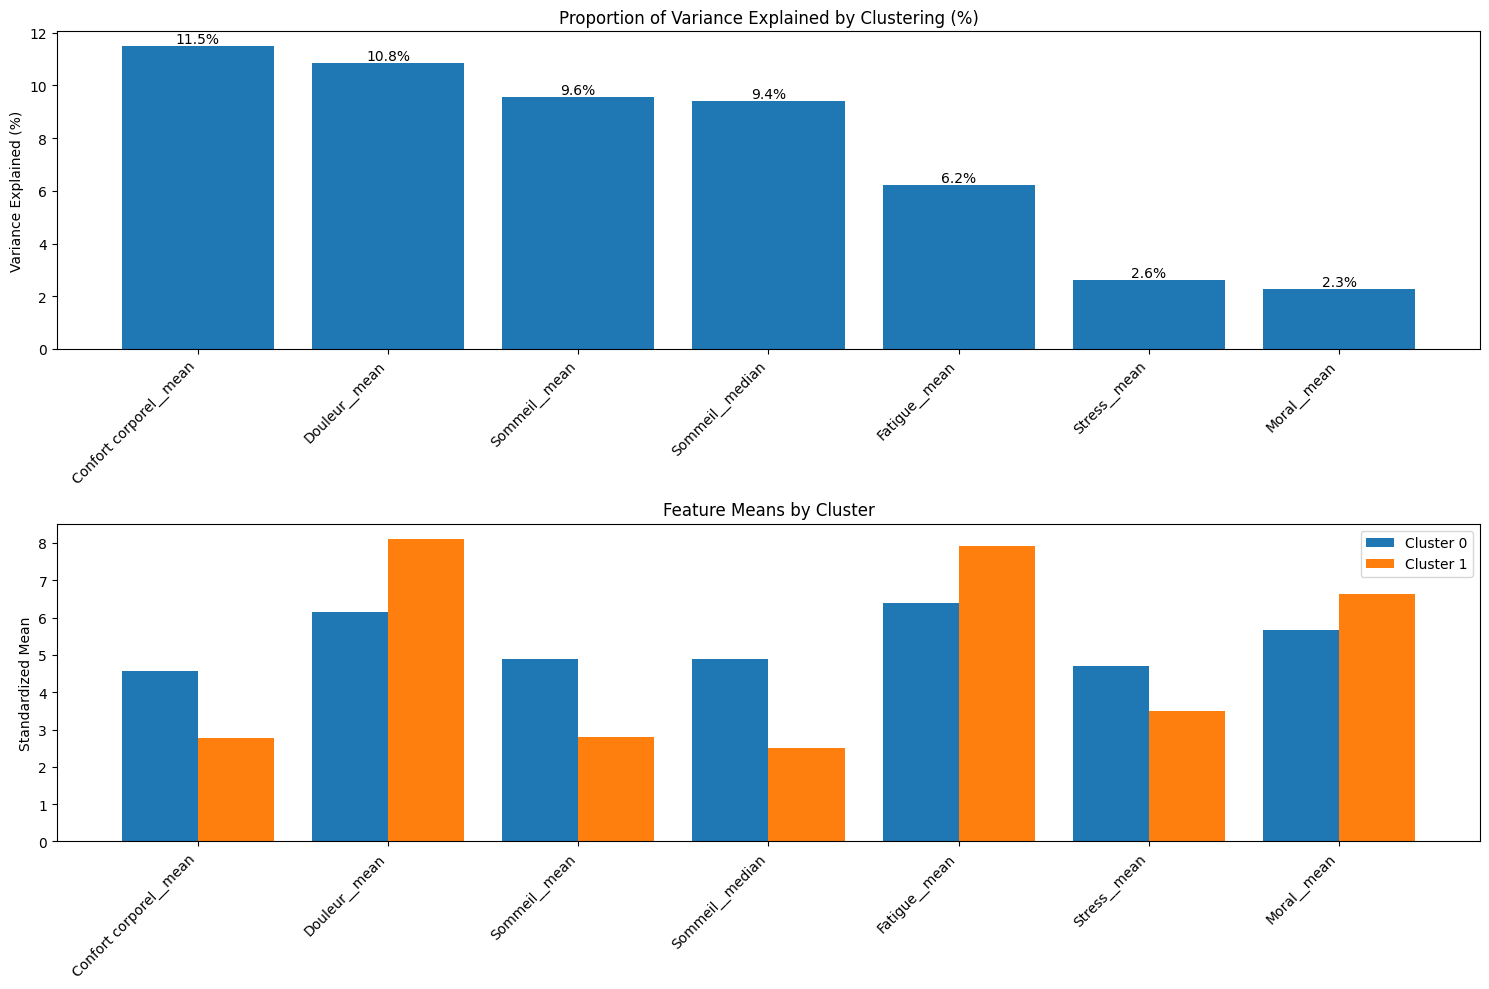

In [ ]:
# DBSCAN
results = analyze_clustering_results(
    X=X_scaled,
    cluster_labels=best_pred_dbscan,
    feature_names=selected_features
)

<ipython-input-30-ddfab20a52d8>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_explained = (between_var / total_var[idx]) * 100



Categorization of Clustering Results

1. Feature Importance by Variance Explained:
--------------------------------------------------
               Feature  Variance_Explained_%
       Sommeil__median                 57.17
         Sommeil__mean                 55.02
         Fatigue__mean                 31.46
Confort corporel__mean                 28.33
           Moral__mean                 26.09
          Stress__mean                 22.35
         Douleur__mean                 18.45

2. Comparison of Means by Group:
--------------------------------------------------
               Feature  Overall  Cluster 0  Cluster 1  Var.Exp %  p-value
       Sommeil__median    4.732      3.652      6.714      57.17      0.0
         Sommeil__mean    4.741      3.825      6.422      55.02      0.0
         Fatigue__mean    6.485      7.117      5.327      31.46      0.0
Confort corporel__mean    4.443      3.926      5.394      28.33      0.0
           Moral__mean    5.731      5.131      6.

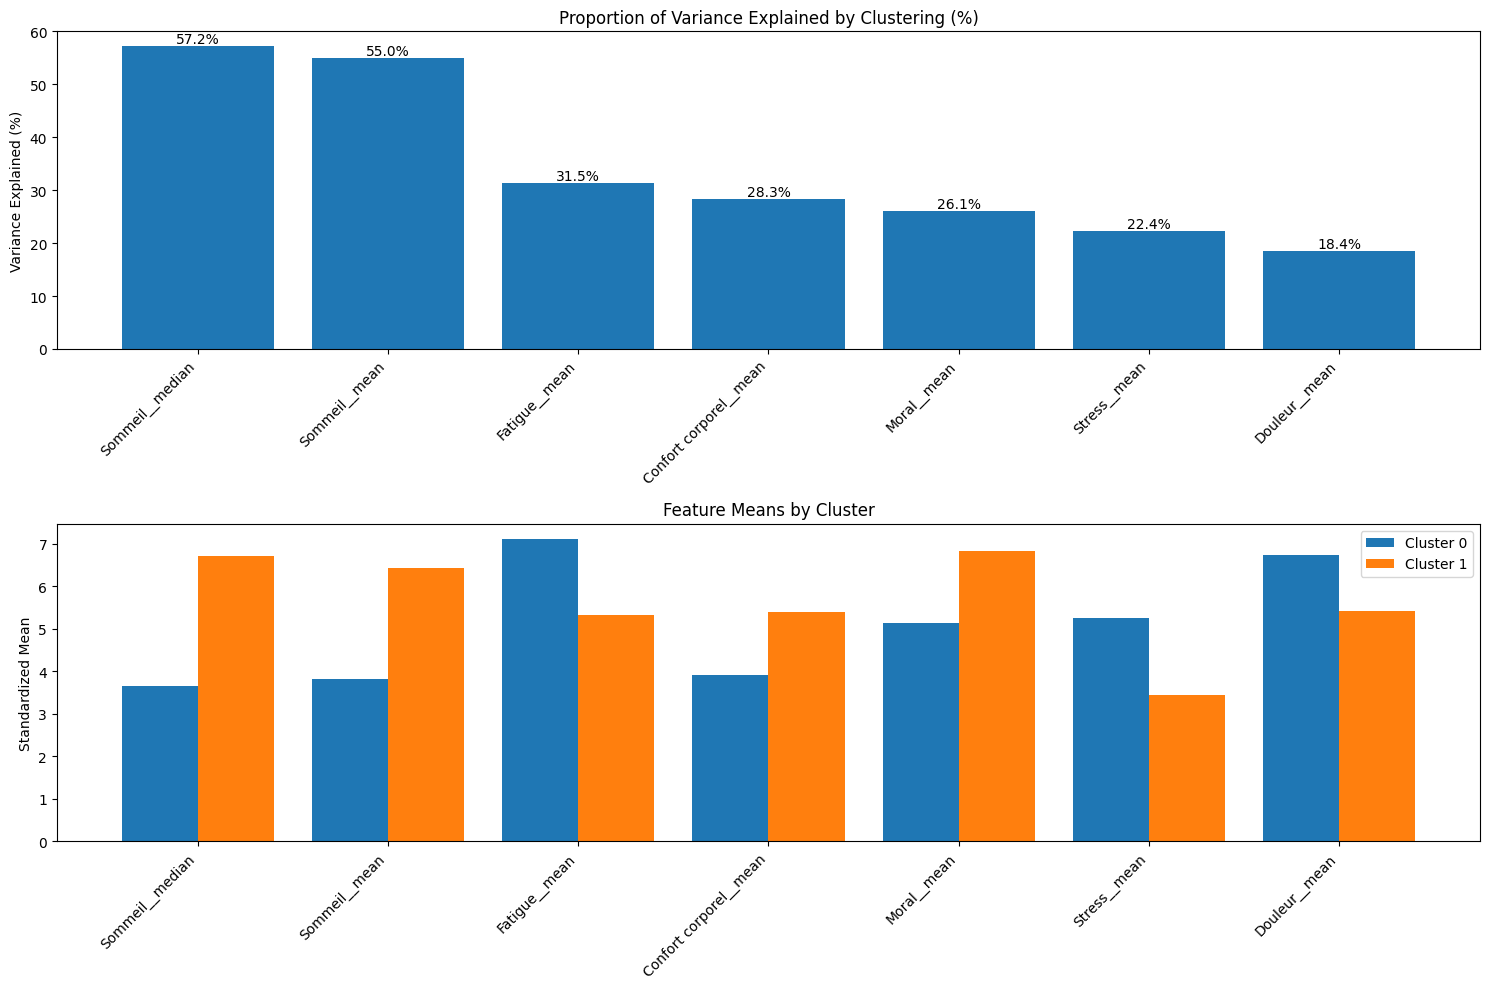

In [ ]:
# Kernel Kmeans
results = analyze_clustering_results(
    X=X_scaled,
    cluster_labels=best_pred,
    feature_names=selected_features
)

<ipython-input-14-7bcc4e9f44a2>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_explained = (between_var / total_var[idx]) * 100



Categorization of Clustering Results

1. Feature Importance by Variance Explained:
--------------------------------------------------
               Feature  Variance_Explained_%
         Sommeil__mean                 46.45
       Sommeil__median                 45.37
         Fatigue__mean                 36.62
          Stress__mean                 33.47
           Moral__mean                 31.40
Confort corporel__mean                 28.11
         Douleur__mean                 24.10

2. Comparison of Means by Group:
--------------------------------------------------
               Feature  Overall  Cluster 0  Cluster 1  Var.Exp %  p-value
         Sommeil__mean    4.741      3.617      5.898      46.45      0.0
       Sommeil__median    4.732      3.447      6.054      45.37      0.0
         Fatigue__mean    6.485      7.395      5.550      36.62      0.0
          Stress__mean    4.621      5.674      3.537      33.47      0.0
           Moral__mean    5.731      4.851      6.

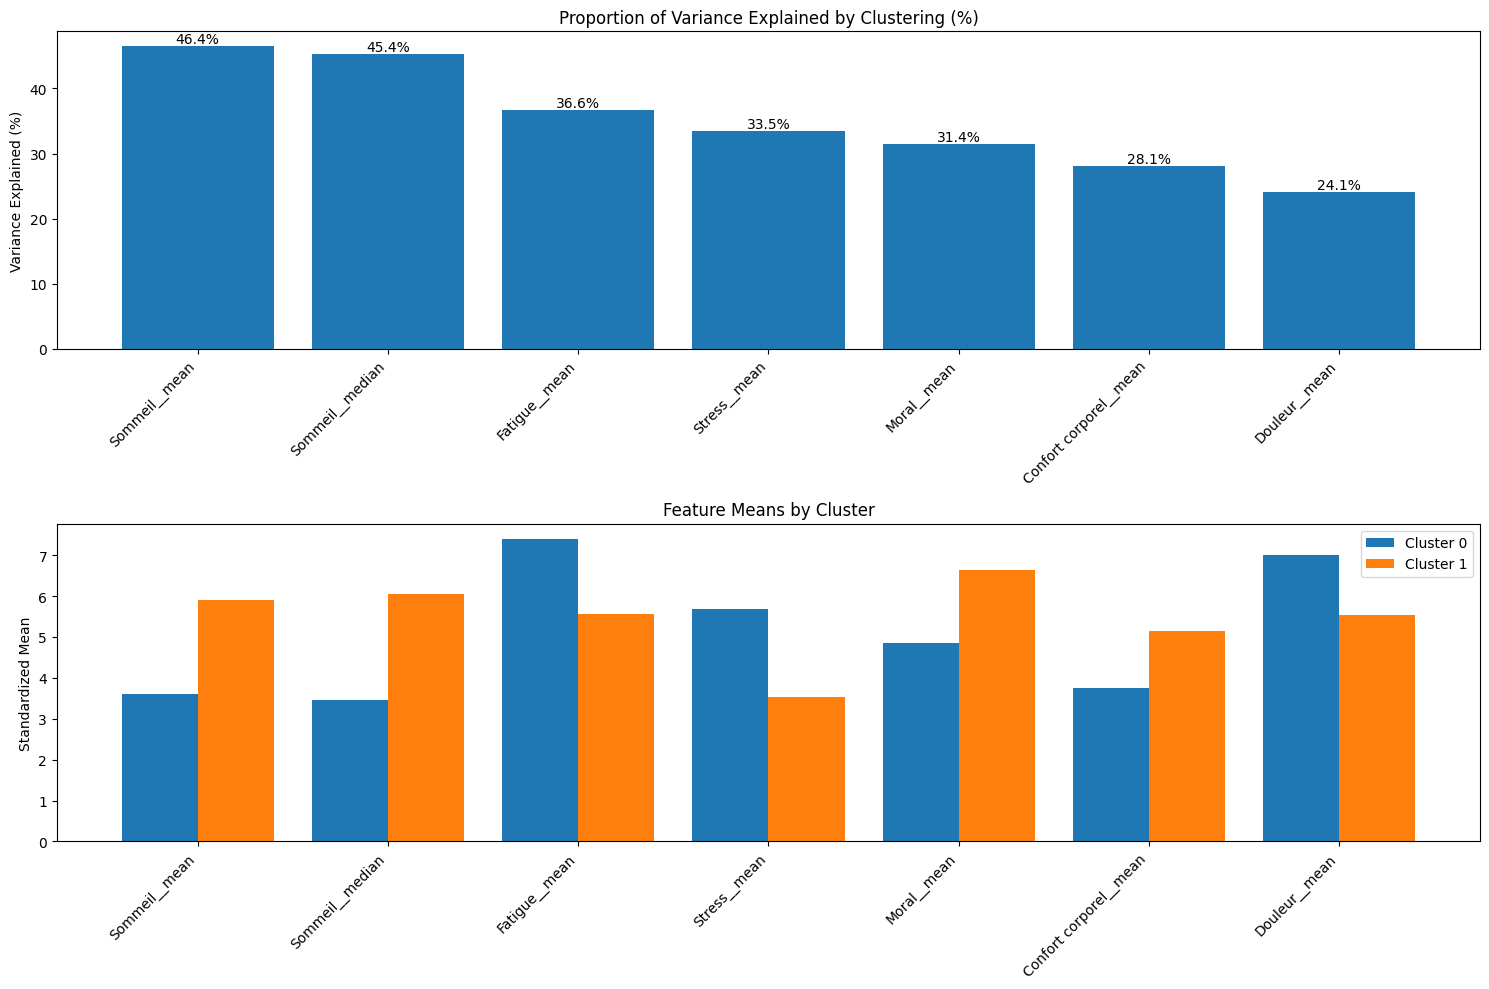

In [ ]:
# Kernel Fuzzy C-means
results = analyze_clustering_results(
    X=X_scaled,
    cluster_labels=kfcm_best_pred,
    feature_names=selected_features
)

<ipython-input-14-7bcc4e9f44a2>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_explained = (between_var / total_var[idx]) * 100



Categorization of Clustering Results

1. Feature Importance by Variance Explained:
--------------------------------------------------
               Feature  Variance_Explained_%
       Sommeil__median                 49.84
         Sommeil__mean                 49.82
         Fatigue__mean                 37.21
Confort corporel__mean                 29.22
           Moral__mean                 28.38
          Stress__mean                 27.04
         Douleur__mean                 26.46

2. Comparison of Means by Group:
--------------------------------------------------
               Feature  Overall  Cluster 0  Cluster 1  Var.Exp %  p-value
       Sommeil__median    4.732      6.384      3.602      49.84      0.0
         Sommeil__mean    4.741      6.169      3.764      49.82      0.0
         Fatigue__mean    6.485      5.361      7.255      37.21      0.0
Confort corporel__mean    4.443      5.305      3.854      29.22      0.0
           Moral__mean    5.731      6.755      5.

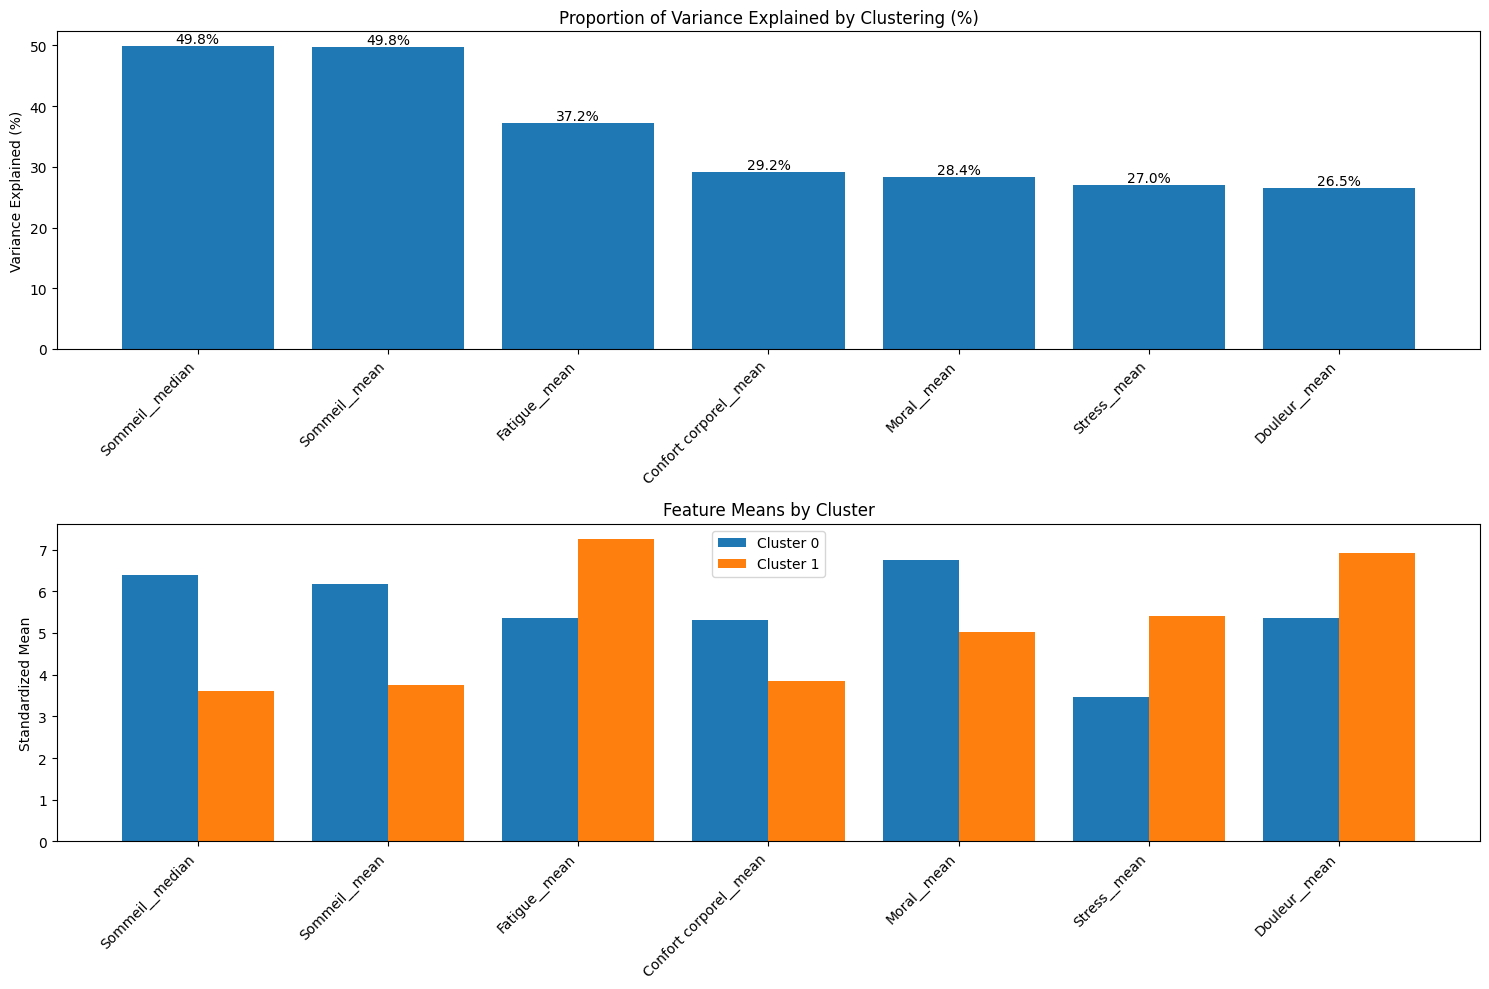

,Feature,Overall_Mean,Overall_Std,Cluster_0_Mean,Cluster_1_Mean,Cluster_0_Std,Cluster_1_Std,Variance_Explained_%,F_statistic,P_value
3,Sommeil__median,4.732283,1.936690,6.383721,3.602122,1.484042,1.291151,49.838694,628.928868,6.581636e-97
0,Sommeil__mean,4.741198,1.674508,6.168792,3.764224,1.240987,1.148865,49.819360,628.442669,7.436807e-97
6,Fatigue__mean,6.485462,1.525819,5.361281,7.254796,1.374396,1.083451,37.207435,375.081124,5.656646e-66
1,Confort corporel__mean,4.443484,1.318715,5.304523,3.854232,1.167180,1.069697,29.221769,261.342775,1.818987e-49
2,Moral__mean,5.730592,1.592461,6.755250,5.029368,1.224128,1.427700,28.378092,250.807791,7.850333e-48
4,Stress__mean,4.620536,1.847926,3.459962,5.414774,1.492566,1.636636,27.035780,234.548505,2.867927e-45
5,Douleur__mean,6.282709,1.476435,5.365390,6.910475,1.453702,1.121898,26.459048,227.744912,3.502719e-44


In [ ]:
# Spectral Clustering
analyze_clustering_results(
    X=X_scaled,
    cluster_labels=spectral_best_pred,
    feature_names=selected_features
)

<ipython-input-14-7bcc4e9f44a2>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_explained = (between_var / total_var[idx]) * 100



Categorization of Clustering Results

1. Feature Importance by Variance Explained:
--------------------------------------------------
               Feature  Variance_Explained_%
          Stress__mean                 58.36
           Moral__mean                 50.25
         Fatigue__mean                 23.43
         Sommeil__mean                 15.66
       Sommeil__median                 14.70
Confort corporel__mean                 13.84
         Douleur__mean                 13.58

2. Comparison of Means by Group:
--------------------------------------------------
               Feature  Overall  Cluster 0  Cluster 1  Var.Exp %  p-value
          Stress__mean    4.621      3.158      5.981      58.36      0.0
           Moral__mean    5.731      6.900      4.643      50.25      0.0
         Fatigue__mean    6.485      5.720      7.197      23.43      0.0
         Sommeil__mean    4.741      5.428      4.103      15.66      0.0
       Sommeil__median    4.732      5.502      4.

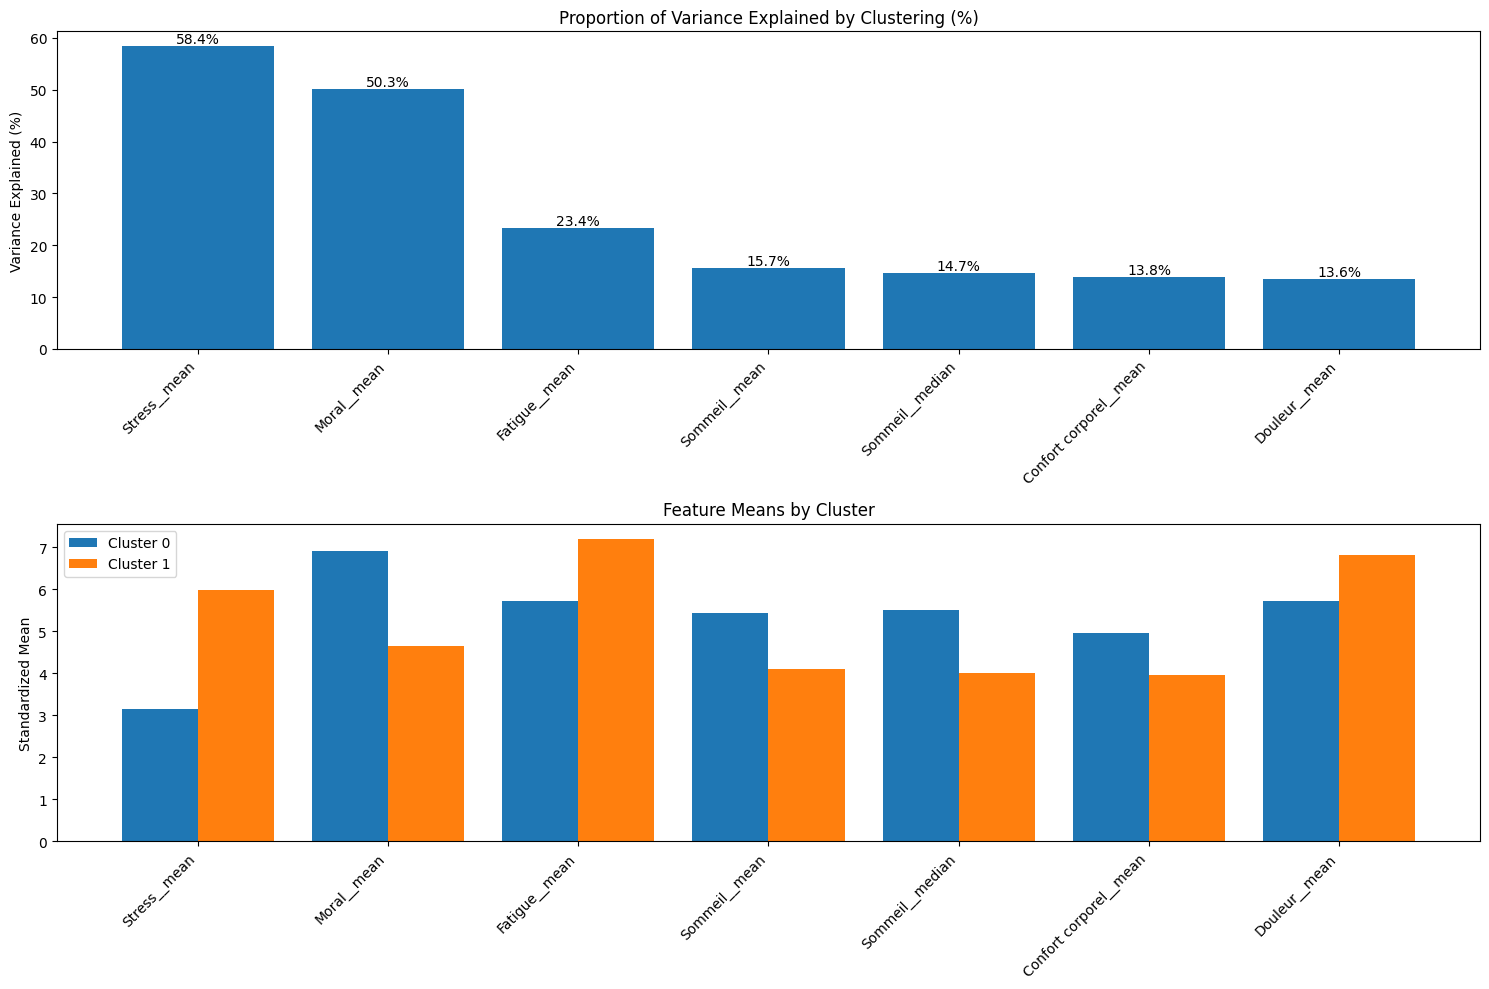

In [ ]:
# DEC result analysis
results = analyze_clustering_results(
    X=X_scaled,
    cluster_labels=y_pred,
    feature_names=selected_features
)